### Outline

The goal is to incorporate the improvements (enhanced features, robust scaling, class weighting, hyperparameter tuning) while maintaining the core LSTM-EnKF + MC Dropout methodology.

The research objectives and questions are centered around developing and evaluating a hybrid machine learning and data assimilation approach for forecasting red tide blooms.

**Research Objectives:**

* Develop an LSTM (Long Short-Term Memory) neural network model to forecast red tide bloom events (specifically *Karenia brevis*, indicated by `kb`) based on environmental time-series data.
* Investigate the impact of different feature engineering strategies (basic vs. enhanced lags and rolling aggregates) on forecasting performance.
* Compare different data preprocessing techniques, specifically scaling methods (RobustScaler vs. StandardScaler) and the use of class weighting to handle data imbalance.
* Optimize the LSTM model architecture and training parameters through hyperparameter tuning.
* Integrate an Ensemble Kalman Filter (EnKF) with the LSTM model to assimilate real-time observations of key environmental variables (river discharge, nutrients) and improve state estimation within the forecasting process.
* Optionally, evaluate the use of Monte Carlo (MC) Dropout with the LSTM model to quantify prediction uncertainty.
* Evaluate and compare the predictive performance of the baseline LSTM model against the hybrid LSTM-EnKF model (with and without MC Dropout) using standard classification metrics and a specific focus on predicting bloom onset events.

**Research Questions:**

* How effective is a standard LSTM model in predicting weekly red tide bloom occurrences based on available environmental predictors?
* Does incorporating more complex, domain-relevant features (e.g., multi-week rolling averages, specific lags for cell counts and environmental variables) significantly improve the forecast accuracy compared to using simpler lagged features?
* Which data scaling method (Robust or Standard) is more suitable for this dataset and model architecture?
* Does addressing the class imbalance (bloom vs. no bloom) using class weighting during training lead to a more effective bloom prediction model?
* Can hyperparameter tuning yield substantial improvements in the LSTM model's performance?
* How does assimilating observational data for specific environmental drivers (discharge, TN, TP) via EnKF impact the accuracy and reliability of the LSTM forecasts?
* Does the hybrid LSTM-EnKF approach lead to better prediction of bloom onset timing compared to the LSTM model alone?
* Can MC Dropout provide useful estimates of uncertainty associated with the bloom forecasts generated by the LSTM-EnKF model?

**Refactored Code Outline:**

- [x] **Part 1: Configuration & Setup**
  * Define all file paths (input data, saved components like scaler/model).
  * Set core parameters: `SEQUENCE_LENGTH`, `FORECAST_HORIZON`, `BLOOM_THRESHOLD`.
  * Define feature lists: `BASE_FEATURES`, `ENKF_STATE_VARS`, `ENHANCED_KB_LAGS` (optional).
  * **Control Flags/Options:**
    * `USE_ENHANCED_FEATURES`: Boolean (True/False) to switch between basic and enhanced feature engineering.
    * `SCALER_TYPE`: String ('Standard' or 'Robust') to choose the scaler.
    * `USE_CLASS_WEIGHT`: Boolean (True/False) to enable/disable class weighting during training.
    * `PERFORM_TUNING`: Boolean (True/False) to run hyperparameter tuning or use defaults.
    * `PERFORM_PHYSICS_LOSS`: Boolean (True/False) for the advanced physics-loss step.
  * Set tuning parameters: `MAX_TRIALS`, `TUNER_EPOCHS`.
  * Set training parameters: `EPOCHS`, `BATCH_SIZE`, `PATIENCE`.
  * Set EnKF parameters: `N_ENKF` (ensemble size), define noise matrix estimation approach (e.g., 'basic_stats' or 'manual').
  * Set MC Dropout parameters: `N_MC_SAMPLES`.
  * Import necessary libraries.
- [x] **Part 2: Data Loading & Initial Processing**
  * Function `load_and_prepare_data(filepath, datetime_col, target_col, bloom_threshold)`:
    * Loads data.
    * Handles datetime index.
    * Calculates wind components.
    * Creates binary target.
    * Returns initial processed DataFrame `df`.
  * *Optional:* Function `merge_external_data(df, external_files_dict)` to load and merge Caloosahatchee/Loop Current data if `USE_EXTERNAL_DATA` flag is set.
- [x] **Part 3: Feature Engineering**
  * Function `create_features(df, target_col, target_binary_col, use_enhanced=False, basic_lags_cfg=..., enhanced_lags_cfg=...)`:
    * Takes the DataFrame and configuration for lags.
    * If `use_enhanced` is True, calculates the detailed lags matching the RF notebook (weekly, monthly aggregates for `kb`, etc.).
    * If False, calculates basic lags defined in `basic_lags_cfg`.
    * Lags other environmental variables.
    * Drops initial NaN rows.
    * Returns `df_processed` with all features.
- [x] **Part 4: Data Splitting**
  * Function `split_data_chronological(df, train_ratio, val_ratio)`:
    * Performs time-based split.
    * Returns `train_df`, `validation_df`, `test_df` (unscaled).
- [x] **Part 5: Preprocessing (Imputation & Scaling)**
  * Function `preprocess_data(train_df, validation_df, test_df, target_col, scaler_type='Robust')`:
    * Handles remaining NaNs (fit imputer on `train_df` only).
    * Initializes chosen scaler (`RobustScaler` or `StandardScaler`).
    * Fits scaler on `train_df[feature_columns]` only.
    * Transforms all three sets (`train_df`, `validation_df`, `test_df`).
    * Saves the scaler and final feature list.
    * Returns `train_scaled_df`, `validation_scaled_df`, `test_scaled_df`, `scaler`, `final_feature_columns`.
- [x] **Part 6: Sequence Creation**
  * Function `create_sequences(df_scaled, feature_cols, target_col, seq_len, forecast_horizon)`:
    * Generates `X`, `y` sequences from a scaled DataFrame.
  * Apply this function to `train_scaled_df`, `validation_scaled_df`, `test_scaled_df`.
  * Output: `X_train`, `y_train`, `X_val`, `y_val`, `X_test`, `y_test`.
  * Save sequences (optional).
- [x] **Part 7: Model Definition (LSTM)**
  * Function `build_lstm_model(input_shape, hp=None)`:
    * Defines the LSTM architecture.
    * Takes an optional `hp` argument (from KerasTuner) or uses default units/dropout rates defined in config.
- [x] **Part 8: Hyperparameter Tuning (Conditional)**
  * Run only if `PERFORM_TUNING` is True.
  * Function `tune_hyperparameters(build_fn, x_train, y_train, x_val, y_val, max_trials, epochs, batch_size)`:
    * Sets up KerasTuner (`RandomSearch` or `Hyperband`).
    * Runs `tuner.search()`.
    * Returns `best_hyperparameters`.
- [x] **Part 9: Model Training**
  * Function `train_model(x_train, y_train, x_val, y_val, input_shape, use_class_weight=False, best_hps=None, epochs=..., batch_size=..., patience=..., checkpoint_path=...)`:
    * Builds the model (using `best_hps` if available, else defaults).
    * Calculates `class_weights_dict` if `use_class_weight` is True.
    * Compiles the model.
    * Sets up callbacks (`EarlyStopping`, `ModelCheckpoint`).
    * Runs `model.fit()`, passing `class_weight` if applicable.
    * Loads best weights from checkpoint.
    * Returns the trained `model` and history.
- [x] **Part 10: Baseline Evaluation**
  * Function `evaluate_model(model, x_test, y_test, test_df_index, seq_len, forecast_horizon, model_name)`:
    * Makes predictions.
    * Calculates metrics.
    * Generates classification report and confusion matrix plot.
    * Generates prediction vs. actuals plot (using `test_df_index`).
    * Performs bloom onset analysis.
    * Prints results clearly labeled with `model_name`.
  * Call this function with the baseline trained model.
- [x] **Part 11: EnKF Setup (Conditional)**
  * EnKF class definition (in `enkf.py` or a cell).
  * Function `setup_enkf(config, train_df, test_df, feature_columns, scaler)`:
    * Determines initial state from `test_df`.
    * Calculates/sets noise matrices `R` and `Q` based on config approach (e.g., 'basic_stats' or 'manual').
    * Finds indices of EnKF state variables in `feature_columns`.
    * Initializes and returns `enkf` instance and `enkf_indices`.
  * Run only if `PERFORM_ENKF` is True.
- [x] **Part 12: EnKF + MC Dropout Forecasting Loop (Conditional)**
  * Function `run_enkf_mc_forecast(...)`:
    * Runs the simulation loop over the test set.
    * If `PERFORM_ENKF` is True: performs EnKF predict/update for state variables using observations from the unscaled test set, scales the updated state, and injects it into the LSTM input sequence.
    * If `PERFORM_MC_DROPOUT` is True: makes `n_mc_samples` predictions for each time step with dropout enabled (`training=True`).
    * Stores prediction results (single probabilities or MC samples).
    * Returns prediction array and trimmed `y_test_trimmed`.
  * Run only if `PERFORM_ENKF` or `PERFORM_MC_DROPOUT` is True.
- [x] **Part 13: EnKF + MC Dropout Evaluation (Conditional)**
  * Function `evaluate_mc_predictions(...)`:
    * Takes the prediction results from Part 12.
    * If MC predictions are available, calculates mean, std dev, and CIs.
    * Calculates standard classification metrics (Accuracy, Precision, Recall, F1, AUC, Brier) using the *mean* predictions.
    * Generates confusion matrix and classification report for the mean predictions.
    * Generates the probabilistic forecast plot (mean + CI).
    * Performs bloom onset analysis using the binary classification derived from the mean predictions.
    * Saves metrics, report, and plots.
    * Returns dictionary of metrics.
  * Run only if `PERFORM_ENKF` or `PERFORM_MC_DROPOUT` is True.
- [x] **Part 14: Model Interpretability (SHAP)**
  * Generate SHAP values for the trained model on a subset of the test data.
  * Visualize SHAP results using summary plots (feature importance) and potentially time-dependent plots for individual instances.
- [x] **Part 15: Residual Analysis**
  * Calculate residuals (Actual - Predicted Probability) for the test set.
  * Plot the Autocorrelation Function (ACF) of the residuals to identify remaining temporal patterns.
  * Optionally plot residuals over time.
- [x] **Part 16: Observed vs Simulated Plot**
  * Generate scatter plot and time series plot comparing observed bloom state to mean predicted probability.
- [ ] **Part 18: Results Summary & Comparison**
  * Collect key metrics from all evaluated models (Baseline, Weighted Baseline, Tuned Baseline, EnKF+LSTM, EnKF+MC, Physics-Informed).
  * Present in a table or summary for easy comparison.
  * Final discussion points based on results (including SHAP and residual analysis insights).
  * **Finish task**: Put the findings from the earlier stages into a format that anyone can read.

* * *

**Discussion:**

* This outline breaks the process into smaller, more manageable functions/parts.
* It introduces configuration flags to easily switch between different approaches (scaler type, feature sets, class weighting, tuning, EnKF, MC Dropout, Physics Loss).
* It separates model definition, training, tuning, and evaluation logic.
* It explicitly includes the step of getting the *unscaled* test data for EnKF observations.
* The Physics-Informed part is marked as optional/advanced.
* Added steps for Model Interpretability (SHAP), Residual Analysis, and Observed vs Simulated plotting.
* Updated status of completed parts with checkboxes.

*Note: This outline has been updated to reflect the code executed in the notebook.*

# Library installation

In [ ]:
!pip install tensorflow.keras
!pip install keras_tuner
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import shap
import json
import itertools
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, AUC, Recall, Precision, F1Score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             brier_score_loss, accuracy_score, precision_score,
                             recall_score, f1_score)
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, brier_score_loss, classification_report,
                             confusion_matrix, precision_recall_curve)
from sklearn.utils.class_weight import compute_class_weight
try:
    import keras_tuner as kt
except ImportError:
    print("Warning: KerasTuner not installed. Tuning functionality will be disabled.")
    kt = None
try:
    from tqdm.notebook import tqdm
    print("Using tqdm.notebook for progress bars.")
except ImportError:
    try:
        from tqdm import tqdm
        print("Using standard tqdm for progress bars.")
    except ImportError:
        print("Warning: tqdm not installed. Progress bars will not be shown.")
        # Define a dummy tqdm function if not installed
        def tqdm(iterable=None, *args, **kwargs):
            if iterable is None:
                # Handle case where tqdm is called without an iterable
                class DummyTqdm:
                    def __enter__(self): return self
                    def __exit__(self, *args): pass
                    def update(self, n=1): pass
                    def close(self): pass
                    def set_description(self, desc): pass
                return DummyTqdm()
            else:
                return iterable

print("Imported libraries.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 10.1 MB/s eta 0:00:00
Using tqdm.notebook for progress bars.
Imported libraries.


**Part 1: Configuration & Setup**
* Define all file paths (input data, saved components like scaler/model).
* Set core parameters: `SEQUENCE_LENGTH`, `FORECAST_HORIZON`, `BLOOM_THRESHOLD`.
* Define feature lists: `BASE_FEATURES`, `ENKF_STATE_VARS`, `ENHANCED_KB_LAGS` (optional).
* **Control Flags/Options:**
    * `USE_ENHANCED_FEATURES`: Boolean (True/False) to switch between basic and enhanced feature engineering.
    * `SCALER_TYPE`: String ('Standard' or 'Robust') to choose the scaler.
    * `USE_CLASS_WEIGHT`: Boolean (True/False) to enable/disable class weighting during training.
    * `PERFORM_TUNING`: Boolean (True/False) to run hyperparameter tuning or use defaults.
* Set tuning parameters: `MAX_TRIALS`, `TUNER_EPOCHS`.
* Set training parameters: `EPOCHS`, `BATCH_SIZE`, `PATIENCE`.
* Set EnKF parameters: `N_ENKF` (ensemble size), define noise matrix estimation approach (e.g., 'basic_stats' or 'manual').
* Set MC Dropout parameters: `N_MC_SAMPLES`.


##Part 1: Configurations

In [ ]:
# Set these flags to control the workflow execution
# === Feature Engineering ===
# Set to True to use detailed lags (like RF paper), False: Use basic lags
USE_ENHANCED_FEATURES = True

# === Preprocessing ===
# Options: 'Robust' or 'Standard'
SCALER_TYPE = 'Robust'

# === Training ===
# Set to True to apply class weighting during LSTM training
USE_CLASS_WEIGHT = True
# Set to True to run KerasTuner hyperparameter search, False to use default HPs
PERFORM_TUNING = True

# === Advanced Steps ===
# Set to True to run EnKF data assimilation during testing/forecasting
PERFORM_ENKF = True

In [ ]:
# --- File Paths ---
INPUT_DATA_PATH = 'data_weekly_interpolated.csv'
# Directory for optional external files (e.g., Caloosahatchee) - Ensure this exists if used
EXTERNAL_DATA_DIR = 'external_data/'
# Directory to save results, models, scalers (use a distinct name)
OUTPUT_DIR = 'output_refactored/'
# Construct filenames dynamically based on config where appropriate
scaler_suffix = SCALER_TYPE.lower()
feature_suffix = 'enhanced' if USE_ENHANCED_FEATURES else 'basic'
SCALER_FILENAME = os.path.join(OUTPUT_DIR, f'red_tide_scaler_{scaler_suffix}.joblib')
FEATURE_LIST_FILENAME = os.path.join(OUTPUT_DIR, f'red_tide_feature_list_{feature_suffix}.joblib')
# Template for sequence files: {horizon}{feature_suffix}
SEQUENCES_FILENAME_TEMPLATE = os.path.join(OUTPUT_DIR, 'sequences_horizon{}wk_{}.npz')
# Template for model checkpoint files: {model_type} e.g., baseline_weighted
# Using .keras extension for saving the full model (architecture + weights + optimizer state)
MODEL_CHECKPOINT_TEMPLATE = os.path.join(OUTPUT_DIR, 'best_lstm_model_{}.keras')
# Use .weights.h5 if saving only weights (e.g., for subclassed models like physics-informed)
MODEL_WEIGHTS_CHECKPOINT_TEMPLATE = os.path.join(OUTPUT_DIR, 'best_lstm_model_{}.weights.h5')

TUNER_PROJECT_DIR = 'keras_tuner_dir_refactored' # Use a new name
TUNER_PROJECT_NAME = 'red_tide_lstm_tuning'

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory: {OUTPUT_DIR}")

Output directory: output_refactored/


In [ ]:
# --- Core Parameters ---
DATETIME_COL = 'time'
TARGET_COL = 'kb' # Original cell count column
TARGET_BINARY_COL = 'bloom_target' # Binary target column name
BLOOM_THRESHOLD = 1e5 # Cells/L
SEQUENCE_LENGTH = 12  # Default sequence length (can be tuned)
FORECAST_HORIZON = 1   # Default forecast horizon (1-week or 4-week)

In [ ]:
# --- Feature Engineering Configuration ---
BASE_FEATURES = [ # Features from the core dataset to consider initially
    'zos', 'water_temp',
    'peace_discharge', 'peace_TN', 'peace_TP',
    'wind_u', 'wind_v'
]
# Define basic lag configuration
BASIC_LAG_CONFIG = {
    'kb_lags': [1, 2],
    'env_lags': list(range(1, 7)) # e.g., 1 to 6 weeks
}
# Define enhanced lag configuration (matching RF paper more closely)
ENHANCED_LAG_CONFIG = {
    # 'kb_lags': [1, 2],
    'kb_rolling_windows': [(1, 4), (5, 8), (9, 12)], # (start_lag, end_lag) for mean & prop
    'discharge_rolling_window': 4, # e.g., 4-week avg discharge lag 1
    'env_lags': [1] # Lags for other env vars in enhanced mode
}

# --- Data Splitting ---
TRAIN_SPLIT_RATIO = 0.70
VALIDATION_SPLIT_RATIO = 0.15
# Test split is the remainder

# --- LSTM Model Default Hyperparameters (Used if PERFORM_TUNING is False) ---
DEFAULT_LSTM_UNITS = 64
DEFAULT_DROPOUT_RATE = 0.3
DEFAULT_LEARNING_RATE = 0.001

# --- KerasTuner Configuration (Used if PERFORM_TUNING is True) ---
TUNER_MAX_TRIALS = 10
TUNER_EPOCHS = 30
TUNER_BATCH_SIZE = 32

# --- Training Parameters ---
TRAIN_EPOCHS = 50
TRAIN_BATCH_SIZE = 32
TRAIN_PATIENCE = 10 # For EarlyStopping

# --- EnKF Configuration ---
ENKF_STATE_VARS = [
    'peace_discharge', 'peace_TN', 'peace_TP', 'kb','wind_u', 'wind_v'
]
# Variables to assimilate
N_ENKF = 50 # Ensemble size
# Noise Estimation Approach ('basic_stats' uses train set stats, 'manual' requires defining R_diag, Q_diag below)
ENKF_NOISE_ESTIMATION = 'manual'
# Manual noise variances (used only if ENKF_NOISE_ESTIMATION = 'manual') - Define placeholder values
MANUAL_R_DIAG = [
    (100.0 * 0.01)**2, # Discharge (Trust the gauge)
    (0.2 * 0.01)**2,   # TN (Trust the sample)
    (0.02 * 0.01)**2,  # TP
    (5.0 * 0.05)**2,   # Wind U (Wind is noisy, maybe 5% error)
    (5.0 * 0.05)**2,   # Wind V
    (0.1 * 0.01)**2    # ZOS (Trust the satellite)] # Example observation noise variances
    ]
MANUAL_Q_DIAG = [
    (150.0 * 2.0)**2,  # Discharge can spike massively
    (0.3 * 2.0)**2,    # TN spikes
    (0.03 * 2.0)**2,   # TP spikes
    (10.0 * 1.5)**2,   # Wind changes direction rapidly
    (10.0 * 1.5)**2,   # Wind V
    (0.1 * 1.0)**2     # ZOS changes
]

# --- MC Dropout Configuration ---
N_MC_SAMPLES = 50


# --- Print Setup Summary ---
print("\n--- Workflow Configuration Summary ---")
print(f"Enhanced Features Enabled: {USE_ENHANCED_FEATURES}")
print(f"Scaler Type Selected: {SCALER_TYPE}")
print(f"Class Weighting Enabled: {USE_CLASS_WEIGHT}")
print(f"Hyperparameter Tuning Enabled: {PERFORM_TUNING}")
print(f"EnKF Enabled: {PERFORM_ENKF}")
print(f"Sequence Length: {SEQUENCE_LENGTH}")
print(f"Forecast Horizon: {FORECAST_HORIZON} week(s)")
if PERFORM_TUNING:
    print(f"Tuner Max Trials: {TUNER_MAX_TRIALS}, Epochs per Trial: {TUNER_EPOCHS}")
else:
    print(f"Using Default LSTM HPs: Units={DEFAULT_LSTM_UNITS}, Dropout={DEFAULT_DROPOUT_RATE}, LR={DEFAULT_LEARNING_RATE}")
if PERFORM_ENKF:
    print(f"EnKF Ensemble Size: {N_ENKF}, Noise Estimation: {ENKF_NOISE_ESTIMATION}")
print("------------------------------------")

# Check if optional modules were imported if flags are set
if PERFORM_TUNING and kt is None:
    print("\nWarning: KerasTuner (kt) not imported/installed, but PERFORM_TUNING is True. Tuning will be skipped.")
    PERFORM_TUNING = False # Disable tuning if library not available
if PERFORM_ENKF and 'EnsembleKalmanFilter' not in locals():
     # We will define EnKF class later, but good to note dependency
     print("\nNote: EnKF flag is True, ensure EnsembleKalmanFilter class is defined/imported later.")


--- Workflow Configuration Summary ---
Enhanced Features Enabled: True
Scaler Type Selected: Robust
Class Weighting Enabled: True
Hyperparameter Tuning Enabled: True
EnKF Enabled: True
Sequence Length: 12
Forecast Horizon: 1 week(s)
Tuner Max Trials: 10, Epochs per Trial: 30
EnKF Ensemble Size: 50, Noise Estimation: manual
------------------------------------

Note: EnKF flag is True, ensure EnsembleKalmanFilter class is defined/imported later.


## Part 2: Data Loading & Initial Processing

This cell defines and executes a function to load the raw weekly data, handle the datetime index, calculate U/V wind components, and create the binary target variable based on the bloom threshold. It uses the configuration parameters defined in Part 1.


Explanation:

1. calculate_wind_components(df): Takes a DataFrame, calculates U and V wind components if 'wind_direction' and 'wind_speed' exist, drops the original columns, and returns the modified DataFrame and a list of the newly added column names. Includes basic NaN handling for the calculation.
2. create_target(...): Takes the DataFrame and target configuration, ensures the original target column is numeric, drops rows where the target is NaN (important for supervised learning), creates the binary bloom_target column, prints the class distribution, and returns the DataFrame.
3. load_and_prepare_data(...): Orchestrates the initial steps: loads the CSV, sets the datetime index, calls calculate_wind_components, calls create_target, and returns the resulting DataFrame (df_initial). Includes error handling for file not found or missing columns.
4. merge_external_data(...) (Optional Placeholder): Provides a structure for loading and merging additional datasets based on a dictionary of file paths. It performs a left merge to keep all original data points. Note: This function needs actual file paths and assumes external CSVs have a compatible datetime index.
5. Main Execution Block (if __name__ == "__main__":): Calls load_and_prepare_data using the configuration variables. Includes a commented-out section showing how merge_external_data would be called if needed. Prints final info about the df_initial DataFrame. Includes basic NameError handling in case Part 1 wasn't run.

After running this cell, the df_initial DataFrame should contain the core data with wind components calculated and the binary bloom target created, ready for the feature engineering steps in Part 3.

In [ ]:
# Ensure configuration variables from Part 1 are accessible in the environment
# Example: INPUT_DATA_PATH, DATETIME_COL, TARGET_COL, BLOOM_THRESHOLD, TARGET_BINARY_COL

def calculate_wind_components(df):
    """Calculates U and V wind components if columns exist."""
    if 'wind_direction' in df.columns and 'wind_speed' in df.columns:
        print("Calculating wind U/V components...")
        # Ensure numeric types, handle potential NaNs before calculation
        df['wind_direction'] = pd.to_numeric(df['wind_direction'], errors='coerce')
        df['wind_speed'] = pd.to_numeric(df['wind_speed'], errors='coerce')

        # Temporarily fill NaNs with 0 for calculation if they exist
        wind_cols_to_check = ['wind_direction', 'wind_speed']
        if df[wind_cols_to_check].isnull().any().any():
            print("Warning: NaNs found in wind direction/speed. Temporarily filling with 0 for component calculation.")
            df[wind_cols_to_check] = df[wind_cols_to_check].fillna(0)

        wind_dir_rad = np.deg2rad(df['wind_direction'])
        wind_speed = df['wind_speed']
        # Meteorological convention: wind direction 'coming from'
        df['wind_u'] = -wind_speed * np.sin(wind_dir_rad)
        df['wind_v'] = -wind_speed * np.cos(wind_dir_rad)
        # Drop original wind columns
        df = df.drop(columns=['wind_direction', 'wind_speed'])
        print("Calculated wind U/V components and dropped original columns.")
        added_cols = ['wind_u', 'wind_v']
    else:
        print("Warning: 'wind_direction' or 'wind_speed' not found. Skipping component calculation.")
        added_cols = []
    return df, added_cols

def create_target(df, target_col, bloom_threshold, target_binary_col):
    """Creates the binary target variable."""
    if target_col not in df.columns:
        print(f"Error: Target column '{target_col}' not found.")
        return None # Return None if target column is missing

    print(f"Creating binary target '{target_binary_col}' using threshold {bloom_threshold:.0f} cells/L...")
    df[target_col] = pd.to_numeric(df[target_col], errors='coerce')

    # Handle potential NaNs in target before comparison by dropping rows
    initial_rows = len(df)
    if df[target_col].isnull().any():
        print(f"Warning: NaNs found in target column '{target_col}'. Dropping rows with NaN target.")
        df.dropna(subset=[target_col], inplace=True)
        print(f"Dropped {initial_rows - len(df)} rows with NaN in '{target_col}'. New shape: {df.shape}")

    df[target_binary_col] = (df[target_col] >= bloom_threshold).astype(int)
    print(f"Target distribution (%):\n{df[target_binary_col].value_counts(normalize=True) * 100}")
    return df

def load_and_prepare_data(filepath, datetime_col, target_col, bloom_threshold, target_binary_col):
    """Loads data, handles datetime, calculates wind components, creates target."""
    print(f"Loading data from: {filepath}")
    try:
        df = pd.read_csv(filepath)
        # Handle datetime index
        if datetime_col not in df.columns:
            raise ValueError(f"Datetime column '{datetime_col}' not found.")
        df[datetime_col] = pd.to_datetime(df[datetime_col])
        df = df.sort_values(datetime_col).set_index(datetime_col)
        print(f"Data loaded successfully. Shape: {df.shape}, Time range: {df.index.min()} to {df.index.max()}")
        print(f"Initial NaN counts:\n{df.isnull().sum()}")

        # Calculate wind components
        df, wind_cols = calculate_wind_components(df)

        # Create binary target
        df = create_target(df, target_col, bloom_threshold, target_binary_col)

        if df is not None:
            print("\n--- Initial Data Preparation Complete ---")
            print(f"DataFrame shape after initial processing: {df.shape}")
            print("Columns:", df.columns.tolist())
            print("\nFirst 5 rows:")
            print(df.head())
        return df

    except FileNotFoundError:
        print(f"Error: Input data file not found at {filepath}")
        return None
    except ValueError as ve:
        print(f"ValueError during data preparation: {ve}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred during data loading/preparation: {e}")
        return None

# --- Optional: Function Placeholder for Merging External Data ---
def merge_external_data(df, external_files_dict):
    """
    Loads and merges external data (e.g., Caloosahatchee Q/NOx) into the main dataframe.
    Args:
        df (pd.DataFrame): The main dataframe with datetime index.
        external_files_dict (dict): Dictionary where keys are column names (e.g., 'caloos_Q')
                                     and values are file paths to the external CSV data.
                                     External CSVs must have a compatible datetime index.
    Returns:
        pd.DataFrame: DataFrame with external data merged (left join).
    """
    print("\n--- Merging External Data (Placeholder) ---")
    if not external_files_dict:
        print("No external data files specified.")
        return df

    df_merged = df.copy()
    for col_name, file_path in external_files_dict.items():
        try:
            print(f"Loading external data for '{col_name}' from '{file_path}'...")
            # Assuming external CSV has datetime index named same as DATETIME_COL or is the index
            df_ext = pd.read_csv(file_path, index_col=DATETIME_COL, parse_dates=True) # Adjust index_col if needed
            df_ext = df_ext[[col_name]] # Keep only the specified column
            # Perform left merge
            df_merged = df_merged.merge(df_ext, left_index=True, right_index=True, how='left')
            print(f"Merged '{col_name}'. NaN count: {df_merged[col_name].isnull().sum()}")
        except FileNotFoundError:
            print(f"Warning: External data file not found: {file_path}. Skipping '{col_name}'.")
        except KeyError:
             print(f"Warning: Column '{col_name}' not found in file {file_path}. Skipping.")
        except Exception as e:
            print(f"Error merging external file {file_path}: {e}")

    print("External data merging complete.")
    return df_merged


# --- Execute Data Loading and Preparation ---
# Ensure config variables from Part 1 are defined before running this
if __name__ == "__main__":
    try:
        df_initial = load_and_prepare_data(
            INPUT_DATA_PATH,
            DATETIME_COL,
            TARGET_COL,
            BLOOM_THRESHOLD,
            TARGET_BINARY_COL
        )

        if df_initial is not None:
            # Display basic info about the prepared dataframe
            print("\n--- Dataframe after initial processing (df_initial) ---")
            df_initial.info()
        else:
            print("\nData loading/preparation failed.")

    except NameError as ne:
         print(f"NameError: A configuration variable might be missing. Did Part 1 run correctly? Error: {ne}")
    except Exception as e:
         print(f"An unexpected error occurred in main execution block: {e}")



Loading data from: data_weekly_intepolated.csv
Data loaded successfully. Shape: (1617, 9), Time range: 1993-01-04 00:00:00 to 2023-12-25 00:00:00
Initial NaN counts:
kb                 0
zos                0
salinity           0
water_temp         0
wind_direction     0
wind_speed         0
peace_discharge    0
peace_TN           0
peace_TP           0
dtype: int64
Calculating wind U/V components...
Calculated wind U/V components and dropped original columns.
Creating binary target 'bloom_target' using threshold 100000 cells/L...
Target distribution (%):
bloom_target
0    73.09833
1    26.90167
Name: proportion, dtype: float64

--- Initial Data Preparation Complete ---
DataFrame shape after initial processing: (1617, 10)
Columns: ['kb', 'zos', 'salinity', 'water_temp', 'peace_discharge', 'peace_TN', 'peace_TP', 'wind_u', 'wind_v', 'bloom_target']

First 5 rows:
               kb       zos   salinity  water_temp  peace_discharge  peace_TN  \
time                                         

## Part 3: Feature Engineering

This part defines and executes a function create_features that adds lagged features to the initially processed DataFrame (df_initial from Part 2). It uses the configuration flags set in Part 1 (USE_ENHANCED_FEATURES) to determine whether to create basic lags or the more detailed lags inspired by the Random Forest paper.

This cell defines the feature engineering function and applies it to the df_initial DataFrame. It creates lagged versions of environmental variables and, optionally, more detailed lagged and rolling aggregate features for K. brevis counts.

Explanation:

1. Configuration: It first defines or ensures access to the necessary configuration variables from Part 1 (like USE_ENHANCED_FEATURES, lag definitions, feature lists).
2. create_features(...) Function:
    - Takes the initial DataFrame (df_initial) and configuration details as input.
    - Selects either BASIC_LAG_CONFIG or ENHANCED_LAG_CONFIG based on the USE_ENHANCED_FEATURES flag.
    - KB Lags: Creates simple weekly lags (_L1, _L2) for the raw kb column.
    - KB Rolling Aggregates (Enhanced Only): Calculates rolling mean (_M1_mean, _M2_mean, etc.) and rolling proportion of bloom weeks (_M1_prop, _M2_prop, etc.) over specified windows (e.g., 4, 8, 12 weeks), shifted back appropriately.
    - Discharge Rolling Average (Enhanced Only): Calculates a rolling average (e.g., 4-week) for the primary discharge column, lagged by 1 week.
    - Environmental Lags: Creates simple weekly lags for all other specified environmental/hydrological variables (BASE_FEATURES). The number of lags depends on whether basic or enhanced mode is selected.
    - NaN Handling: Tracks the maximum lag introduced by any operation and drops the corresponding number of initial rows from the DataFrame to ensure sequences are complete.
    - All-NaN Column Check: Includes a check to identify and optionally drop columns that might become entirely NaN after lagging (important for sparse data).
    - Returns the final DataFrame (df_processed) with all engineered features.

3. Main Execution: Calls the create_features function with the appropriate arguments based on the configuration flags. Prints the head and tail of the resulting df_processed DataFrame.

After running this cell, df_processed will contain the data ready for splitting (Part 4) and subsequent preprocessing/modeling steps. The number of columns will vary depending on whether basic or enhanced features were generated.

In [ ]:
# --- Configuration (Ensure these are defined from Part 1 or redefined here) ---
TARGET_COL = 'kb'
TARGET_BINARY_COL = 'bloom_target'
USE_ENHANCED_FEATURES = True # Set based on Part 1 config

# Define lag configurations (can be pulled from Part 1 config)
BASIC_LAG_CONFIG = {
    'kb_lags': [1, 2],
    'env_lags': list(range(1, 7))
}
ENHANCED_LAG_CONFIG = {
    'kb_lags': [1, 2],
    'kb_rolling_windows': [(1, 4), (5, 8), (9, 12)], # (start_lag, end_lag)
    'discharge_rolling_window': 4, # Window size for rolling avg discharge
    'env_lags': [1] # Lags for other env vars in enhanced mode
}
# Features to lag (environmental/hydrological) - should include wind components if created
BASE_FEATURES = [
    'zos', 'water_temp',
    'peace_discharge', 'peace_TN', 'peace_TP',
    'wind_u', 'wind_v'
]

# --- Function Definition ---
def create_features(df, target_col, target_binary_col, base_features, use_enhanced=False, basic_cfg=None, enhanced_cfg=None):
    """Creates lagged and rolling features based on configuration."""
    if df is None:
        print("Error in create_features: Input DataFrame is None.")
        return None

    print(f"\n--- Creating Features (Enhanced Mode: {use_enhanced}) ---")
    df_featured = df.copy()
    all_created_feature_cols = list(df.columns) # Start with existing columns

    # Select config based on flag
    if use_enhanced:
        cfg = enhanced_cfg if enhanced_cfg else ENHANCED_LAG_CONFIG
        env_lags = cfg.get('env_lags', [1])
        kb_lags = cfg.get('kb_lags', [])
        kb_rolling_windows = cfg.get('kb_rolling_windows', [])
        discharge_rolling_window = cfg.get('discharge_rolling_window', None)
        print("Using ENHANCED feature configuration.")
    else:
        cfg = basic_cfg if basic_cfg else BASIC_LAG_CONFIG
        env_lags = cfg.get('env_lags', [])
        kb_lags = cfg.get('kb_lags', [])
        kb_rolling_windows = [] # No rolling features in basic mode
        discharge_rolling_window = None
        print("Using BASIC feature configuration.")

    max_lag_needed = 0 # Track the maximum lag introduced

    # --- Lagged K. brevis Features (Raw Counts) ---
    if target_col in df.columns and kb_lags:
        print(f"Creating lagged features for target: {target_col}...")
        df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
        for lag in kb_lags:
            col_name = f'{target_col}_L{lag}'
            df_featured[col_name] = df[target_col].shift(lag)
            all_created_feature_cols.append(col_name)
            max_lag_needed = max(max_lag_needed, lag)
        print(f"  Created KB weekly lags: L{', L'.join(map(str, kb_lags))}")
    elif kb_lags:
        print(f"Warning: Target column '{target_col}' not found for lagging.")

    # --- Rolling K. brevis Features (Enhanced Mode Only) ---
    if use_enhanced and kb_rolling_windows and target_col in df.columns and target_binary_col in df.columns:
        print("Creating rolling aggregate features for KB...")
        target_binary_1e5 = df[target_binary_col]
        monthly_lags_created = []
        max_roll_lag = 0
        for i, (start_lag, end_lag) in enumerate(kb_rolling_windows):
            window_size = end_lag - start_lag + 1
            month_lag_id = f'M{i+1}'
            monthly_lags_created.append(month_lag_id)
            max_roll_lag = max(max_roll_lag, end_lag) # Max lag needed for rolling window

            # Mean of raw kb over the window, shifted back
            col_name_mean = f'{target_col}_{month_lag_id}_mean'
            df_featured[col_name_mean] = df[target_col].rolling(window=window_size, min_periods=1).mean().shift(start_lag)
            all_created_feature_cols.append(col_name_mean)

            # Proportion of bloom weeks (target=1) over the window, shifted back
            col_name_prop = f'{target_binary_col}_{month_lag_id}_prop'
            df_featured[col_name_prop] = target_binary_1e5.rolling(window=window_size, min_periods=1).mean().shift(start_lag)
            all_created_feature_cols.append(col_name_prop)
        print(f"  Created approx KB monthly lags (mean, prop_bloom): {', '.join(monthly_lags_created)}")
        max_lag_needed = max(max_lag_needed, max_roll_lag) # Rolling needs lookback up to end_lag

    # --- Rolling Discharge Feature (Enhanced Mode Only) ---
    discharge_col = 'peace_discharge' # Or potentially 'caloos_Q' if prioritized/available
    if use_enhanced and discharge_rolling_window and discharge_col in df.columns:
         print(f"Creating rolling average feature for {discharge_col}...")
         window_size = discharge_rolling_window
         # Typically want average over past month, lagged by 1 week
         start_lag = 1
         col_name_discharge_roll = f'{discharge_col}_{window_size}w_avg_L{start_lag}'
         df_featured[col_name_discharge_roll] = df[discharge_col].rolling(window=window_size, min_periods=1).mean().shift(start_lag)
         all_created_feature_cols.append(col_name_discharge_roll)
         max_lag_needed = max(max_lag_needed, window_size + start_lag -1) # Max lookback needed
         print(f"  Created {col_name_discharge_roll}")


    # --- Lagged Environmental/Hydrological Features ---
    if env_lags:
        print("\nCreating lagged environmental/hydrological features...")
        lagged_env_cols_added_names = []
        max_env_lag = 0
        for feature in base_features:
             if feature in df.columns:
                df[feature] = pd.to_numeric(df[feature], errors='coerce') # Ensure numeric
                for lag in env_lags:
                    col_name = f'{feature}_L{lag}'
                    df_featured[col_name] = df[feature].shift(lag)
                    all_created_feature_cols.append(col_name)
                    max_env_lag = max(max_env_lag, lag)
                lagged_env_cols_added_names.append(feature)
             else:
                print(f"  Warning: Feature '{feature}' not found for lagging.")
        if lagged_env_cols_added_names:
            print(f"  Lagged features created for: {', '.join(lagged_env_cols_added_names)} using lags L{', L'.join(map(str, env_lags))}")
        max_lag_needed = max(max_lag_needed, max_env_lag)

    # --- Drop Rows with NaNs from Lagging/Rolling ---
    print(f"\nMaximum lag/window introduced: {max_lag_needed} weeks.")
    initial_rows = len(df_featured)
    if max_lag_needed > 0:
        df_processed = df_featured.iloc[max_lag_needed:].copy()
        print(f"Dropped first {max_lag_needed} rows due to NaNs generated by feature engineering.")
        print(f"Shape after dropping initial NaNs: {df_processed.shape}")
    else:
        df_processed = df_featured.copy()
        print("No lagging applied or max lag was 0, no initial rows dropped.")

    # Final check for all-NaN columns (can happen with rolling/shifting if data is sparse)
    all_nan_cols = df_processed.columns[df_processed.isnull().all()].tolist()
    if all_nan_cols:
        print(f"\nWarning: The following columns consist entirely of NaNs and will be dropped: {all_nan_cols}")
        df_processed = df_processed.dropna(axis=1, how='all')
        print(f"Shape after dropping all-NaN columns: {df_processed.shape}")

    # Ensure no duplicate columns (though unlikely with this structure)
    df_processed = df_processed.loc[:,~df_processed.columns.duplicated()]

    print("\n--- Feature Engineering Complete ---")
    print(f"Final number of columns (features + targets): {len(df_processed.columns)}")
    return df_processed

# --- Execute Feature Engineering ---
# Ensure df_initial exists from Part 2 and config variables from Part 1
if __name__ == "__main__":
    try:
        if 'df_initial' in locals() and df_initial is not None:
            # Determine which config to use based on the flag from Part 1
            lag_config_to_use = ENHANCED_LAG_CONFIG if USE_ENHANCED_FEATURES else BASIC_LAG_CONFIG
            features_to_lag_list = BASE_FEATURES # Modify if external data was added

            df_processed = create_features(
                df_initial,
                TARGET_COL,
                TARGET_BINARY_COL,
                features_to_lag_list,
                use_enhanced=USE_ENHANCED_FEATURES,
                basic_cfg=BASIC_LAG_CONFIG,
                enhanced_cfg=ENHANCED_LAG_CONFIG
            )

            if df_processed is not None:
                print("\nFirst 5 rows of processed data (df_processed):")
                display(df_processed.head())
                print("\nLast 5 rows:")
                display(df_processed.tail())
                print(f"\nFinal shape of df_processed: {df_processed.shape}")
            else:
                print("\nFeature engineering failed.")
        else:
            print("\nError: df_initial not found or is None. Please run Part 2 first.")

    except NameError as ne:
         print(f"NameError: A configuration variable might be missing. Did Part 1 run correctly? Error: {ne}")
    except Exception as e:
         print(f"An unexpected error occurred in main execution block: {e}")




--- Creating Features (Enhanced Mode: True) ---
Using ENHANCED feature configuration.
Creating lagged features for target: kb...
  Created KB weekly lags: L1, L2
Creating rolling aggregate features for KB...
  Created approx KB monthly lags (mean, prop_bloom): M1, M2, M3
Creating rolling average feature for peace_discharge...
  Created peace_discharge_4w_avg_L1

Creating lagged environmental/hydrological features...
  Lagged features created for: zos, water_temp, peace_discharge, peace_TN, peace_TP, wind_u, wind_v using lags L1

Maximum lag/window introduced: 12 weeks.
Dropped first 12 rows due to NaNs generated by feature engineering.
Shape after dropping initial NaNs: (1605, 26)

--- Feature Engineering Complete ---
Final number of columns (features + targets): 26

First 5 rows of processed data (df_processed):


kb       zos   salinity  water_temp  peace_discharge  peace_TN  \
time                                                                          
1993-03-29  0.0 -0.060247  33.304348        26.2           2000.0      2.02   
1993-04-05  0.0 -0.037195  33.326087        26.4           3290.0      5.68   
1993-04-12  0.0 -0.008214  33.347826        26.3           3140.0      9.34   
1993-04-19  0.0 -0.012612  33.369565        26.5           2040.0     13.00   
1993-04-26  0.0 -0.034968  33.391304        26.9           1800.0      9.30   

            peace_TP     wind_u     wind_v  bloom_target  ...  kb_M3_mean  \
time                                                      ...               
1993-03-29  1.504000 -11.346331   9.188078             0  ...      416.75   
1993-04-05  1.442667 -17.383315  -2.753247             0  ...      333.50   
1993-04-12  1.381333 -12.056565   9.419621             0  ...      166.75   
1993-04-19  1.320000  -9.191863 -10.954436             0  ...        0.00   
1993-04-26  1.440000 -12.943406   3.468175             0  ...        0.00   

            bloom_target_M3_prop  peace_discharge_4w_avg_L1    zos_L1  \
time                                                                    
1993-03-29                   0.0                     1822.5 -0.061417   
1993-04-05                   0.0                     2050.0 -0.060247   
1993-04-12                   0.0                     2600.0 -0.037195   
1993-04-19                   0.0                     2745.0 -0.008214   
1993-04-26                   0.0                     2617.5 -0.012612   

            water_temp_L1  peace_discharge_L1  peace_TN_L1  peace_TP_L1  \
time                                                                      
1993-03-29           25.5              2550.0        1.948     1.565333   
1993-04-05           26.2              2000.0        2.020     1.504000   
1993-04-12           26.4              3290.0        5.680     1.442667   
1993-04-19           26.3              3140.0        9.340     1.381333   
1993-04-26           26.5              2040.0       13.000     1.320000   

            wind_u_L1  wind_v_L1  
time                              
1993-03-29 -17.499440   5.685913  
1993-04-05 -11.346331   9.188078  
1993-04-12 -17.383315  -2.753247  
1993-04-19 -12.056565   9.419621  
1993-04-26  -9.191863 -10.954436  

[5 rows x 26 columns]


Last 5 rows:


kb       zos  salinity  water_temp  peace_discharge  peace_TN  \
time                                                                         
2023-11-27  0.0 -0.005114      36.0   27.110714            326.0    2.0675   
2023-12-04  0.0 -0.003981      36.0   26.992857            231.0    2.1800   
2023-12-11  0.0 -0.009013      36.0   26.528571            201.0    1.8400   
2023-12-18  0.0  0.005557      36.0   26.207143            460.0    2.2080   
2023-12-25  0.0  0.001243      36.0   26.053571            470.0    2.2080   

            peace_TP     wind_u    wind_v  bloom_target  ...  kb_M3_mean  \
time                                                     ...               
2023-11-27    0.8365 -11.482282 -2.065989             0  ...         0.0   
2023-12-04    0.8000 -12.302635  0.314994             0  ...         0.0   
2023-12-11    0.7900 -12.016729 -1.298361             0  ...         0.0   
2023-12-18    0.9700 -11.410499  4.251085             0  ...         0.0   
2023-12-25    0.9700 -13.387089  0.506480             0  ...         0.0   

            bloom_target_M3_prop  peace_discharge_4w_avg_L1    zos_L1  \
time                                                                    
2023-11-27                   0.0                     496.25  0.022788   
2023-12-04                   0.0                     392.25 -0.005114   
2023-12-11                   0.0                     323.25 -0.003981   
2023-12-18                   0.0                     287.50 -0.009013   
2023-12-25                   0.0                     304.50  0.005557   

            water_temp_L1  peace_discharge_L1  peace_TN_L1  peace_TP_L1  \
time                                                                      
2023-11-27      27.271429               392.0       1.9550       0.8730   
2023-12-04      27.110714               326.0       2.0675       0.8365   
2023-12-11      26.992857               231.0       2.1800       0.8000   
2023-12-18      26.528571               201.0       1.8400       0.7900   
2023-12-25      26.207143               460.0       2.2080       0.9700   

            wind_u_L1  wind_v_L1  
time                              
2023-11-27 -11.853374   4.605556  
2023-12-04 -11.482282  -2.065989  
2023-12-11 -12.302635   0.314994  
2023-12-18 -12.016729  -1.298361  
2023-12-25 -11.410499   4.251085  

[5 rows x 26 columns]


Final shape of df_processed: (1605, 26)


## Part 4: Data Splitting (Chronological)

This part defines and executes a function to split the feature-engineered DataFrame (df_processed from Part 3) into training, validation, and testing sets based on time. A chronological split is essential for time-series data to ensure the model is trained on past data and evaluated on future data, simulating a real-world forecasting scenario.

This cell defines the split_data_chronological function and applies it to df_processed. It uses the TRAIN_SPLIT_RATIO and VALIDATION_SPLIT_RATIO defined in Part 1 to divide the data.

Explanation:
1. Function split_data_chronological:
    - Takes the feature-engineered DataFrame (df_processed) and the desired train/validation ratios as input.
    - Includes checks to ensure the input DataFrame is valid and has a datetime index.
    - Calculates the number of samples for each set based on the ratios.
    - Performs the split using integer-location based indexing (iloc) which respects the chronological order. .copy() is used to avoid potential SettingWithCopyWarning later.
    - Prints the size and date range of each resulting subset.
    - Includes an assertion to double-check that the splits don't overlap.
    - Returns the three DataFrames: train_df, validation_df, test_df.

2. Main Execution:
    - Calls the function using df_processed (output of Part 3) and the ratios defined in the configuration (Part 1).
    - Stores the results in train_df, validation_df, and test_df. These variables will be used in subsequent steps (scaling, sequence creation, EnKF).
    - Prints the head of train_df for verification.

After running this cell, you will have the data divided into the necessary subsets for training, validation (tuning/early stopping), and final testing, while preserving the temporal order. The next step (Part 5) will handle imputation and scaling, fitting the necessary objects only on train_df.

In [ ]:
# --- Configuration (Ensure these are defined from Part 1 or redefined here) ---
TRAIN_SPLIT_RATIO = 0.70
VALIDATION_SPLIT_RATIO = 0.15
# Test split ratio is implicitly calculated

# --- Function Definition ---
def split_data_chronological(df, train_ratio, val_ratio):
    """
    Splits the DataFrame chronologically into train, validation, and test sets.

    Args:
        df (pd.DataFrame): The input DataFrame with a datetime index, sorted chronologically.
        train_ratio (float): The proportion of data to use for training (e.g., 0.7).
        val_ratio (float): The proportion of data to use for validation (e.g., 0.15).

    Returns:
        tuple: A tuple containing train_df, validation_df, test_df (pd.DataFrames),
               or (None, None, None) if splitting fails.
    """
    if df is None or df.empty:
        print("Error in split_data_chronological: Input DataFrame is None or empty.")
        return None, None, None
    if not isinstance(df.index, pd.DatetimeIndex):
         print("Error: DataFrame index must be a DatetimeIndex.")
         return None, None, None
    if not df.index.is_monotonic_increasing:
         print("Warning: DataFrame index is not sorted chronologically. Sorting now...")
         df = df.sort_index()

    print("\n--- Splitting Data into Train, Validation, and Test Sets (Chronological) ---")
    n_total = len(df)
    n_train = int(n_total * train_ratio)
    n_validation = int(n_total * val_ratio)
    n_test = n_total - n_train - n_validation

    # Ensure calculated splits are valid
    if n_train <= 0 or n_validation <= 0 or n_test <= 0:
         print(f"Error: Not enough data ({n_total} rows) to create non-empty train/validation/test splits.")
         print(f"Calculated splits: Train={n_train}, Val={n_validation}, Test={n_test}")
         return None, None, None
    if n_train + n_validation + n_test != n_total:
         print("Error: Split ratios do not sum correctly.")
         return None, None, None

    # Perform chronological split using iloc
    train_df = df.iloc[:n_train].copy()
    validation_df = df.iloc[n_train : n_train + n_validation].copy()
    test_df = df.iloc[n_train + n_validation :].copy() # Takes the rest

    print(f"Total samples: {n_total}")
    print(f"Training set:   {len(train_df)} samples (Index: {train_df.index.min()} to {train_df.index.max()})")
    print(f"Validation set: {len(validation_df)} samples (Index: {validation_df.index.min()} to {validation_df.index.max()})")
    print(f"Test set:       {len(test_df)} samples (Index: {test_df.index.min()} to {test_df.index.max()})")

    # Basic check for overlap
    assert train_df.index.max() < validation_df.index.min(), "Train/Validation sets overlap!"
    assert validation_df.index.max() < test_df.index.min(), "Validation/Test sets overlap!"

    print("Data splitting complete.")
    return train_df, validation_df, test_df

# --- Execute Data Splitting ---
# Ensure df_processed exists from Part 3
if __name__ == "__main__":
    try:
        if 'df_processed' in locals() and df_processed is not None:
            # Use ratios defined in Part 1 config
            train_df, validation_df, test_df = split_data_chronological(
                df_processed,
                TRAIN_SPLIT_RATIO,
                VALIDATION_SPLIT_RATIO
            )

            if train_df is not None:
                # Display head of training data as confirmation
                print("\nHead of Training Data (train_df):")
                display(train_df.head())
                # Keep test_df (unscaled) for later use with EnKF
                print("\nUnscaled test_df also created for EnKF observations.")
            else:
                print("\nData splitting failed.")
        else:
            print("\nError: df_processed not found or is None. Please run Part 3 first.")
            # Define placeholders to prevent errors if run out of order in notebook
            train_df, validation_df, test_df = None, None, None

    except NameError as ne:
         print(f"NameError: A configuration variable might be missing. Did Part 1 run correctly? Error: {ne}")
    except Exception as e:
         print(f"An unexpected error occurred in main execution block: {e}")
         train_df, validation_df, test_df = None, None, None




--- Splitting Data into Train, Validation, and Test Sets (Chronological) ---
Total samples: 1605
Training set:   1123 samples (Index: 1993-03-29 00:00:00 to 2014-09-29 00:00:00)
Validation set: 240 samples (Index: 2014-10-06 00:00:00 to 2019-05-06 00:00:00)
Test set:       242 samples (Index: 2019-05-13 00:00:00 to 2023-12-25 00:00:00)
Data splitting complete.

Head of Training Data (train_df):


kb       zos   salinity  water_temp  peace_discharge  peace_TN  \
time                                                                          
1993-03-29  0.0 -0.060247  33.304348        26.2           2000.0      2.02   
1993-04-05  0.0 -0.037195  33.326087        26.4           3290.0      5.68   
1993-04-12  0.0 -0.008214  33.347826        26.3           3140.0      9.34   
1993-04-19  0.0 -0.012612  33.369565        26.5           2040.0     13.00   
1993-04-26  0.0 -0.034968  33.391304        26.9           1800.0      9.30   

            peace_TP     wind_u     wind_v  bloom_target  ...  kb_M3_mean  \
time                                                      ...               
1993-03-29  1.504000 -11.346331   9.188078             0  ...      416.75   
1993-04-05  1.442667 -17.383315  -2.753247             0  ...      333.50   
1993-04-12  1.381333 -12.056565   9.419621             0  ...      166.75   
1993-04-19  1.320000  -9.191863 -10.954436             0  ...        0.00   
1993-04-26  1.440000 -12.943406   3.468175             0  ...        0.00   

            bloom_target_M3_prop  peace_discharge_4w_avg_L1    zos_L1  \
time                                                                    
1993-03-29                   0.0                     1822.5 -0.061417   
1993-04-05                   0.0                     2050.0 -0.060247   
1993-04-12                   0.0                     2600.0 -0.037195   
1993-04-19                   0.0                     2745.0 -0.008214   
1993-04-26                   0.0                     2617.5 -0.012612   

            water_temp_L1  peace_discharge_L1  peace_TN_L1  peace_TP_L1  \
time                                                                      
1993-03-29           25.5              2550.0        1.948     1.565333   
1993-04-05           26.2              2000.0        2.020     1.504000   
1993-04-12           26.4              3290.0        5.680     1.442667   
1993-04-19           26.3              3140.0        9.340     1.381333   
1993-04-26           26.5              2040.0       13.000     1.320000   

            wind_u_L1  wind_v_L1  
time                              
1993-03-29 -17.499440   5.685913  
1993-04-05 -11.346331   9.188078  
1993-04-12 -17.383315  -2.753247  
1993-04-19 -12.056565   9.419621  
1993-04-26  -9.191863 -10.954436  

[5 rows x 26 columns]


Unscaled test_df also created for EnKF observations.


## Part 5: Preprocessing (Imputation & Scaling)

This step takes the chronologically split dataframes (train_df, validation_df, test_df from Part 4) and performs two crucial preprocessing tasks:

Imputation: Handles any remaining missing values (NaNs) in the feature columns. It's vital to fit the imputer only on the training data.
Scaling: Scales the numerical features using the scaler type specified in the configuration (RobustScaler or StandardScaler). The scaler is fit only on the training data.
The fitted scaler and the final list of feature columns used are saved.

This cell defines the preprocess_data function to handle imputation and scaling, fitting the necessary transformers only on the training set. It then applies this function to the split dataframes generated in Part 4.

Explanation of Fixes:
- feature_suffix Definition: The NameError occurred because feature_suffix (which depends on USE_ENHANCED_FEATURES) was used to construct FEATURE_LIST_FILENAME before the main execution block where it would be defined.
- Solution: The code now defines feature_suffix inside the if __name__ == "__main__": block before calling preprocess_data. Filename templates (scaler_fname_template, flist_fname_template) are passed to the function, and the final filenames are constructed inside the function using the passed feature_suffix.
- Configuration Checks: Added more robust checks at the beginning of the main execution block to ensure all necessary configuration variables and dataframes exist before proceeding.
- Error Handling: Added more specific error messages and try-except blocks within the preprocess_data function for robustness during imputation and scaling transforms.
- Clarity: Minor adjustments to print statements for better clarity.
Now, when you run this corrected Part 5 cell (after ensuring Part 1 and Part 4 have run successfully in your session), it should correctly define feature_suffix, construct the filenames, perform the preprocessing, save the components, and store the results in the train_scaled_df, validation_scaled_df, etc., variables without the NameError.

In [ ]:
# --- Part 5: Preprocessing (Imputation & Scaling) ---

def preprocess_data(train_df, validation_df, test_df, target_col, scaler_type='Robust',
                    output_dir='output/', scaler_fname_template=None, flist_fname_template=None, feature_suffix='basic'):

    # 1. Validate Inputs
    if any(df is None or df.empty for df in [train_df, validation_df, test_df]):
        print("Error: One or more input DataFrames are invalid.")
        return (None,) * 5

    print(f"\n--- Preprocessing Data (Imputation & Scaling: {scaler_type}) ---")

    # 2. Identify Features (Exclude Target)
    # We use training data to determine features
    feature_candidates = [c for c in train_df.columns if c != target_col]
    final_feature_columns = train_df[feature_candidates].select_dtypes(include=np.number).columns.tolist()

    if not final_feature_columns:
        print("Error: No numeric features found.")
        return (None,) * 5

    print(f"Identified {len(final_feature_columns)} numeric features.")

    # 3. Initialize Transformers
    imputer = SimpleImputer(strategy='mean')

    if scaler_type.lower() == 'standard':
        scaler = StandardScaler()
    else:
        scaler = RobustScaler() # Default to Robust

    # 4. Fit Transformers (ONLY on Training Data)
    train_proc_df = train_df.copy()

    # Imputation Fit
    impute_needed = train_proc_df[final_feature_columns].isnull().values.any()
    if impute_needed:
        print("Fitting imputer on training data...")
        imputer.fit(train_proc_df[final_feature_columns])
    else:
        print("No missing values in training set. Skipping imputer fitting.")

    # Scaling Fit (Fit on imputed training data)
    # If we imputed, we must transform the temp training data to fit the scaler correctly
    temp_train_features = imputer.transform(train_proc_df[final_feature_columns]) if impute_needed else train_proc_df[final_feature_columns]

    print(f"Fitting {scaler_type}Scaler on training data...")
    scaler.fit(temp_train_features)

    # 5. Transform All Sets (Loop to remove redundancy)
    processed_dfs = []
    datasets = [train_df, validation_df, test_df]
    set_names = ['Train', 'Validation', 'Test']

    for name, df in zip(set_names, datasets):
        df_copy = df.copy()
        try:
            # Apply Imputation
            if impute_needed:
                df_copy[final_feature_columns] = imputer.transform(df_copy[final_feature_columns])

            # Apply Scaling
            df_copy[final_feature_columns] = scaler.transform(df_copy[final_feature_columns])
            processed_dfs.append(df_copy)
        except Exception as e:
            print(f"Error processing {name} set: {e}")
            return (None,) * 5

    train_scaled, val_scaled, test_scaled = processed_dfs
    print("Transformation complete.")

    # 6. Save Components
    try:
        os.makedirs(output_dir, exist_ok=True)
        # Use provided templates or defaults
        s_path = scaler_fname_template.format(scaler_type.lower()) if scaler_fname_template else f"{output_dir}/scaler.joblib"
        f_path = flist_fname_template.format(feature_suffix) if flist_fname_template else f"{output_dir}/features.joblib"

        joblib.dump(scaler, s_path)
        joblib.dump(final_feature_columns, f_path)
        print(f"Saved scaler and feature list to {output_dir}")
    except Exception as e:
        print(f"Warning: Could not save scaler/features: {e}")

    return train_scaled, val_scaled, test_scaled, scaler, final_feature_columns

# --- Execution Block ---
if __name__ == "__main__":
    # Assumes train_df, validation_df, test_df exist from Part 4
    # Assumes config variables like SCALER_TYPE exist from Part 1

    if 'train_df' in locals():
        train_scaled_df, validation_scaled_df, test_scaled_df, scaler, final_feature_columns_used = preprocess_data(
            train_df, validation_df, test_df,
            TARGET_BINARY_COL,
            scaler_type=SCALER_TYPE,
            output_dir=OUTPUT_DIR,
            scaler_fname_template=SCALER_FILENAME.replace(f"_{SCALER_TYPE.lower()}", "_{}"), # Dynamic template
            flist_fname_template=FEATURE_LIST_FILENAME.replace(f"_{feature_suffix}", "_{}"),
            feature_suffix=feature_suffix
        )


--- Preprocessing Data (Imputation & Scaling: Robust) ---
Identified 25 numeric features.
No missing values in training set. Skipping imputer fitting.
Fitting RobustScaler on training data...
Transformation complete.
Saved scaler and feature list to output_refactored/


## Part 6: Sequence Creation

This step takes the scaled dataframes (train_scaled_df, validation_scaled_df, test_scaled_df) and transforms them into the sequence format required by LSTM/GRU models. Each sequence (X) will contain SEQUENCE_LENGTH consecutive time steps of features, and the corresponding target (y) will be the bloom state FORECAST_HORIZON steps after the end of the sequence.

This cell defines the create_sequences_from_df function and applies it to the scaled training, validation, and test dataframes generated in Part 5. It uses the SEQUENCE_LENGTH and FORECAST_HORIZON parameters defined in Part 1. The resulting NumPy arrays (X_train, y_train, etc.) are saved to a file.


Explanation:

1. Function create_sequences_from_df:
    - Takes a scaled DataFrame, the list of feature columns to use, the target column name, sequence length, and forecast horizon.
    - Includes checks for valid input and sufficient data length.
    - Iterates through the data, creating sequences (X) of length sequence_length and corresponding targets (y) taken forecast_horizon steps after the end of each sequence.
    - Returns the sequences and targets as NumPy arrays.

2. Main Execution:
    - Checks that the necessary scaled DataFrames (train_scaled_df, etc.) and the feature list (final_feature_columns_used) exist from Part 5.
    - Calls create_sequences_from_df separately for the training, validation, and test sets.
    - Prints the shapes of the resulting NumPy arrays (X_train, y_train, etc.).
    - Saves the generated sequences and the feature list used to create them into a single .npz file for easy loading later. The filename dynamically includes the forecast horizon and feature type based on the configuration in Part 1.

After running this cell, you will have the sequence arrays (X_train, y_train, X_val, y_val, X_test, y_test) ready for the LSTM model definition (Part 7) and subsequent training/tuning steps.

In [ ]:
def create_sequences_from_df(df, seq_length, target_col_idx=0, pred_step=1, return_targets=True):
    """
    Creates sequences for LSTM model from a DataFrame.
    """
    xs = []
    ys = []

    # Convert dataframe to numpy if needed
    data = df.values if hasattr(df, 'values') else df

    # Loop through data
    # We stop earlier to account for the prediction step ahead (pred_step)
    for i in range(len(data) - seq_length - pred_step + 1):
        x = data[i:(i + seq_length)]
        xs.append(x)

        if return_targets:
            # Target is 'pred_step' steps after the sequence ends
            y = data[i + seq_length + pred_step - 1, target_col_idx]
            ys.append(y)

    return np.array(xs), np.array(ys)

if __name__ == "__main__":
    if 'train_scaled_df' in locals() and train_scaled_df is not None:

        # Dictionary to automate the loop
        data_splits = {
            'train': train_scaled_df,
            'val':   validation_scaled_df,
            'test':  test_scaled_df
        }

        sequences = {}
        print(f"\n--- Creating Sequences (Horizon: {FORECAST_HORIZON}, Seq Length: {SEQUENCE_LENGTH}) ---")

        for name, df in data_splits.items():
            print(f"Generating {name} sequences...")

            # --- CRITICAL FIX START ---
            # 1. Determine which columns to use.
            # We must ensure the TARGET column is included in the data so we can extract 'y'.
            if 'final_feature_columns_used' in locals():
                # Make a copy of the list so we don't modify the original variable
                cols_to_use = list(final_feature_columns_used)

                # If target is missing from features, add it so we can create 'y'
                if TARGET_BINARY_COL not in cols_to_use:
                    print(f"  Note: Adding '{TARGET_BINARY_COL}' back to dataframe for sequence generation.")
                    cols_to_use.append(TARGET_BINARY_COL)

                df_subset = df[cols_to_use]
            else:
                df_subset = df
            # --- CRITICAL FIX END ---

            # 2. Find the integer index of the target column inside this new subset
            try:
                target_idx = df_subset.columns.get_loc(TARGET_BINARY_COL)
            except KeyError:
                raise KeyError(f"Target column '{TARGET_BINARY_COL}' not found in the dataframe. Check spelling!")

            # 3. Call the function
            X, y = create_sequences_from_df(
                df_subset,              # The Data (Features + Target)
                SEQUENCE_LENGTH,        # Window size
                target_idx,             # Index of the target column
                FORECAST_HORIZON,       # Prediction step
                True                    # Return targets?
            )

            # Store in dictionary
            sequences[f'X_{name}'] = X
            sequences[f'y_{name}'] = y
            print(f"  {name}: X={X.shape}, y={y.shape}")

        # Unpack for later parts
        X_train, y_train = sequences['X_train'], sequences['y_train']
        X_val, y_val     = sequences['X_val'], sequences['y_val']
        X_test, y_test   = sequences['X_test'], sequences['y_test']

        # Save to file
        if X_train.size > 0:
            suffix = feature_suffix if 'feature_suffix' in locals() else ""
            fname = SEQUENCES_FILENAME_TEMPLATE.format(FORECAST_HORIZON, suffix)

            # Save arrays and the column list for reference
            np.savez(fname, **sequences, feature_columns=df_subset.columns)
            print(f"\nSaved sequences to {fname}")

    else:
        print("Skipping Part 6: Scaled data not found.")


--- Creating Sequences (Horizon: 1, Seq Length: 12) ---
Generating train sequences...
  Note: Adding 'bloom_target' back to dataframe for sequence generation.
  train: X=(1111, 12, 26), y=(1111,)
Generating val sequences...
  Note: Adding 'bloom_target' back to dataframe for sequence generation.
  val: X=(228, 12, 26), y=(228,)
Generating test sequences...
  Note: Adding 'bloom_target' back to dataframe for sequence generation.
  test: X=(230, 12, 26), y=(230,)

Saved sequences to output_refactored/sequences_horizon1wk_enhanced.npz



## Part 7: Model Definition (LSTM).

This part defines the function build_lstm_model responsible for creating the LSTM network architecture using TensorFlow/Keras. The function is designed to be flexible: it can use default hyperparameters defined in Part 1, or it can accept a hp object from KerasTuner (which we'll use later in Part 8) to create models with varying hyperparameters during the tuning process.

This cell defines the build_lstm_model function. It specifies the layers (LSTM, Dropout, Dense) and allows for hyperparameter configuration either through defaults or a KerasTuner object. It then demonstrates building the model with default hyperparameters, assuming the input shape is known from Part 6.

Explanation:

1. Function build_lstm_model:
    - Takes input_shape (required) and an optional KerasTuner hp object.
    - Hyperparameter Handling: If hp is provided (during tuning), it defines hyperparameters using hp.Int, hp.Float, hp.Choice. If hp is None (when building the default or final model), it uses the DEFAULT_ variables defined in Part 1 (with fallbacks just in case).
    - Architecture: Defines a two-layer LSTM structure with Dropout. You can easily modify this (e.g., change to GRU, add Dense layers, use Bidirectional) by editing this function.
    - Compilation: Compiles the model inside the function using Adam optimizer and binary cross-entropy loss. This is convenient for KerasTuner.

2. Main Execution (if __name__ == "__main__":):
    - Checks if X_train exists (from Part 6) to get the required input_shape.
    - Calls build_lstm_model with hp=None to create an instance using the default hyperparameters.
    - Prints the model summary.

After running this cell, the function build_lstm_model is defined and ready to be used either by KerasTuner (Part 8) or directly for training the default/final model (Part 9). The lstm_model_default variable holds an example compiled model instance (useful for checking).

In [ ]:
def build_lstm_model(input_shape, hp=None):
    """
    Builds and compiles an LSTM model.

    Args:
        input_shape (tuple): The shape of the input data (time_steps, features).
        hp (KerasTuner.HyperParameters, optional): Hyperparameters for tuning.
                                                   If None, uses defaults.
    Returns:
        model: A compiled Keras model.
    """

    # ---------------------------------------------------------
    # 1. Hyperparameter Definition (Dual Mode)
    # ---------------------------------------------------------
    # If 'hp' is provided, we are in Tuning Mode.
    # If 'hp' is None, we use the global defaults (defined in Part 1).

    if hp:
        # Tuning Mode: Ask KerasTuner to try different values
        units_1 = hp.Int('lstm_units_1', min_value=32, max_value=128, step=32)
        units_2 = hp.Int('lstm_units_2', min_value=16, max_value=64, step=16)
        dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    else:
        # Default Mode: Use variables from Part 1 (with safety fallbacks)
        units_1 = globals().get('DEFAULT_LSTM_UNITS', 64)
        units_2 = globals().get('DEFAULT_LSTM_UNITS', 32) # Using same default or half
        dropout_rate = globals().get('DEFAULT_DROPOUT', 0.2)
        learning_rate = globals().get('DEFAULT_LEARNING_RATE', 0.001)

    # ---------------------------------------------------------
    # 2. Model Architecture
    # ---------------------------------------------------------
    model = Sequential()

    # Input Layer
    model.add(Input(shape=input_shape))

    # LSTM Layer 1 (Must return sequences to feed the next LSTM layer)
    model.add(LSTM(units=units_1, return_sequences=True))
    model.add(Dropout(dropout_rate))

    # LSTM Layer 2 (return_sequences=False because next is Dense)
    model.add(LSTM(units=units_2, return_sequences=False))
    model.add(Dropout(dropout_rate))

    # Output Layer (1 unit for Binary Classification: Bloom vs No Bloom)
    model.add(Dense(1, activation='sigmoid'))

    # ---------------------------------------------------------
    # 3. Compilation
    # ---------------------------------------------------------
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[BinaryAccuracy(name='accuracy'), AUC(name='auc'), Recall(name='recall'),Precision(name='precision')]
    )

    return model

# --- Main Execution (Test Block) ---
if __name__ == "__main__":
    print("--- Testing Model Definition (Step 7) ---")

    # We need X_train to know the input shape
    if 'X_train' in locals() and X_train is not None:

        # Determine shape: (Sequence Length, Number of Features)
        # X_train shape is typically (Samples, Time Steps, Features)
        # We need the last two dimensions for input_shape
        input_shape_test = (X_train.shape[1], X_train.shape[2])
        print(f"Input Shape detected: {input_shape_test}")

        # Build a "Default" model (hp=None) to verify it works
        try:
            model_test = build_lstm_model(input_shape_test, hp=None)
            print("\nModel built successfully!")
            model_test.summary()
        except Exception as e:
            print(f"Error building model: {e}")

    else:
        print("Warning: X_train not found. Run Step 6 first to test this function.")
        print("Function 'build_lstm_model' is defined but not tested.")

--- Testing Model Definition (Step 7) ---
Input Shape detected: (12, 26)

Model built successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 64)         │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,385 (220.25 KB)

 Trainable params: 56,385 (220.25 KB)

 Non-trainable params: 0 (0.00 B)

## Part 8: Hyperparameter Tuning with KerasTuner (Conditional)

This cell sets up and runs the KerasTuner search process if the PERFORM_TUNING flag (from Part 1) is set to True. It uses the build_lstm_model function (from Part 7) as the hypermodel builder and searches for the best combination of LSTM units, dropout rate, and learning rate based on validation accuracy.

Explanation:

1. Conditional Execution: The entire cell's logic is wrapped in if can_tune:, which checks if PERFORM_TUNING was set to True in Part 1 and if the keras_tuner library (kt) was successfully imported. If not, it prints a message and skips tuning.
2. Prerequisite Checks: Inside the if block, it checks if the necessary sequence data (X_train, y_train, etc.) and the build_lstm_model function exist before proceeding.
3. Tuner Setup:
    - Creates a keras_tuner.RandomSearch instance (you could switch to kt.Hyperband for potentially faster convergence).
    - Passes a lambda function lambda hp: build_lstm_model(input_shape_tune, hp=hp) as the hypermodel builder.
    - This ensures the build_lstm_model function receives the tuner's hp object to define the model architecture with tunable parameters.
    - Sets the objective to 'val_accuracy' (tune for best accuracy on the validation set).
    - Configures max_trials, directory, project_name, etc.
4. Run Search:
    - Calls tuner.search(), passing the training and validation data.
    - Uses a dedicated EarlyStopping callback with potentially shorter patience for the tuning phase itself.
5. Retrieve Best Hyperparameters:
    - After the search completes, tuner.get_best_hyperparameters(num_trials=1)[0] retrieves the HyperParameters object corresponding to the best trial.
    - The values for the tuned hyperparameters (e.g., lstm_units_1, dropout_rate, learning_rate) are extracted and printed.

The best_hps variable stores this object for use in the next step (Part 9).
Includes error handling in case the tuner fails or doesn't return results.
If PERFORM_TUNING is False, this cell will simply print a message and set best_hps to None. The next step (Part 9) will then know to use the default hyperparameters defined in Part 1.

In [ ]:
# 1. Initialize Variables
best_hps = None
best_model_from_tuner = None

# 2. Check Prerequisites
# We need X_train (Data) and build_lstm_model (Function)
can_tune = True

if 'X_train' not in locals() or X_train is None:
    print("Error: X_train not found. Please run Step 6 (Data Generation) first.")
    can_tune = False

if 'build_lstm_model' not in locals():
    print("Error: build_lstm_model not found. Please run Step 7 (Model Definition) first.")
    can_tune = False

if 'PERFORM_TUNING' not in locals() or not PERFORM_TUNING:
    print("Skipping Tuning: PERFORM_TUNING flag is False or missing.")
    can_tune = False

# 3. Run Tuner
if can_tune:
    print("\n--- Setting up KerasTuner ---")

    # Define Input Shape for the builder
    # Shape = (Time Steps, Features) -> (X_train.shape[1], X_train.shape[2])
    input_shape_tune = (X_train.shape[1], X_train.shape[2])
    print(f"Tuning Input Shape: {input_shape_tune}")

    # Initialize the RandomSearch Tuner
    # Note: We use objective='val_auc' to match the name='auc' in Step 7
    tuner = kt.RandomSearch(
        lambda hp: build_lstm_model(input_shape_tune, hp=hp),
        objective=kt.Objective("val_auc", direction="max"),
        max_trials=TUNER_MAX_TRIALS,       # Defined in Step 1 (e.g., 10 or 20)
        executions_per_trial=2,            # Run each trial twice to reduce luck
        directory=TUNER_PROJECT_DIR,       # "hab_tuning"
        project_name=TUNER_PROJECT_NAME,   # "bloom_prediction"
        overwrite=True                     # Start fresh every time
    )

    tuner.search_space_summary()

    print("\n--- Starting Search ---")

    # Early Stopping strictly for the tuning phase (speed things up)
    tuner_early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=0)

    try:
        # CRITICAL FIX: Pass Numpy arrays directly.
        # Do not convert to tf.Tensor manually here.
        tuner.search(
            X_train, y_train,
            epochs=TUNER_EPOCHS,           # Defined in Step 1 (e.g., 10 or 20)
            batch_size=TUNER_BATCH_SIZE,   # Defined in Step 1 (e.g., 32)
            validation_data=(X_val, y_val),
            callbacks=[tuner_early_stopping],
            verbose=1
        )

        print("\n--- Hyperparameter Search Finished ---")

        # 4. Retrieve Best Results
        best_hps_list = tuner.get_best_hyperparameters(num_trials=1)

        if best_hps_list:
            best_hps = best_hps_list[0]
            print("Best Hyperparameters Found:")
            print(f"  LSTM Units 1:  {best_hps.values.get('lstm_units_1')}")
            print(f"  LSTM Units 2:  {best_hps.values.get('lstm_units_2')}")
            print(f"  Dropout Rate:  {best_hps.values.get('dropout_rate')}")
            print(f"  Learning Rate: {best_hps.values.get('learning_rate')}")

            # (Optional) You can build the best model immediately if you want
            # best_model = tuner.hypermodel.build(best_hps)
        else:
            print("Warning: Tuner finished but returned no hyperparameters.")
            best_hps = None

    except Exception as e:
        print(f"CRITICAL ERROR during tuning: {e}")
        best_hps = None

else:
    print("Tuner skipped.")

Trial 10 Complete [00h 00m 12s]
val_auc: 0.9256471693515778

Best val_auc So Far: 0.9290720522403717
Total elapsed time: 00h 02m 41s

--- Hyperparameter Search Finished ---
Best Hyperparameters Found:
  LSTM Units 1:  128
  LSTM Units 2:  32
  Dropout Rate:  0.1
  Learning Rate: 0.01


## Part 9: Model Training

This cell defines the main training function and executes it. It uses the configuration flags from Part 1 to determine whether to use class weights and whether to use default or tuned hyperparameters (from best_hps variable potentially created in Part 8). It saves the best model weights found during training.

Explanation:

1. Function train_model:
    - Takes training/validation data, input shape, configuration flags (use_class_weight), optional tuned hyperparameters (best_hps), training parameters (epochs, batch_size, patience), and paths/names for saving.
    - Builds Model: Calls build_lstm_model (from Part 7), passing best_hps if it's available (meaning tuning was done in Part 8), otherwise hp=None is passed and the function uses defaults.
    - Class Weights: If use_class_weight is True, it calculates the weights using compute_class_weight on y_train.
    - Compiles: Ensures the model is compiled with the correct learning rate (either default or from best_hps).
    - Callbacks: Sets up EarlyStopping and ModelCheckpoint. Note that ModelCheckpoint now saves the entire model in the .keras format (recommended over .h5), as we are not using the custom subclassed model in this part. The filename includes the model_type_name.
    - Fits Model: Calls model.fit(), passing the class_weight dictionary if applicable.
    - Loads Best: After training, it explicitly loads the best model saved by ModelCheckpoint to ensure the returned model represents the best validation performance.
    - Returns: The trained model object and the training history.
2. Main Execution:
    - Checks that necessary data (X_train, etc.) and configuration flags exist.
    - Determines the model_type_name based on whether tuning was performed and class weights are used (e.g., "baseline", "baseline_weighted", "tuned", "tuned_weighted").
    - Calls the train_model function with the appropriate arguments.
    - Stores the returned trained model in the trained_model variable.
    - Plots the training/validation loss and accuracy from the returned history object.
    - Sets a general model_ready_for_eval flag for the next step (Part 10: Baseline Evaluation).

After running this cell, the trained_model variable will hold the trained LSTM model (either using default or tuned hyperparameters, and potentially trained with class weights), ready for evaluation on the test set in Part 10. The best version of this model is also saved to a file.


--- Training Final Model: tuned_weighted ---
Calculating class weights for imbalanced data...
  Class weights: {np.int64(0): np.float64(0.6527614571092832), np.int64(1): np.float64(2.1365384615384615)}
Model compiled (LR=0.01). Monitoring AUC/Precision/Recall.

Starting training for 50 epochs...
Epoch 1/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7266 - auc: 0.7623 - loss: 0.5681 - precision: 0.4174 - recall: 0.6844
Epoch 1: val_loss improved from inf to 0.47479, saving model to output_refactored/best_lstm_model_tuned_weighted.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7291 - auc: 0.7679 - loss: 0.5629 - precision: 0.4231 - recall: 0.6897 - val_accuracy: 0.7149 - val_auc: 0.9209 - val_loss: 0.4748 - val_precision: 0.5921 - val_recall: 0.9677
Epoch 2/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8109 - auc: 0.9159 - loss: 0.3887 - precision: 0.5893 - recall: 0.9056
Epoch 2: val_loss improved from 0.47479 to 0.38012, saving model to output_refactor

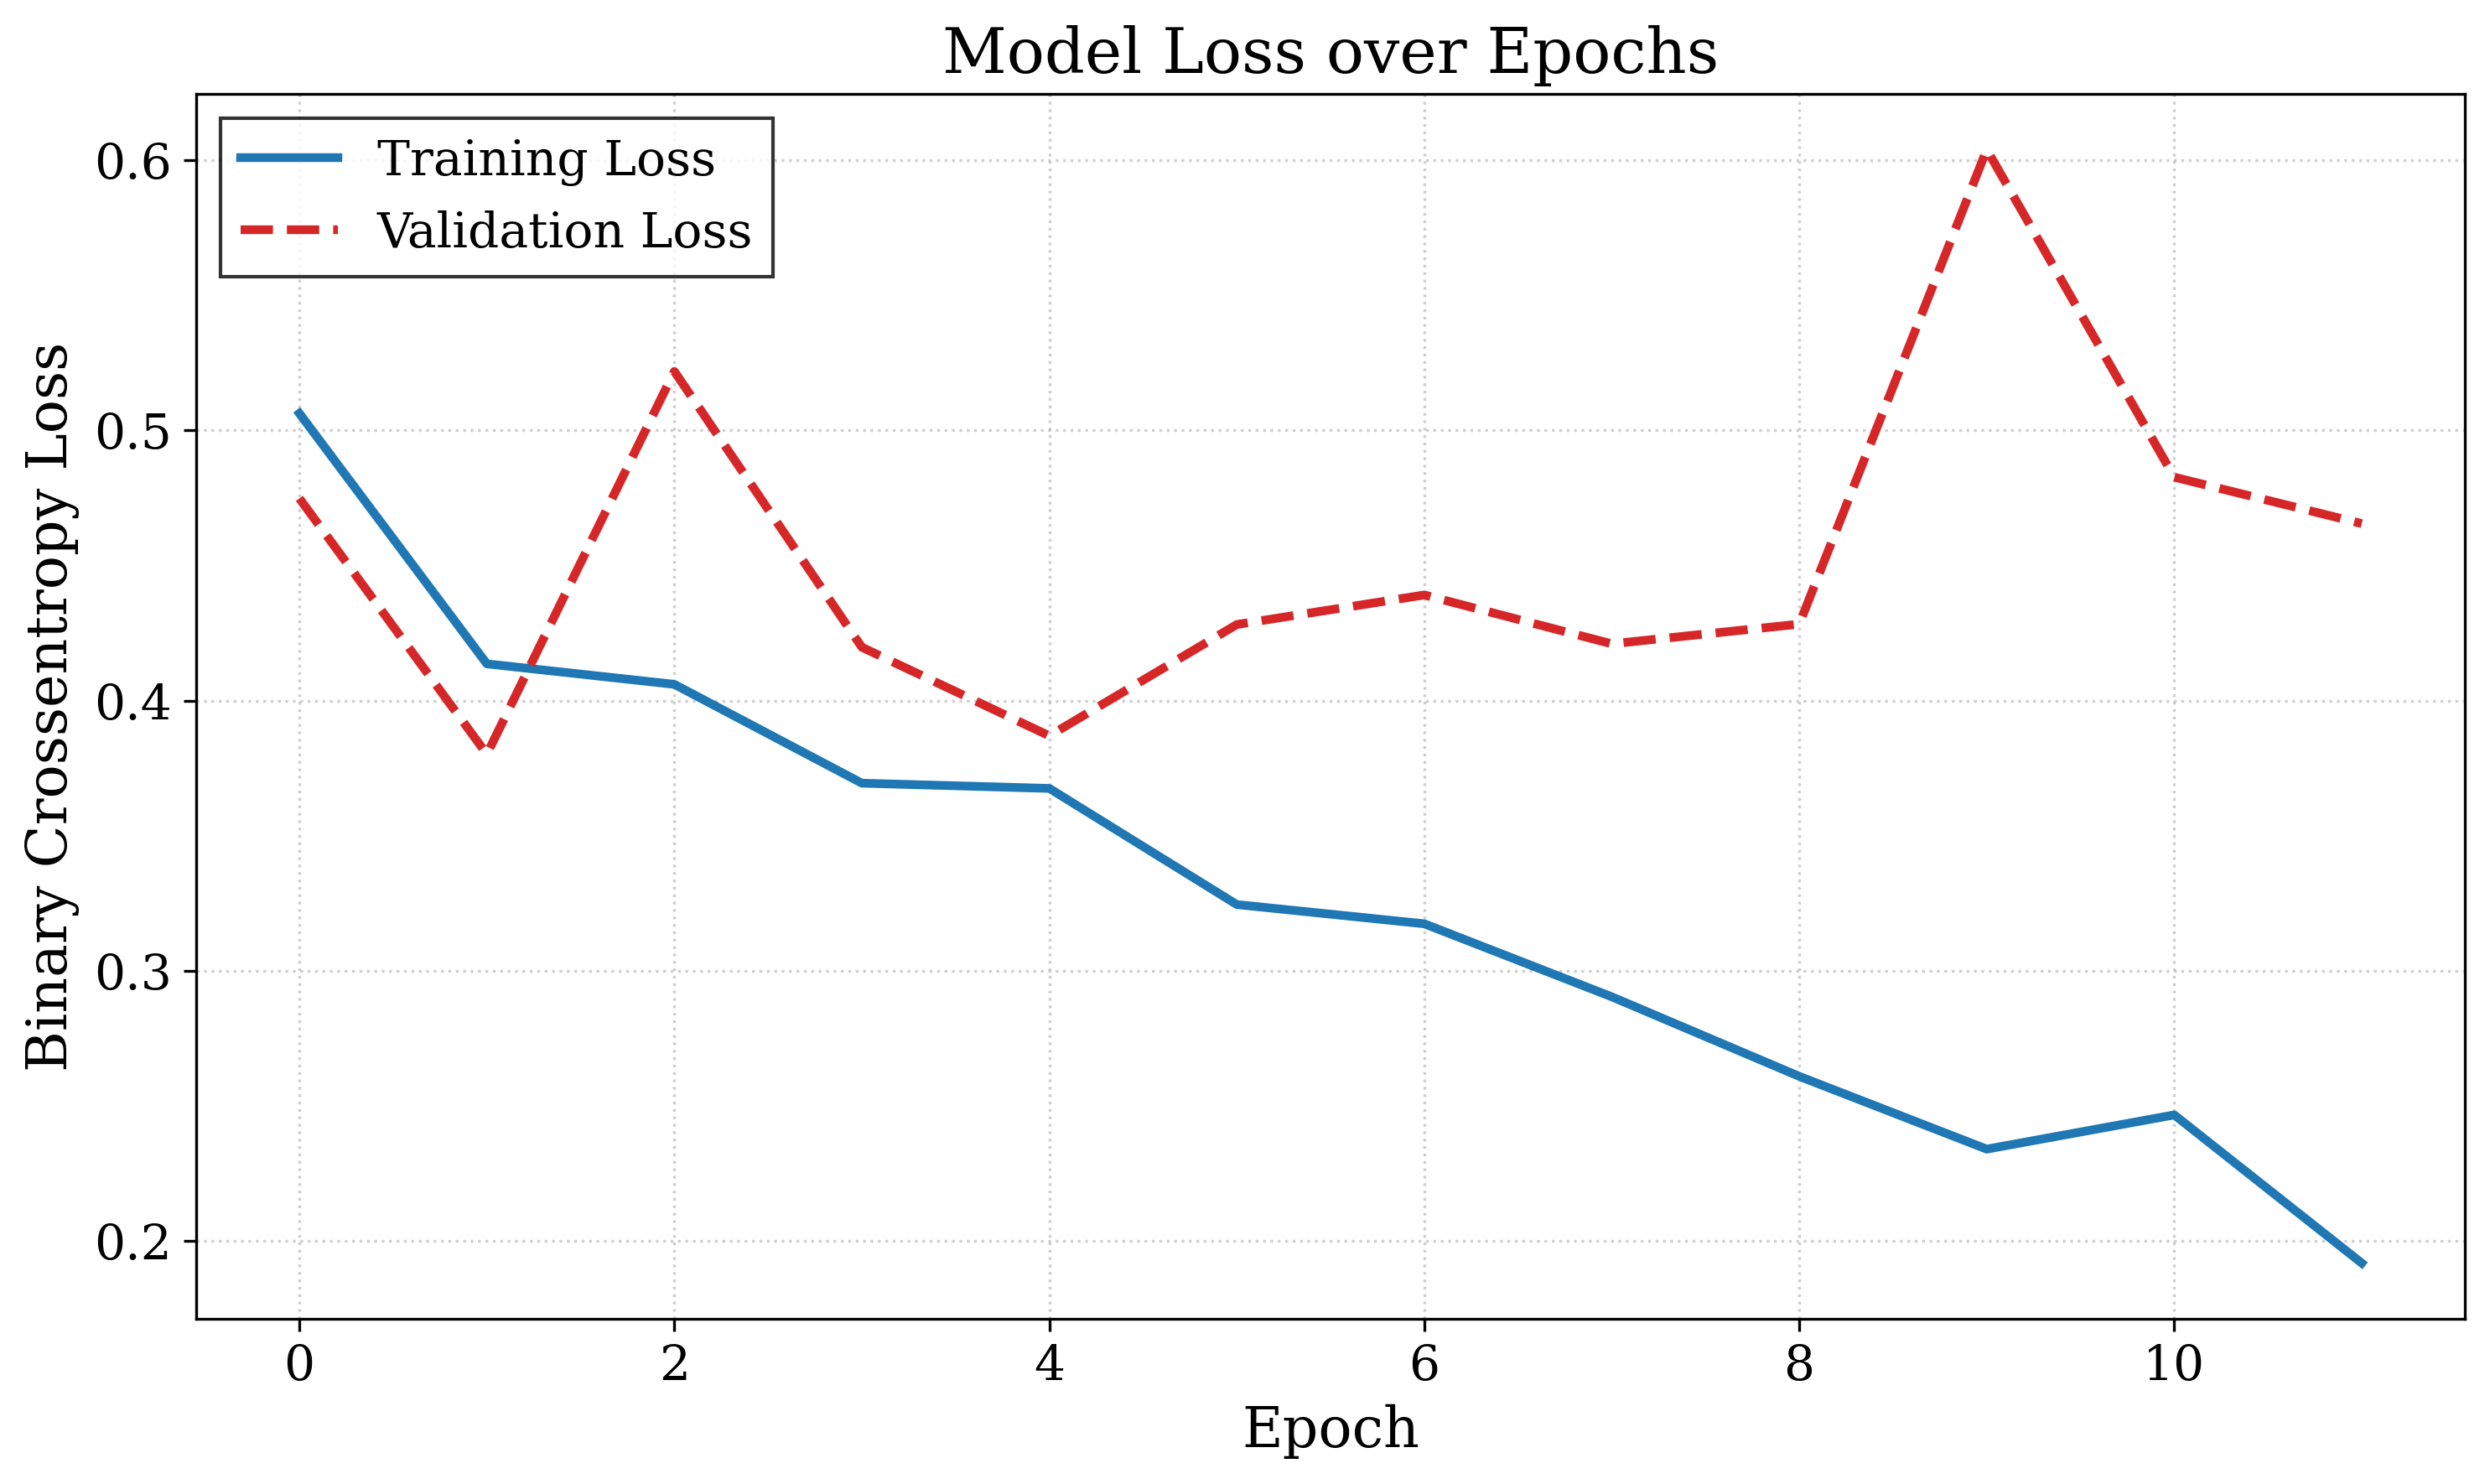

Saved: output/plot_loss_tuned_weighted.png


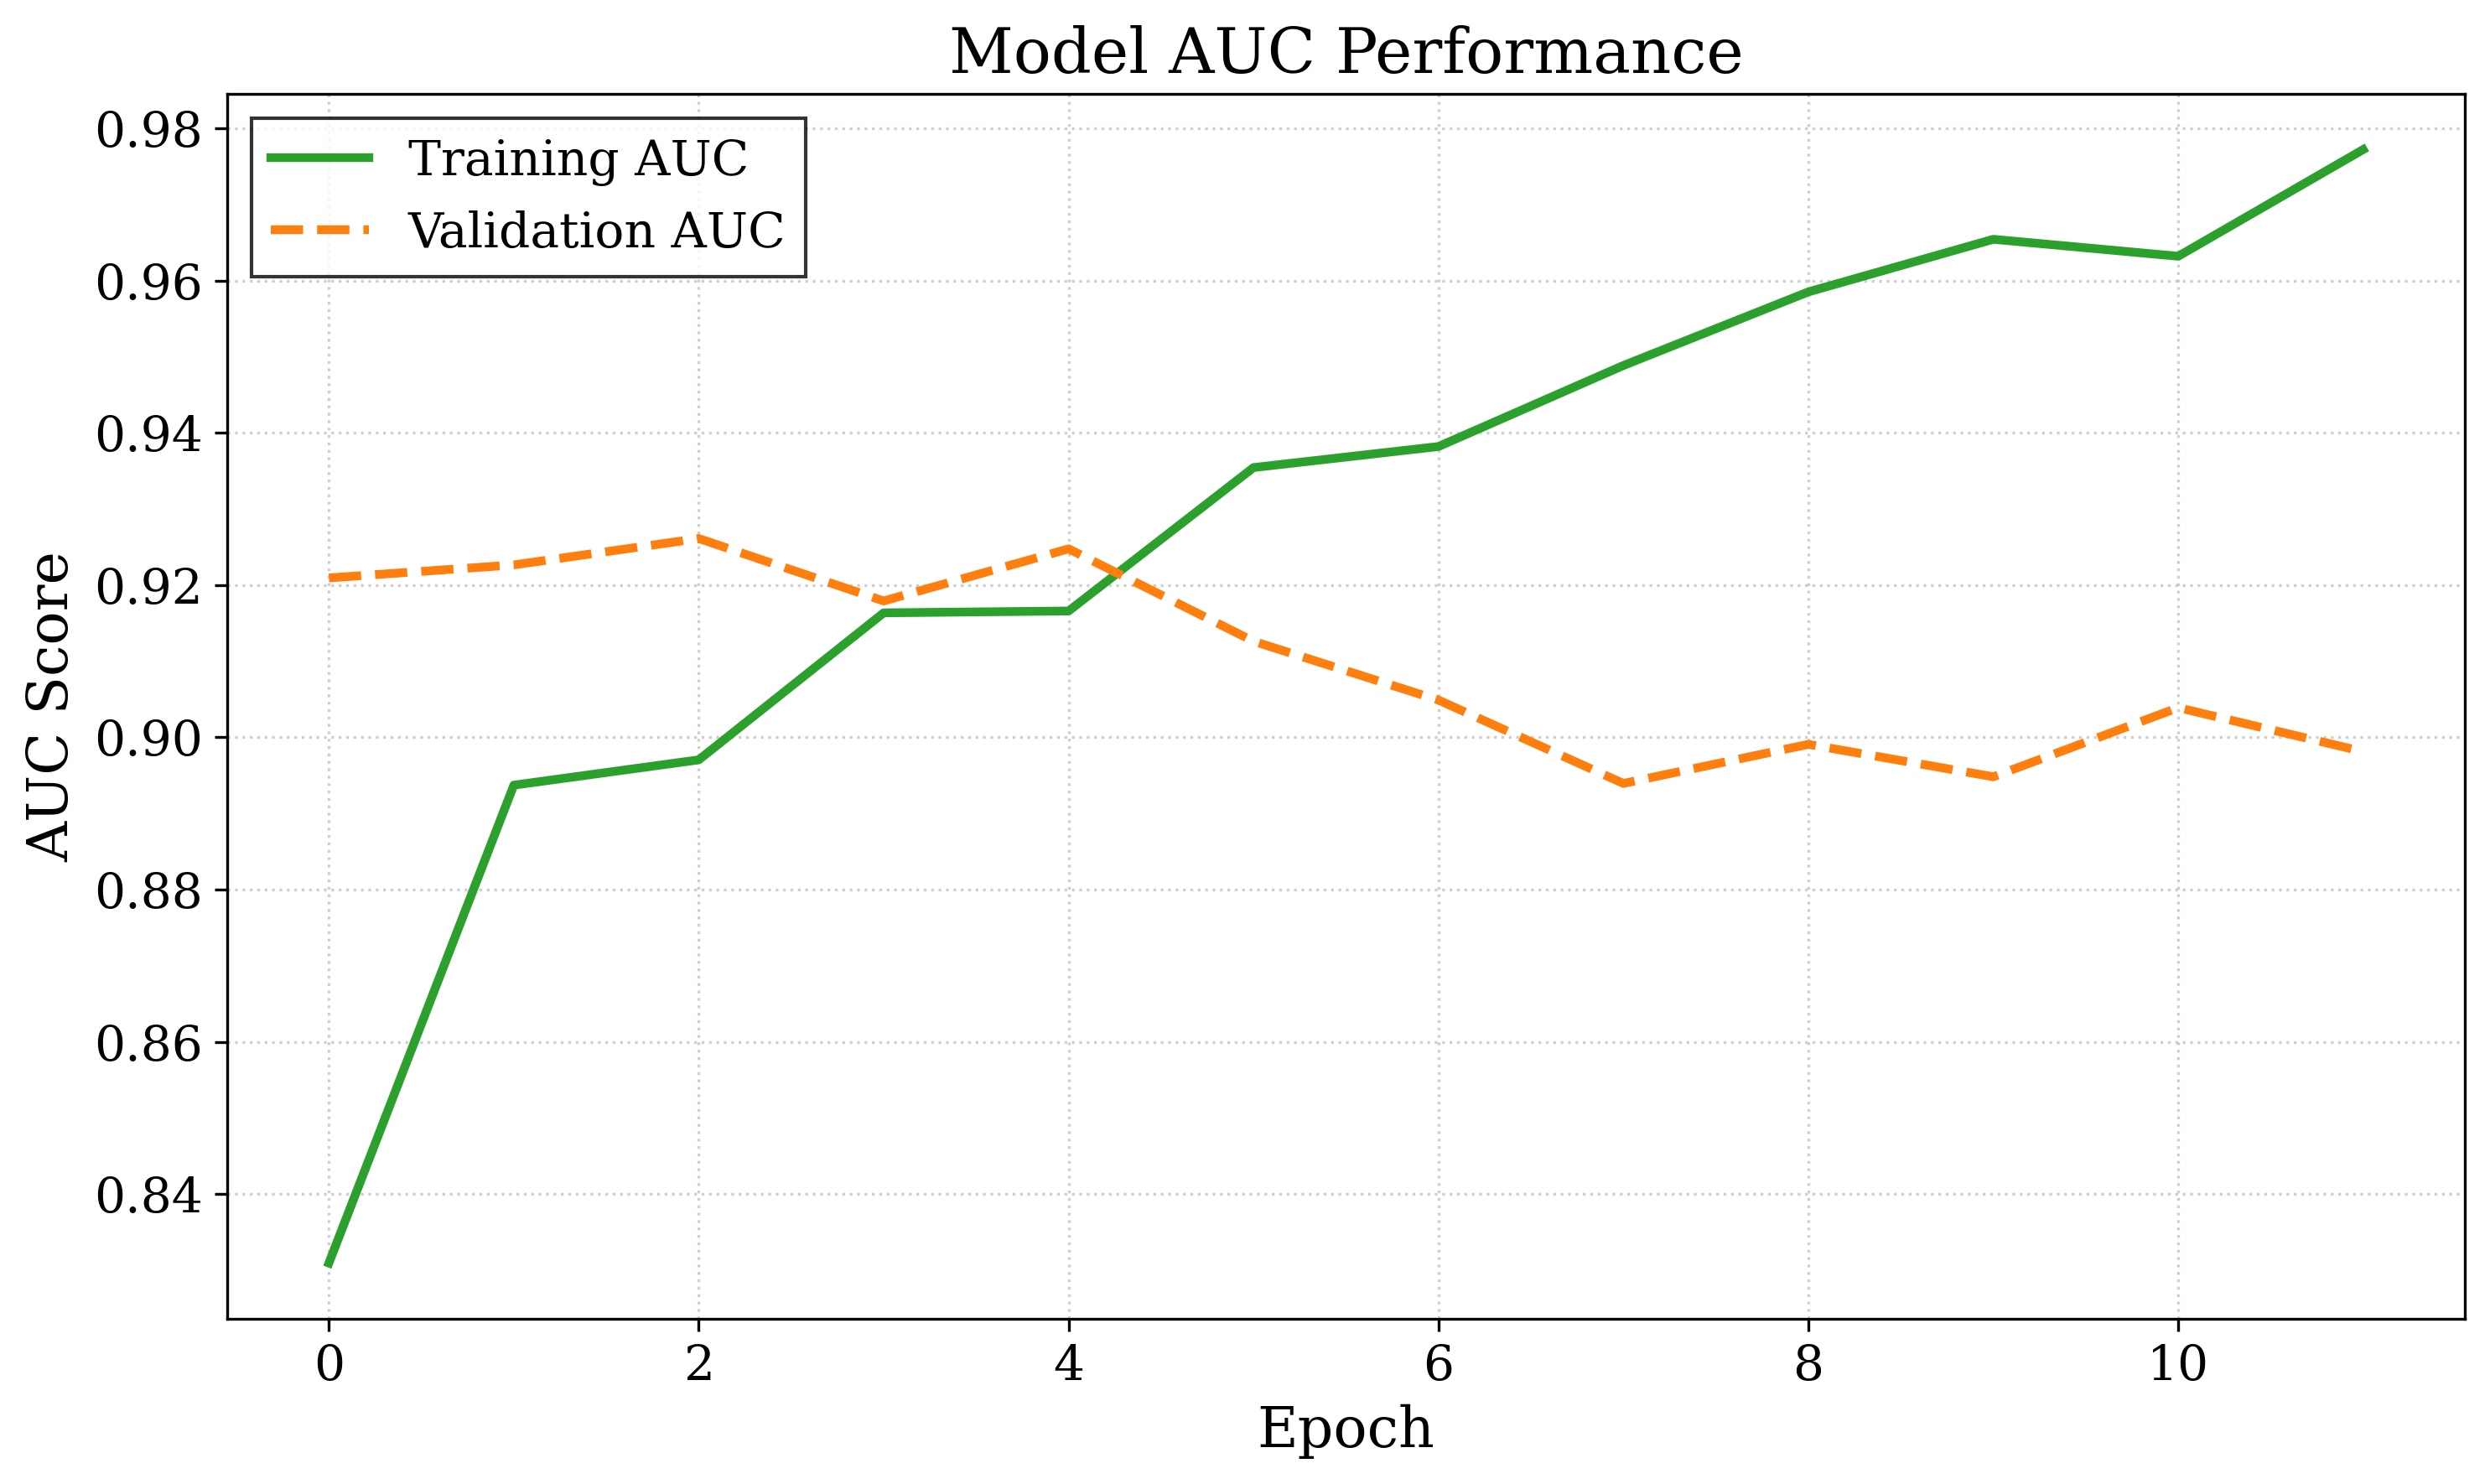

Saved: output/plot_auc_tuned_weighted.png


In [ ]:
def train_final_model(x_train, y_train, x_val, y_val,
                      input_shape,
                      use_class_weight=False,
                      best_hps=None,
                      epochs=50,
                      batch_size=32,
                      patience=10,
                      checkpoint_path_template='output/model_{}.keras',
                      model_name='baseline'):

    print(f"\n--- Training Final Model: {model_name} ---")

    # 1. Build Model
    # We assume build_lstm_model is available from Step 7
    if 'build_lstm_model' not in globals():
        raise NameError("build_lstm_model function not defined. Please run Step 7.")

    model = build_lstm_model(input_shape, hp=best_hps)
    if model is None:
        return None, None

    # 2. Calculate Class Weights (Critical for Blooms)
    class_weights_dict = None
    if use_class_weight:
        print("Calculating class weights for imbalanced data...")
        try:
            # Flatten to ensure 1D array for weight calculation
            y_flat = y_train.flatten().astype(int)
            classes = np.unique(y_flat)
            weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_flat)
            class_weights_dict = dict(zip(classes, weights))
            print(f"  Class weights: {class_weights_dict}")
        except Exception as e:
            print(f"  Error calculating weights: {e}. Using default.")

    # 3. Compile Model with BETTER METRICS
    # We add AUC, Precision, and Recall to see if it actually finds blooms
    learning_rate = best_hps.get('learning_rate') if best_hps else DEFAULT_LEARNING_RATE

    # Re-compile to ensure metrics and optimizer are fresh
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[
            BinaryAccuracy(name='accuracy'),
            AUC(name='auc'),           # <--- Critical for Imbalanced Data
            Precision(name='precision'),
            Recall(name='recall')
        ]
    )
    print(f"Model compiled (LR={learning_rate}). Monitoring AUC/Precision/Recall.")

    # 4. Setup Callbacks
    model_path = checkpoint_path_template.format(model_name)

    # EarlyStopping: restore_best_weights=True ensures 'model' var is perfect at the end
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        verbose=1,
        restore_best_weights=True
    )

    model_checkpoint = ModelCheckpoint(
        filepath=model_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    # 5. Train
    print(f"\nStarting training for {epochs} epochs...")

    # Ensure raw numpy arrays (safer than Tensors here)
    x_train = np.array(x_train).astype('float32')
    y_train = np.array(y_train).astype('float32')
    x_val = np.array(x_val).astype('float32')
    y_val = np.array(y_val).astype('float32')

    history = model.fit(
        x_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping, model_checkpoint],
        class_weight=class_weights_dict,
        verbose=1
    )

    print(f"\n--- Training Finished. Best model saved to {model_path} ---")

    # Because restore_best_weights=True, 'model' is already the best version.
    return model, history


# --- Execute Training ---
if __name__ == "__main__":
    try:
        # Check prerequisites
        if 'X_train' not in locals(): raise NameError("Run Step 6 (Sequence Creation) first.")

        # Define Input Shape
        input_shape_train = (X_train.shape[1], X_train.shape[2])

        # Naming logic
        model_name = "tuned" if (PERFORM_TUNING and best_hps) else "baseline"
        if USE_CLASS_WEIGHT: model_name += "_weighted"

        # TRAIN
        trained_model, training_history = train_final_model(
            X_train, y_train, X_val, y_val,
            input_shape=input_shape_train,
            use_class_weight=USE_CLASS_WEIGHT,
            best_hps=best_hps if PERFORM_TUNING else None,
            epochs=TRAIN_EPOCHS,
            batch_size=TRAIN_BATCH_SIZE,
            patience=TRAIN_PATIENCE,
            checkpoint_path_template=MODEL_CHECKPOINT_TEMPLATE,
            model_name=model_name
        )

        if trained_model:
            # --- PUBLICATION QUALITY PLOTTING ---
            print(f"\nGeneratng publication-quality plots for {model_name}...")

            import matplotlib.pyplot as plt
            import os  # <--- Need this to create folders

            # 1. CRITICAL FIX: Create the output directory if it doesn't exist
            os.makedirs('output', exist_ok=True)

            # 2. Global Style Settings for Academic Papers
            plt.rcdefaults()
            params = {
                'font.family': 'serif',
                'axes.titlesize': 18,
                'axes.labelsize': 16,
                'xtick.labelsize': 14,
                'ytick.labelsize': 14,
                'legend.fontsize': 14,
                'figure.figsize': (10, 6),
                'lines.linewidth': 2.5
            }
            plt.rcParams.update(params)

            # --- FIGURE 1: LOSS CURVE ---
            plt.figure(dpi=300)

            plt.plot(training_history.history['loss'], label='Training Loss', color='#1f77b4', linestyle='-')
            plt.plot(training_history.history['val_loss'], label='Validation Loss', color='#d62728', linestyle='--')

            plt.title('Model Loss over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel('Binary Crossentropy Loss')
            plt.legend(frameon=True, fancybox=False, edgecolor='black')
            plt.grid(True, linestyle=':', alpha=0.6)
            plt.tight_layout()

            # Save safely now that folder exists
            plt.savefig(f"output/plot_loss_{model_name}.png", bbox_inches='tight')
            plt.show()
            print(f"Saved: output/plot_loss_{model_name}.png")

            # --- FIGURE 2: AUC / PERFORMANCE CURVE ---
            plt.figure(dpi=300)

            if 'val_auc' in training_history.history:
                metric_name = 'AUC'
                train_data = training_history.history['auc']
                val_data = training_history.history['val_auc']
                color_train = '#2ca02c'
                color_val = '#ff7f0e'
            else:
                metric_name = 'Accuracy'
                train_data = training_history.history['accuracy']
                val_data = training_history.history['val_accuracy']
                color_train = 'black'
                color_val = 'gray'

            plt.plot(train_data, label=f'Training {metric_name}', color=color_train, linestyle='-')
            plt.plot(val_data, label=f'Validation {metric_name}', color=color_val, linestyle='--')

            plt.title(f'Model {metric_name} Performance')
            plt.xlabel('Epoch')
            plt.ylabel(f'{metric_name} Score')
            plt.legend(frameon=True, fancybox=False, edgecolor='black')
            plt.grid(True, linestyle=':', alpha=0.6)
            plt.tight_layout()

            plt.savefig(f"output/plot_{metric_name.lower()}_{model_name}.png", bbox_inches='tight')
            plt.show()
            print(f"Saved: output/plot_{metric_name.lower()}_{model_name}.png")

            model_ready_for_eval = True
        else:
            model_ready_for_eval = False

    except Exception as e:
         print(f"Error: {e}")
         model_ready_for_eval = False

## Part 10: Baseline Evaluation

This cell defines the evaluation function and applies it to the model trained in Part 9 (trained_model). It calculates and prints various classification metrics, plots the confusion matrix and predictions over time, and assesses the model's ability to predict bloom onsets.

Explanation:

1. Function evaluate_model:
    - Takes the model object, test data (x_test, y_test), the unscaled test dataframe test_df_unscaled (needed for correct timestamps), sequence length, forecast horizon, and a model_name string as input.
    - Predictions: Runs model.predict(x_test) to get probabilities. Converts probabilities to class predictions using a 0.5 threshold.
    - Metrics Calculation: Uses scikit-learn functions to calculate accuracy, precision, recall, F1-score (for the positive class '1'), AUC-ROC (using probabilities), and Brier score (using probabilities). Includes error handling for AUC calculation if only one class is present in y_test.
    - Reporting: Prints a formatted summary of the metrics and the full classification report.\
    - Confusion Matrix: Calculates and plots the confusion matrix using seaborn for better visualization.
    - Time Series Plot: Determines the correct start index in the test_df_unscaled index based on sequence length and forecast horizon to align the predictions (y_pred_prob) with the actual dates. Plots actuals vs. predicted probabilities. Includes checks for length mismatches.
    - Onset Analysis: Implements the logic to find actual bloom onsets (0 -> 1 transitions in y_test) and checks if the model predicted a bloom (class 1) either in the week before the onset or during the onset week. Reports the hit rate.
2. Main Execution:
    - Checks if the necessary variables (trained_model, X_test, y_test, test_df, etc.) exist from previous steps.
    - Calls the evaluate_model function, passing the required arguments. Uses the model_type_trained variable (set at the end of Part 9) to label the output correctly.

After running this cell, you will have a comprehensive evaluation of the model trained in Part 9, including standard metrics, plots, and the crucial bloom onset performance assessment. This provides the baseline against which the EnKF-enhanced model (Part 12/13) will be compared.      


=== Evaluating Model: LSTM_Baseline ===
1. Generating predictions...

Optimal Decision Threshold: 0.7803 (Max F1: 0.8662)

2. Performance Metrics (at Optimal Threshold):
  Accuracy:    0.9087
  Precision:   0.8395
  Recall:      0.8947
  F1-Score:    0.8662
  AUC-ROC:     0.9532
  Brier Score: 0.1238

Classification Report:
              precision    recall  f1-score   support

    No Bloom       0.95      0.92      0.93       154
       Bloom       0.84      0.89      0.87        76

    accuracy                           0.91       230
   macro avg       0.89      0.91      0.90       230
weighted avg       0.91      0.91      0.91       230

Saved: output/confusion_matrix_LSTM_Baseline.png


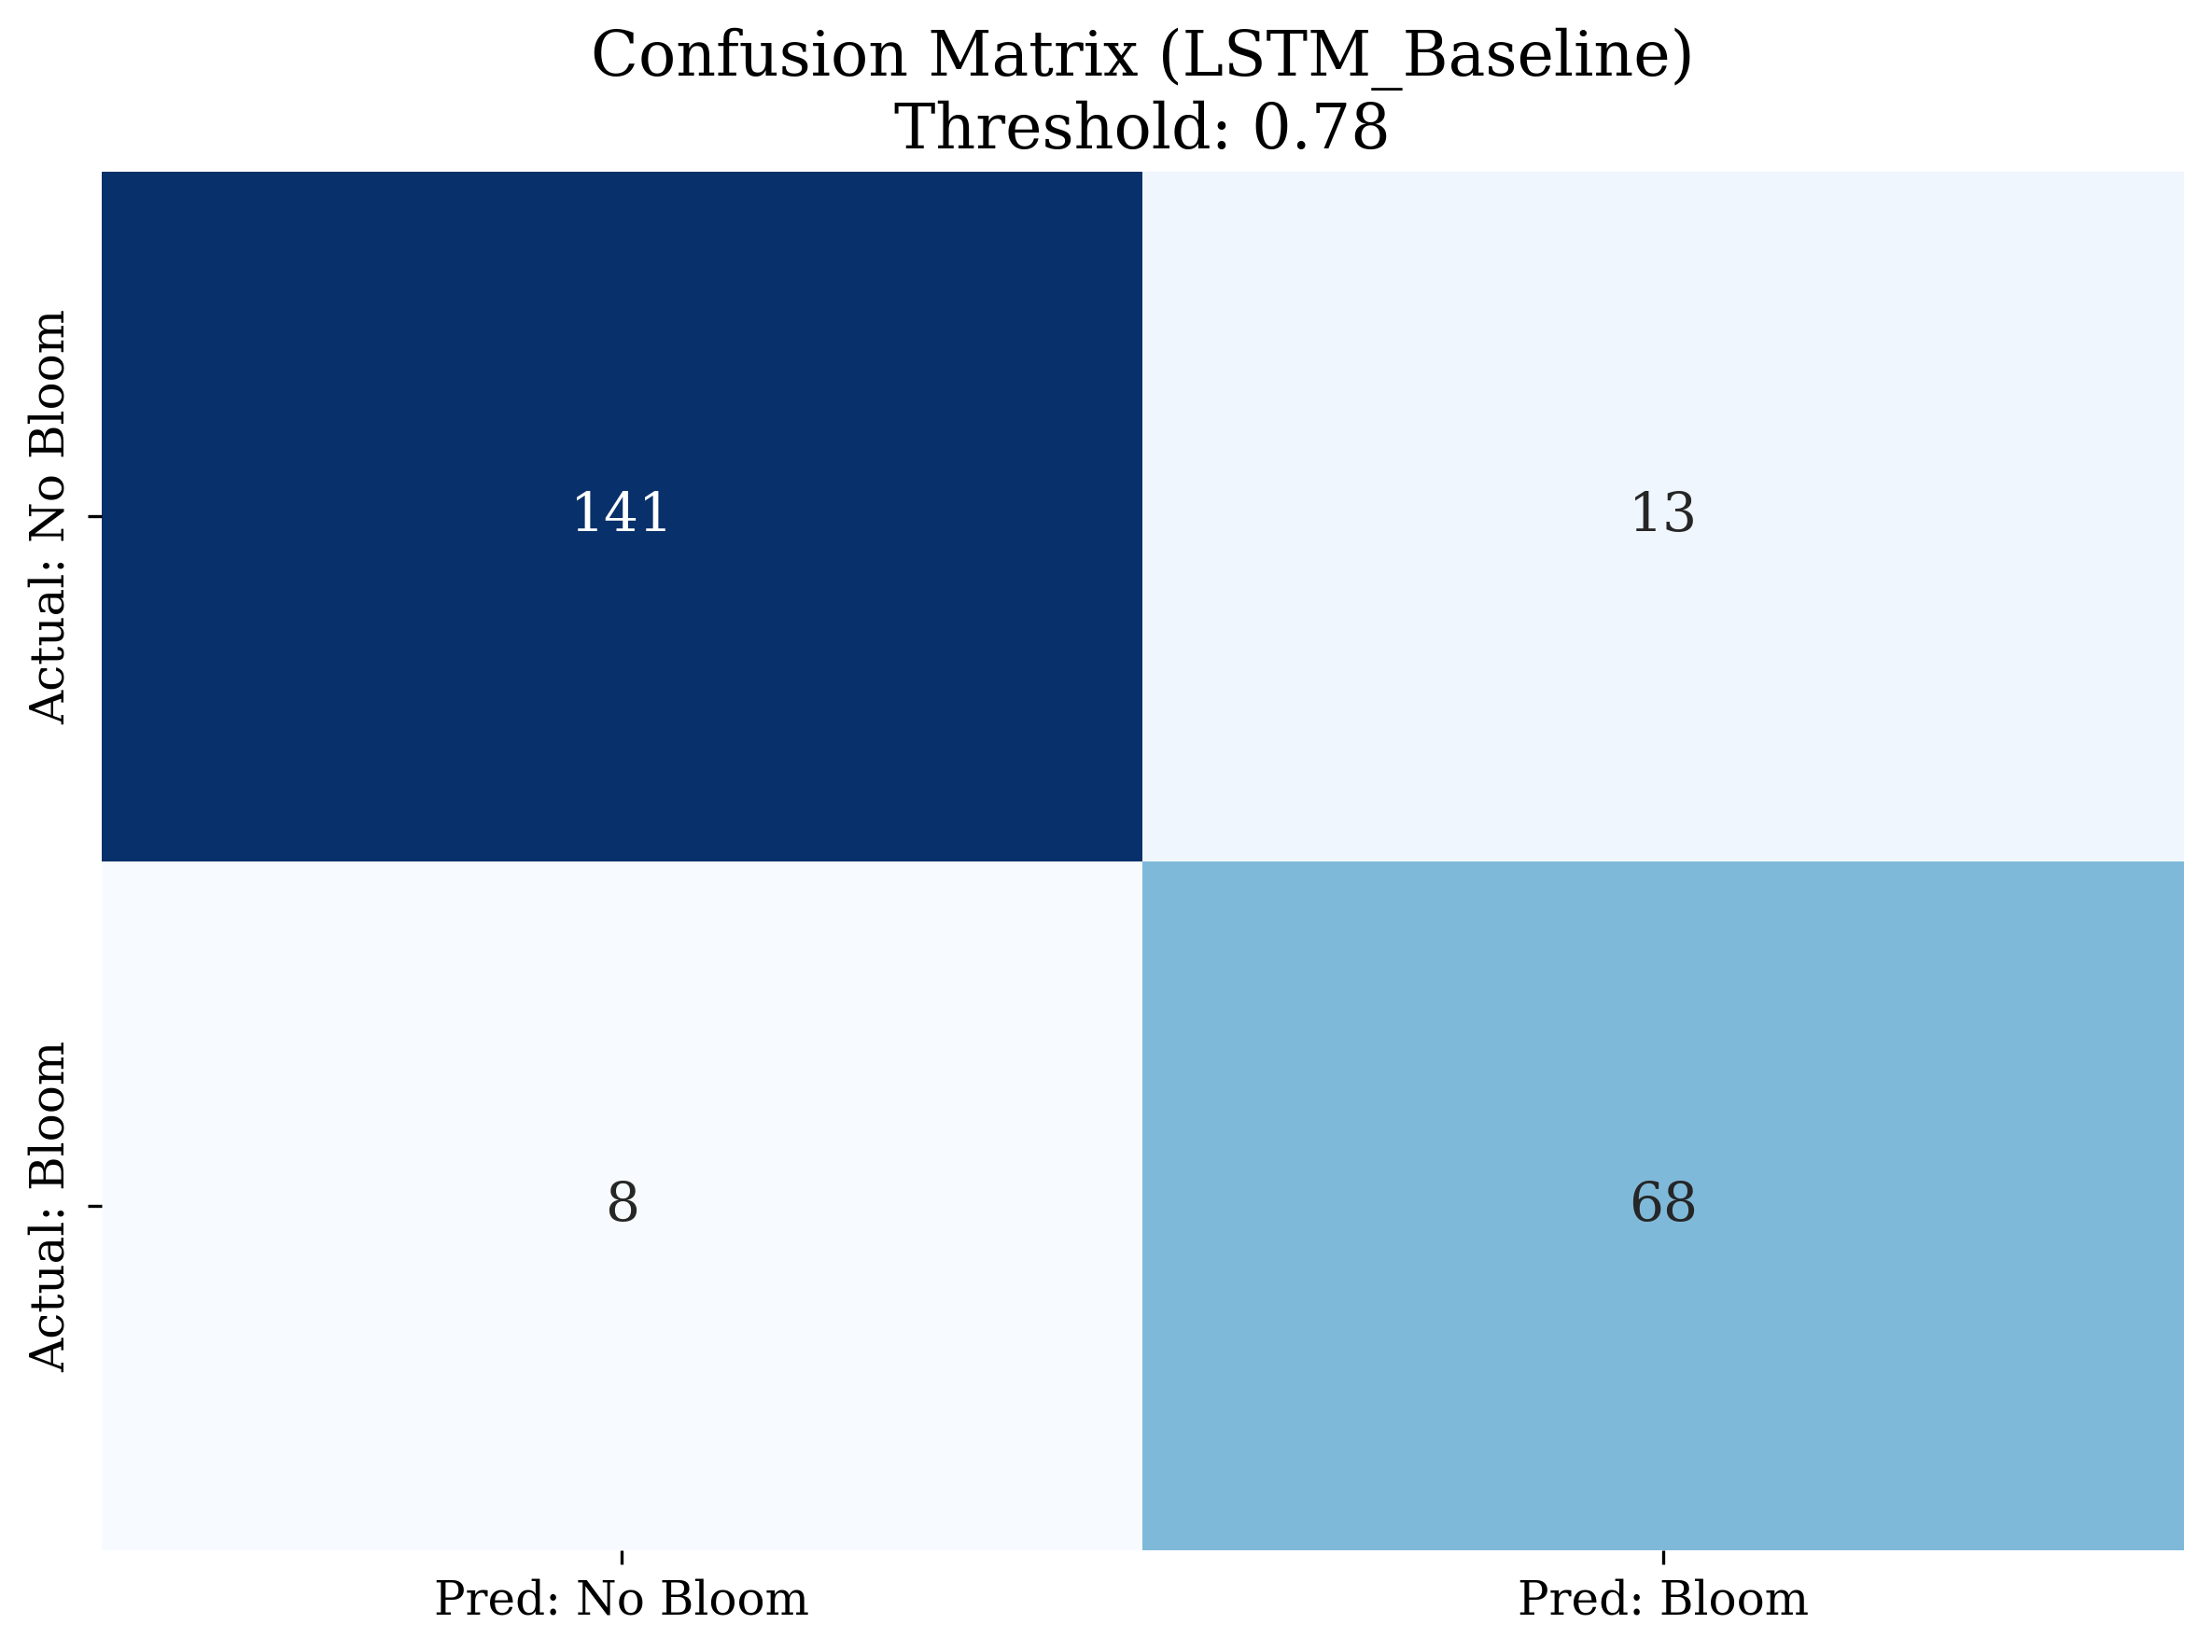


3. Plotting Time Series Predictions...
Saved: output/timeseries_preds_LSTM_Baseline.png


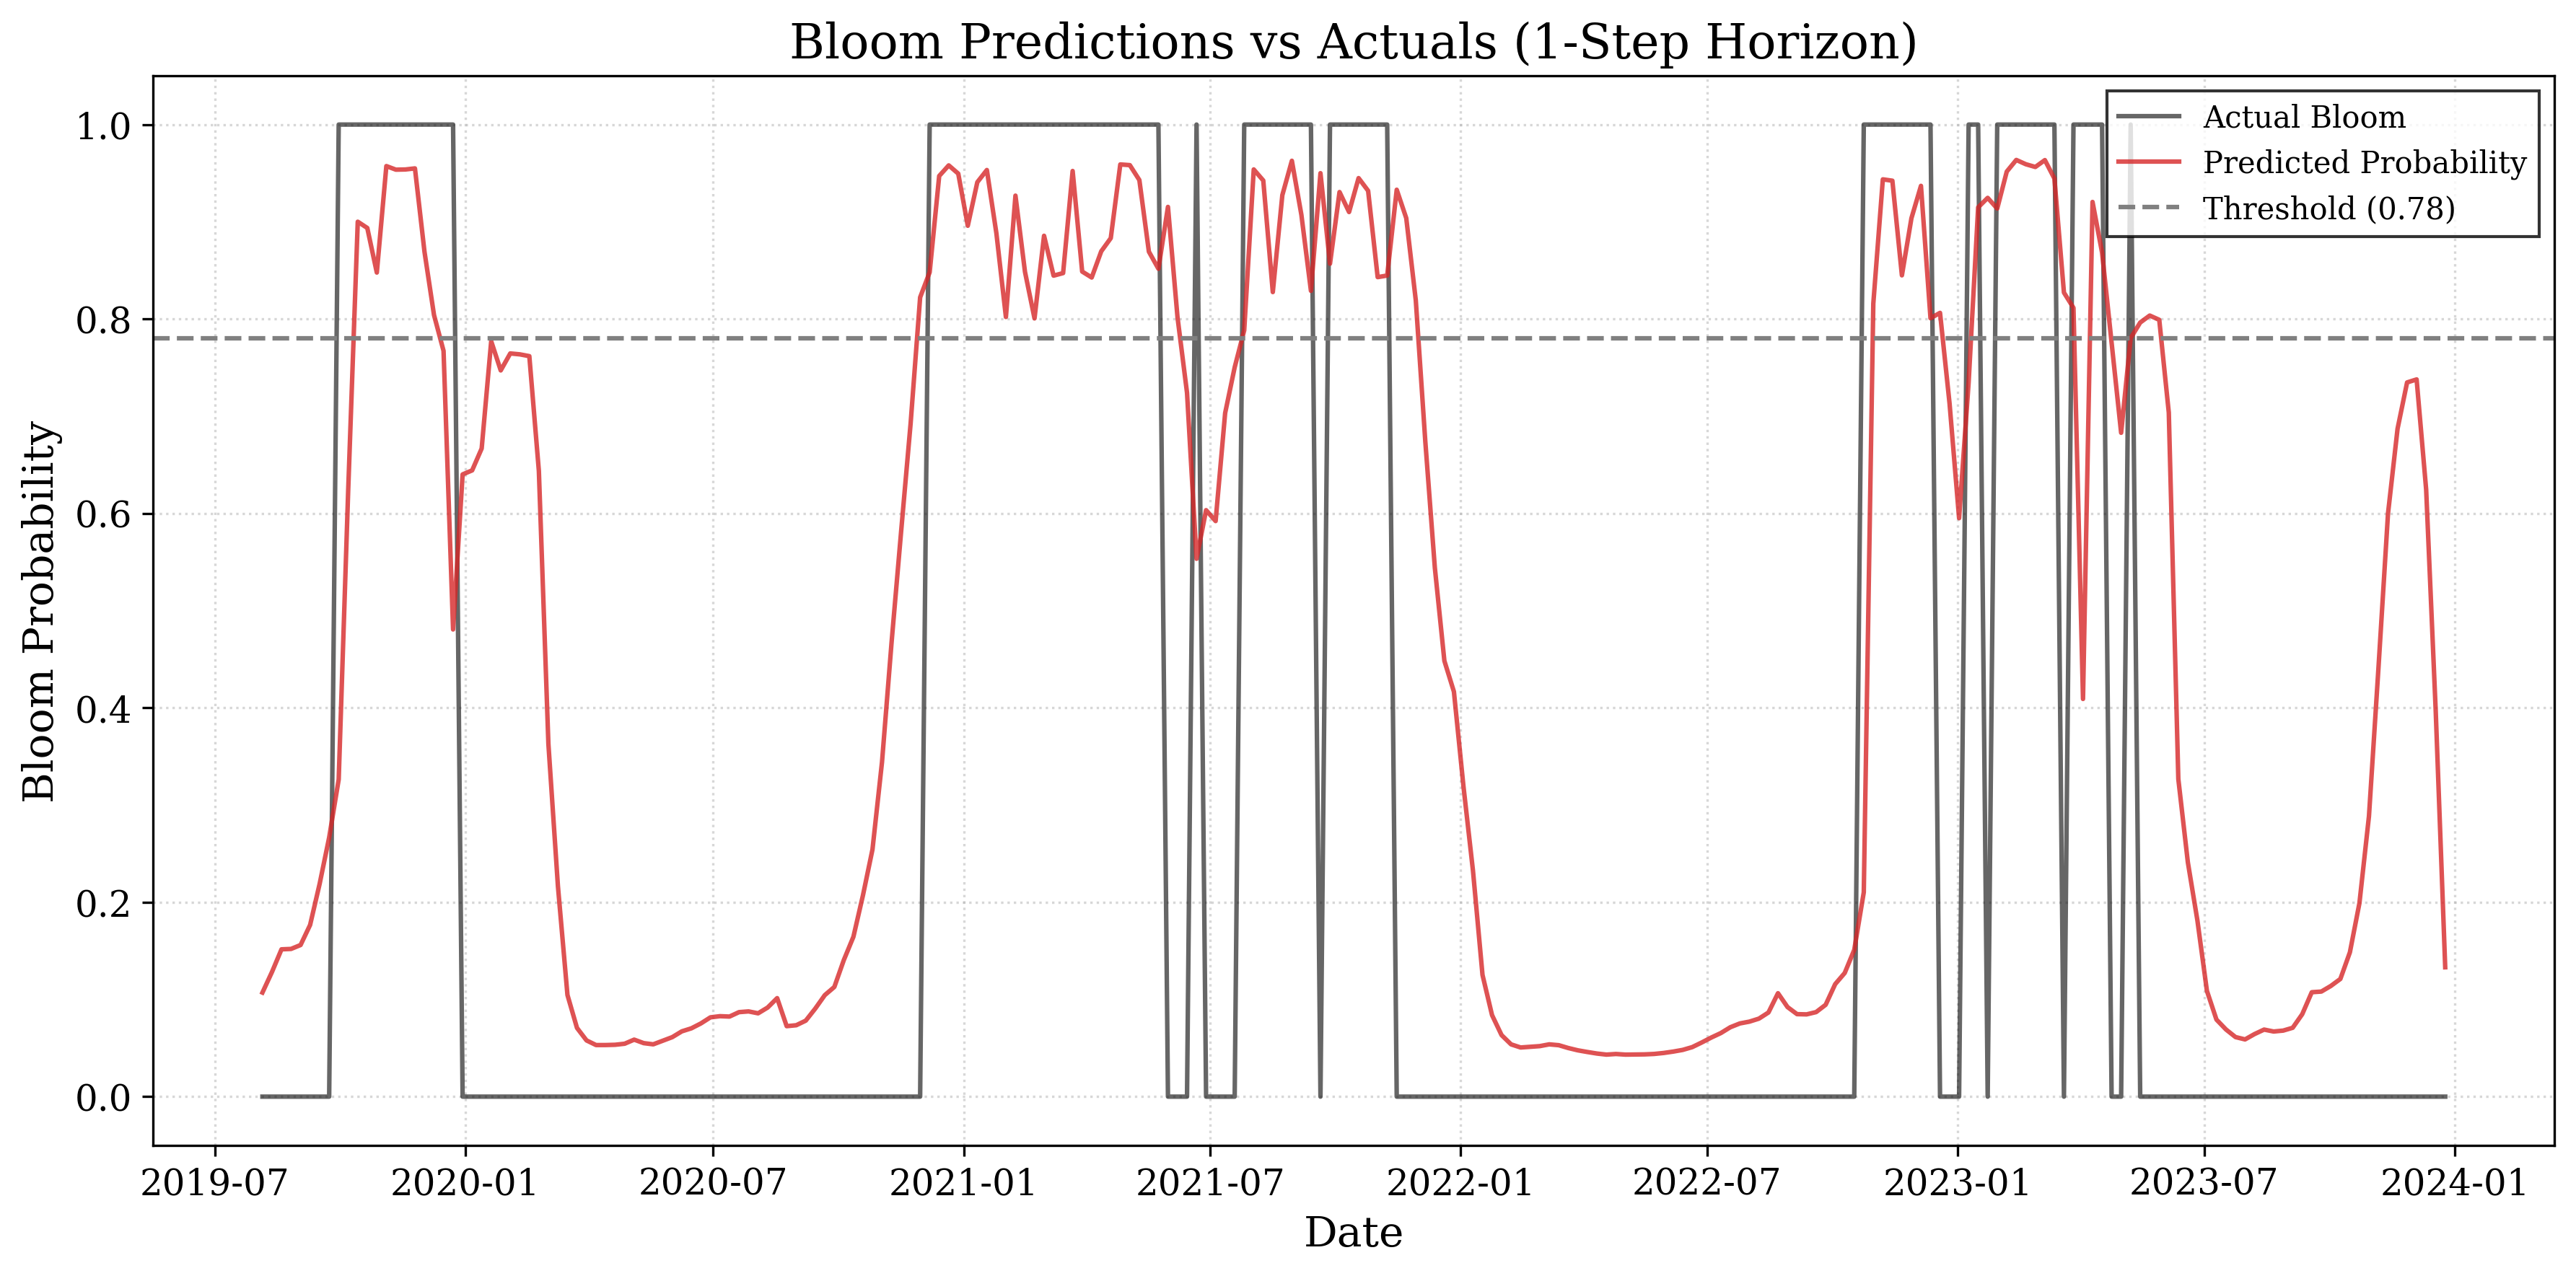


4. Bloom Onset Analysis (Did we catch the start?)
  Total Onsets: 10
  Caught Early/On-Time: 6 (60.0%)
  Caught 1-Week Late:   2
  Missed Completely:    2


In [ ]:
def evaluate_model(model, x_test, y_test, test_df_unscaled,
                   seq_len, forecast_horizon, model_name="Model"):
    """
    Evaluates model with Optimal Threshold detection and Publication Plots.
    Saves figures to 'output/' folder.
    """
    if model is None or x_test is None or y_test is None:
        print("Error: Missing model or test data.")
        return

    # Ensure output directory exists
    os.makedirs('output', exist_ok=True)

    print(f"\n=== Evaluating Model: {model_name} ===")

    # 1. Generate Probabilities
    print("1. Generating predictions...")
    try:
        # Get raw probabilities (0.0 to 1.0)
        y_pred_prob = model.predict(x_test, verbose=0)
        y_test_eval = y_test.reshape(-1, 1) # Ensure 2D shape
    except Exception as e:
        print(f"Error during prediction: {e}")
        return

    # 2. Find Optimal Threshold (Fixed Math)
    # ------------------------------------------------------
    precision, recall, thresholds = precision_recall_curve(y_test_eval, y_pred_prob)

    # Calculate F-Score safely (avoid 0/0 division)
    numerator = 2 * precision * recall
    denominator = precision + recall
    with np.errstate(divide='ignore', invalid='ignore'):
        fscore = np.divide(numerator, denominator)
    fscore = np.nan_to_num(fscore) # Replace NaNs with 0

    # Locate the index of the largest F score
    ix = np.argmax(fscore)

    # Safety check for index bounds
    if ix >= len(thresholds):
        best_thresh = thresholds[-1]
    else:
        best_thresh = thresholds[ix]

    print(f"\nOptimal Decision Threshold: {best_thresh:.4f} (Max F1: {fscore[ix]:.4f})")
    # ------------------------------------------------------

    # Apply Best Threshold
    y_pred_class = (y_pred_prob >= best_thresh).astype(int)

    # 3. Calculate Metrics (at Best Threshold)
    print("\n2. Performance Metrics (at Optimal Threshold):")
    try:
        acc = accuracy_score(y_test_eval, y_pred_class)
        prec = precision_score(y_test_eval, y_pred_class, zero_division=0)
        rec = recall_score(y_test_eval, y_pred_class, zero_division=0)
        f1 = f1_score(y_test_eval, y_pred_class, zero_division=0)
        auc = roc_auc_score(y_test_eval, y_pred_prob)
        brier = brier_score_loss(y_test_eval, y_pred_prob)

        print(f"  Accuracy:    {acc:.4f}")
        print(f"  Precision:   {prec:.4f}")
        print(f"  Recall:      {rec:.4f}")
        print(f"  F1-Score:    {f1:.4f}")
        print(f"  AUC-ROC:     {auc:.4f}")
        print(f"  Brier Score: {brier:.4f}")

        print(f"\nClassification Report:\n{classification_report(y_test_eval, y_pred_class, target_names=['No Bloom', 'Bloom'])}")

    except Exception as e:
        print(f"Metric calculation error: {e}")

    # 4. Publication-Quality Plots
    # ----------------------------
    # Apply Academic Style
    plt.rcdefaults()
    params = {'font.family': 'serif', 'figure.figsize': (8, 6), 'figure.dpi': 300,
              'axes.labelsize': 14, 'axes.titlesize': 16, 'xtick.labelsize': 12, 'ytick.labelsize': 12}
    plt.rcParams.update(params)

    # --- Plot A: Confusion Matrix ---
    try:
        cm = confusion_matrix(y_test_eval, y_pred_class)
        plt.figure()
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Pred: No Bloom', 'Pred: Bloom'],
                    yticklabels=['Actual: No Bloom', 'Actual: Bloom'],
                    annot_kws={"size": 14})
        plt.title(f'Confusion Matrix ({model_name})\nThreshold: {best_thresh:.2f}')
        plt.tight_layout()

        # SAVE FIGURE
        save_path = f"output/confusion_matrix_{model_name}.png"
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved: {save_path}")
        plt.show()
    except Exception as e:
        print(f"CM Plot Error: {e}")

    # --- Plot B: Time Series Predictions ---
    print(f"\n3. Plotting Time Series Predictions...")
    start_idx = seq_len + forecast_horizon - 1
    num_preds = len(y_pred_prob)

    if start_idx + num_preds <= len(test_df_unscaled):
        dates = test_df_unscaled.index[start_idx : start_idx + num_preds]

        plt.figure(figsize=(12, 6))
        # Plot Actuals (Black Line)
        plt.plot(dates, y_test_eval[:num_preds], label='Actual Bloom', color='black', alpha=0.6, linewidth=1.5)
        # Plot Probabilities (Red Line)
        plt.plot(dates, y_pred_prob[:num_preds], label='Predicted Probability', color='#d62728', alpha=0.8, linewidth=1.5)
        # Threshold Line
        plt.axhline(best_thresh, color='gray', linestyle='--', label=f'Threshold ({best_thresh:.2f})')

        plt.title(f'Bloom Predictions vs Actuals ({forecast_horizon}-Step Horizon)')
        plt.ylabel('Bloom Probability')
        plt.xlabel('Date')
        plt.legend(frameon=True, fancybox=False, edgecolor='black', loc='upper right')
        plt.grid(True, linestyle=':', alpha=0.5)
        plt.tight_layout()

        # SAVE FIGURE
        save_path = f"output/timeseries_preds_{model_name}.png"
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved: {save_path}")
        plt.show()
    else:
        print("Warning: Could not align dates for plotting.")

    # 5. Bloom Onset Analysis (Custom Logic)
    print(f"\n4. Bloom Onset Analysis (Did we catch the start?)")
    y_test_flat = y_test_eval.flatten()
    y_pred_flat = y_pred_class.flatten()

    onsets = np.where((y_test_flat[:-1] == 0) & (y_test_flat[1:] == 1))[0] + 1
    total_onsets = len(onsets)

    hits = 0
    late_hits = 0

    if total_onsets > 0:
        for idx in onsets:
            # Check window: [Week Before, Week Of, Week After]
            pred_before = y_pred_flat[idx-1] if idx > 0 else 0
            pred_on     = y_pred_flat[idx]
            pred_after  = y_pred_flat[idx+1] if idx+1 < len(y_pred_flat) else 0

            if pred_before == 1 or pred_on == 1:
                hits += 1 # Success (Early or On Time)
            elif pred_after == 1:
                late_hits += 1 # Late by 1 week

        print(f"  Total Onsets: {total_onsets}")
        print(f"  Caught Early/On-Time: {hits} ({hits/total_onsets:.1%})")
        print(f"  Caught 1-Week Late:   {late_hits}")
        print(f"  Missed Completely:    {total_onsets - hits - late_hits}")
    else:
        print("  No bloom onsets found in Test Data.")

# --- Main Execution ---
if __name__ == "__main__":
    if 'trained_model' in locals() and 'X_test' in locals():
        # Ensure data is numpy float32
        X_test = np.array(X_test, dtype='float32')
        y_test = np.array(y_test, dtype='float32')

        evaluate_model(
            model=trained_model,
            x_test=X_test,
            y_test=y_test,
            test_df_unscaled=test_df, # Must be defined in Step 4
            seq_len=SEQUENCE_LENGTH,
            forecast_horizon=FORECAST_HORIZON,
            model_name="LSTM_Baseline"
        )
    else:
        print("Error: Prerequisites (trained_model, X_test) not found.")

## Part 11: EnKF Setup

This cell defines the EnsembleKalmanFilter class (assuming it's not in a separate enkf.py file for simplicity here, but importing is better practice) and a function setup_enkf to initialize the filter for the test period. It calculates the initial state, noise matrices (based on the ENKF_NOISE_ESTIMATION setting from Part 1), and identifies the necessary column indices.

Explanation:

1. EnKF Class: Includes the EnsembleKalmanFilter class definition directly in the cell for convenience (assuming it's not imported from enkf.py).

2. setup_enkf Function:

    - Takes necessary configurations and dataframes as input.
    - Initial State/Covariance: Extracts the state vector values (x_initial) from the unscaled test_df at the correct time index (end of the first sequence's lookback period). Calculates an initial covariance matrix P_initial based on relative uncertainty assumptions (these ratios are tunable).
    - Noise Matrices (R, Q): Calculates the observation noise R and process noise Q based on the noise_estimation_method.
    - If 'manual', it uses MANUAL_R_DIAG and MANUAL_Q_DIAG (defined in Part 1).
    - If 'basic_stats', it calculates variances based on the mean (for R) and standard deviation of weekly changes (for Q) from the unscaled train_df, scaled by tunable percentage factors. Includes fallback logic for constant columns.
    - State Indices: Finds the numerical index corresponding to each ENKF_STATE_VARS within the final_feature_columns_used list (which defines the order in the scaled data and LSTM input). This is crucial for correctly updating the LSTM input later.
    - Initialization: Creates an instance of the EnsembleKalmanFilter class using the calculated x_initial, P_initial, and other parameters. Stores the calculated R and Q matrices as attributes of the instance for easy access in the next step.
    - Returns: The initialized enkf object and the list of enkf_state_indices.

4. Main Execution:
    - Checks for prerequisite variables from previous steps.
    - Calls setup_enkf with the appropriate arguments from the configuration (Part 1) and dataframes (Parts 4, 5).
    - Stores the returned enkf_instance and enkf_indices for use in the forecasting loop (Part 12).

After running this cell, the enkf_instance is ready, configured with initial conditions and noise characteristics appropriate for the start of the test period. The enkf_indices list tells us which columns in the LSTM input sequence correspond to the variables being updated by the EnKF.


--- Setting up EnKF ---
Initial State Vector (t=0): [ 2.98000000e+03  1.84000000e+00  6.50000000e-01  0.00000000e+00
  7.39418622e-01 -1.05741789e+01]
-> Using MANUAL R Matrix values.
-> Using MANUAL Q Matrix values.
Noise Matrices Finalized:
  R (Obs Noise) diag: [1.00e+00 4.00e-06 4.00e-08 6.25e-02 6.25e-02 1.00e-06]
  Q (Proc Noise) diag: [9.00e+04 3.60e-01 3.60e-03 2.25e+02 2.25e+02 1.00e-02]
EnKF Initialized. Members: 50, State Dim: 6

EnKF Setup Complete.

Generating publication-quality heatmaps for Q and R matrices...
Saved: output/matrix_Q_heatmap.png


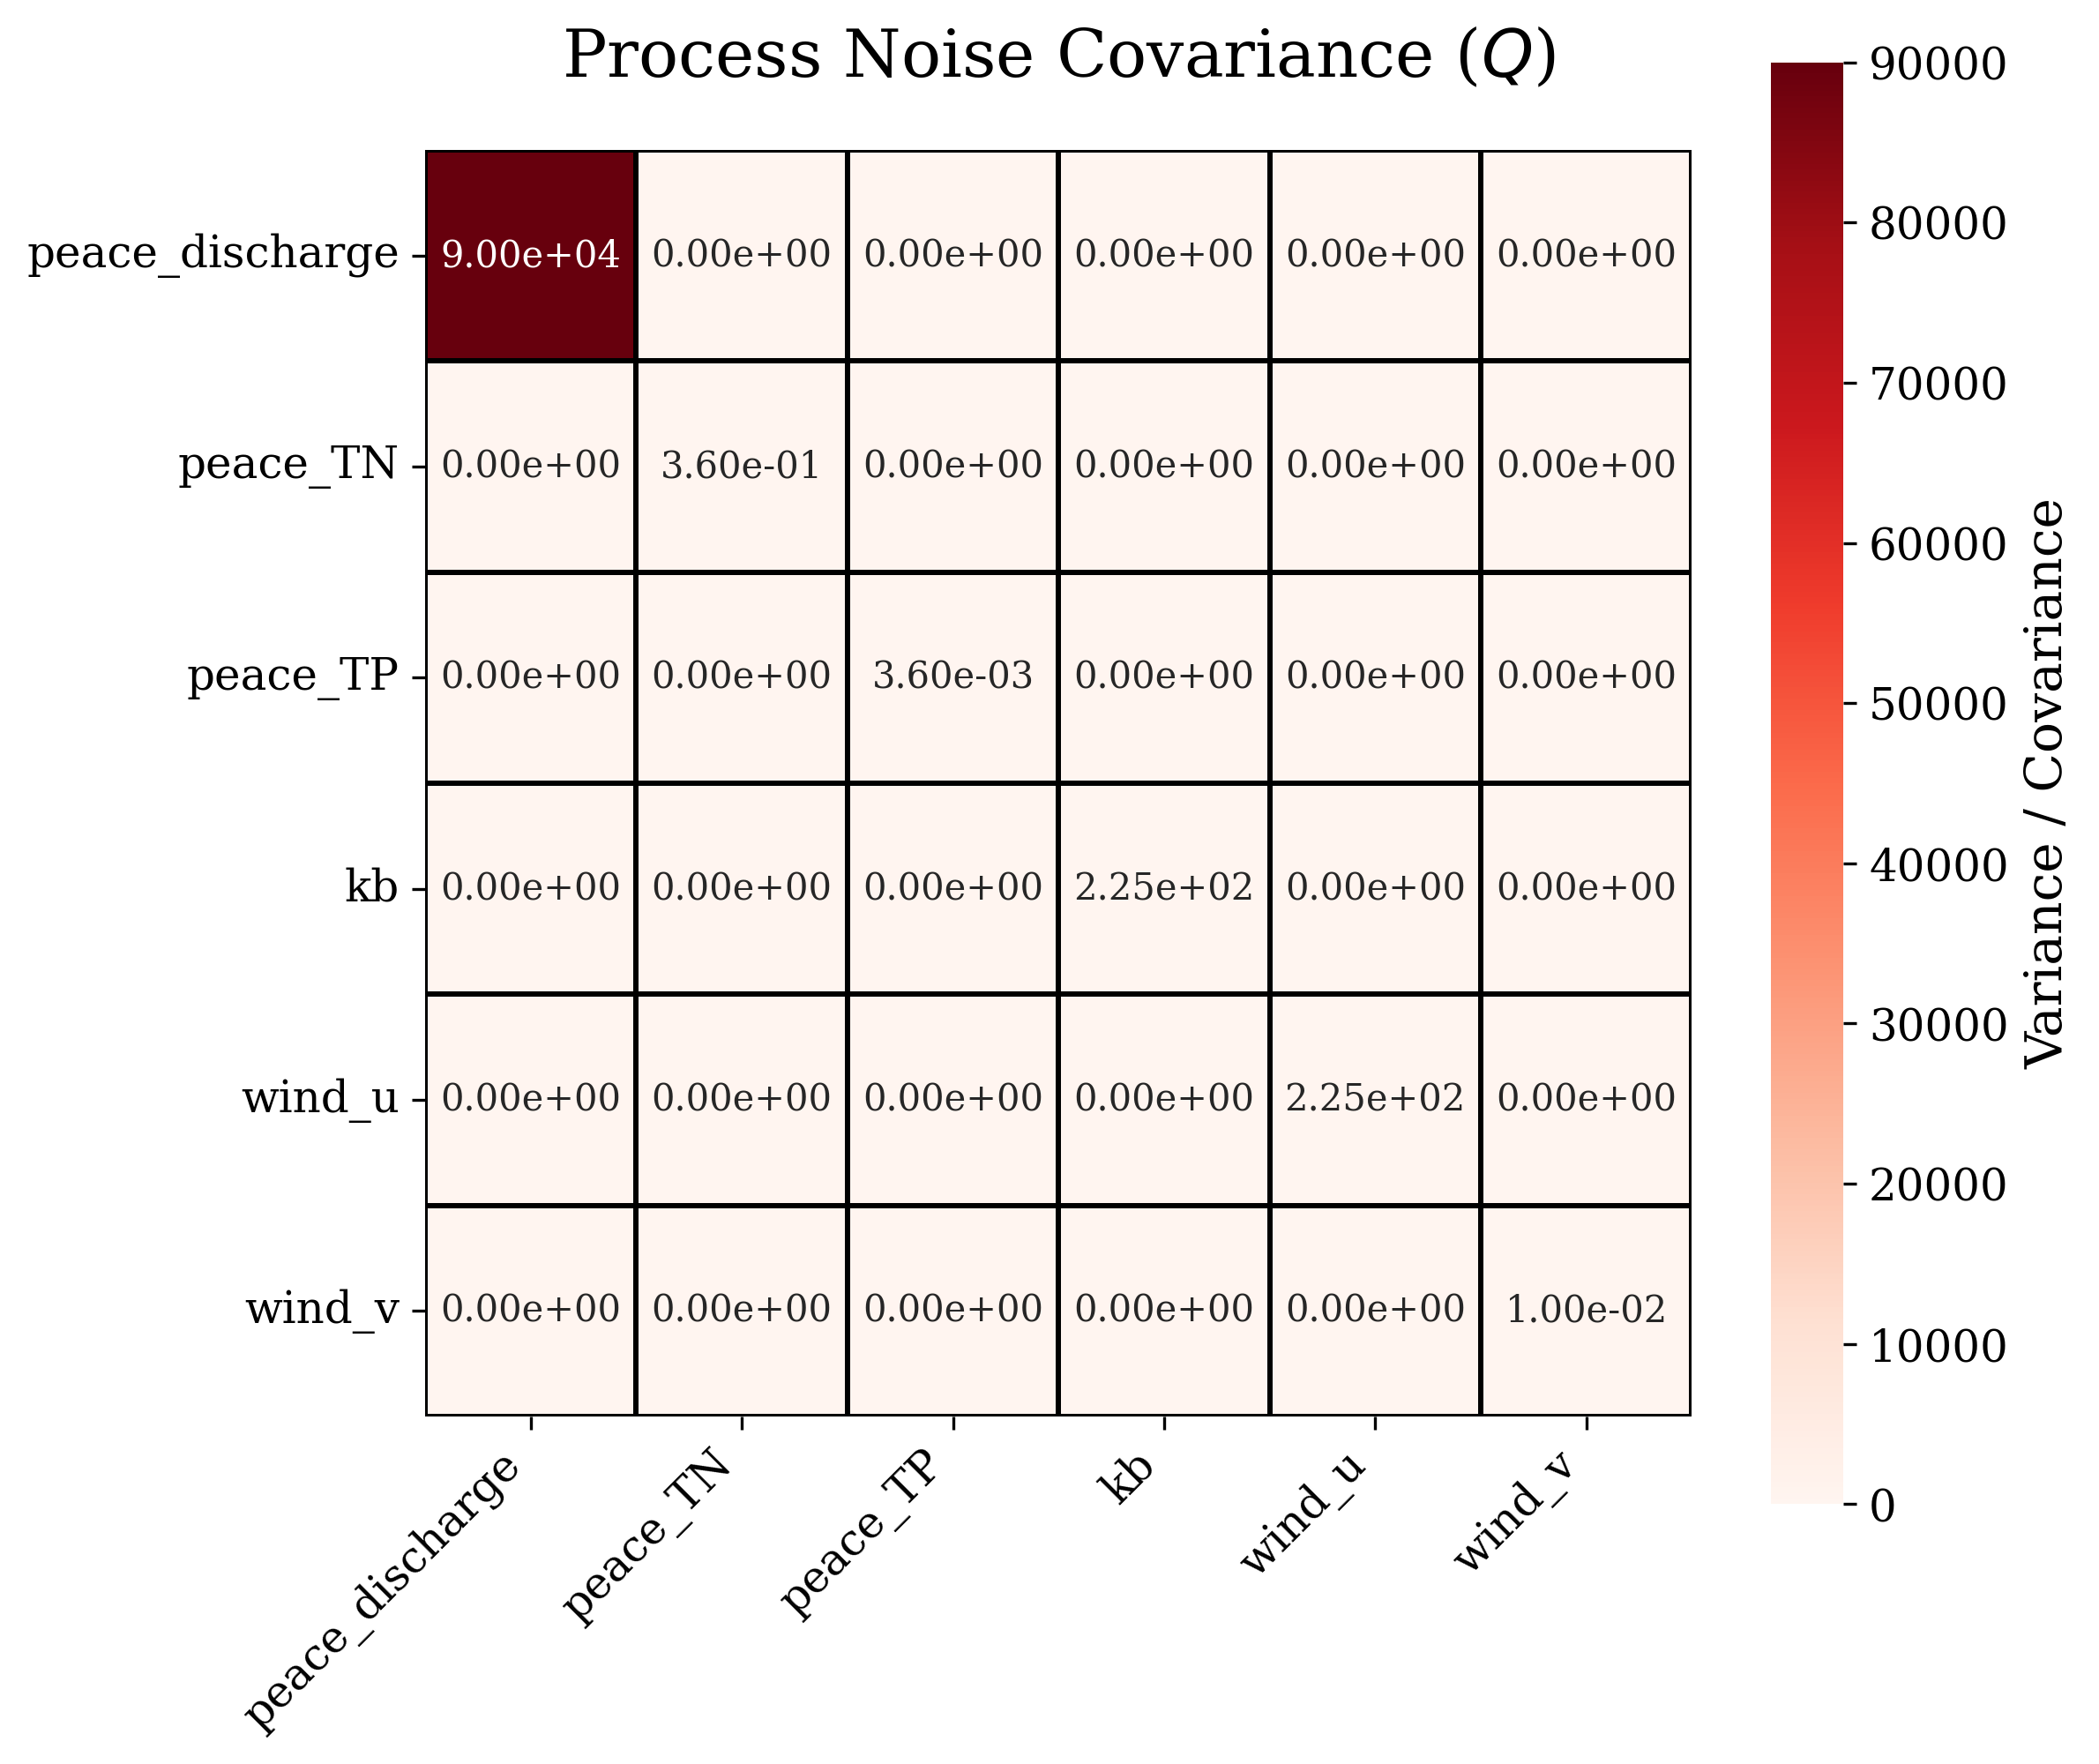

Saved: output/matrix_R_heatmap.png


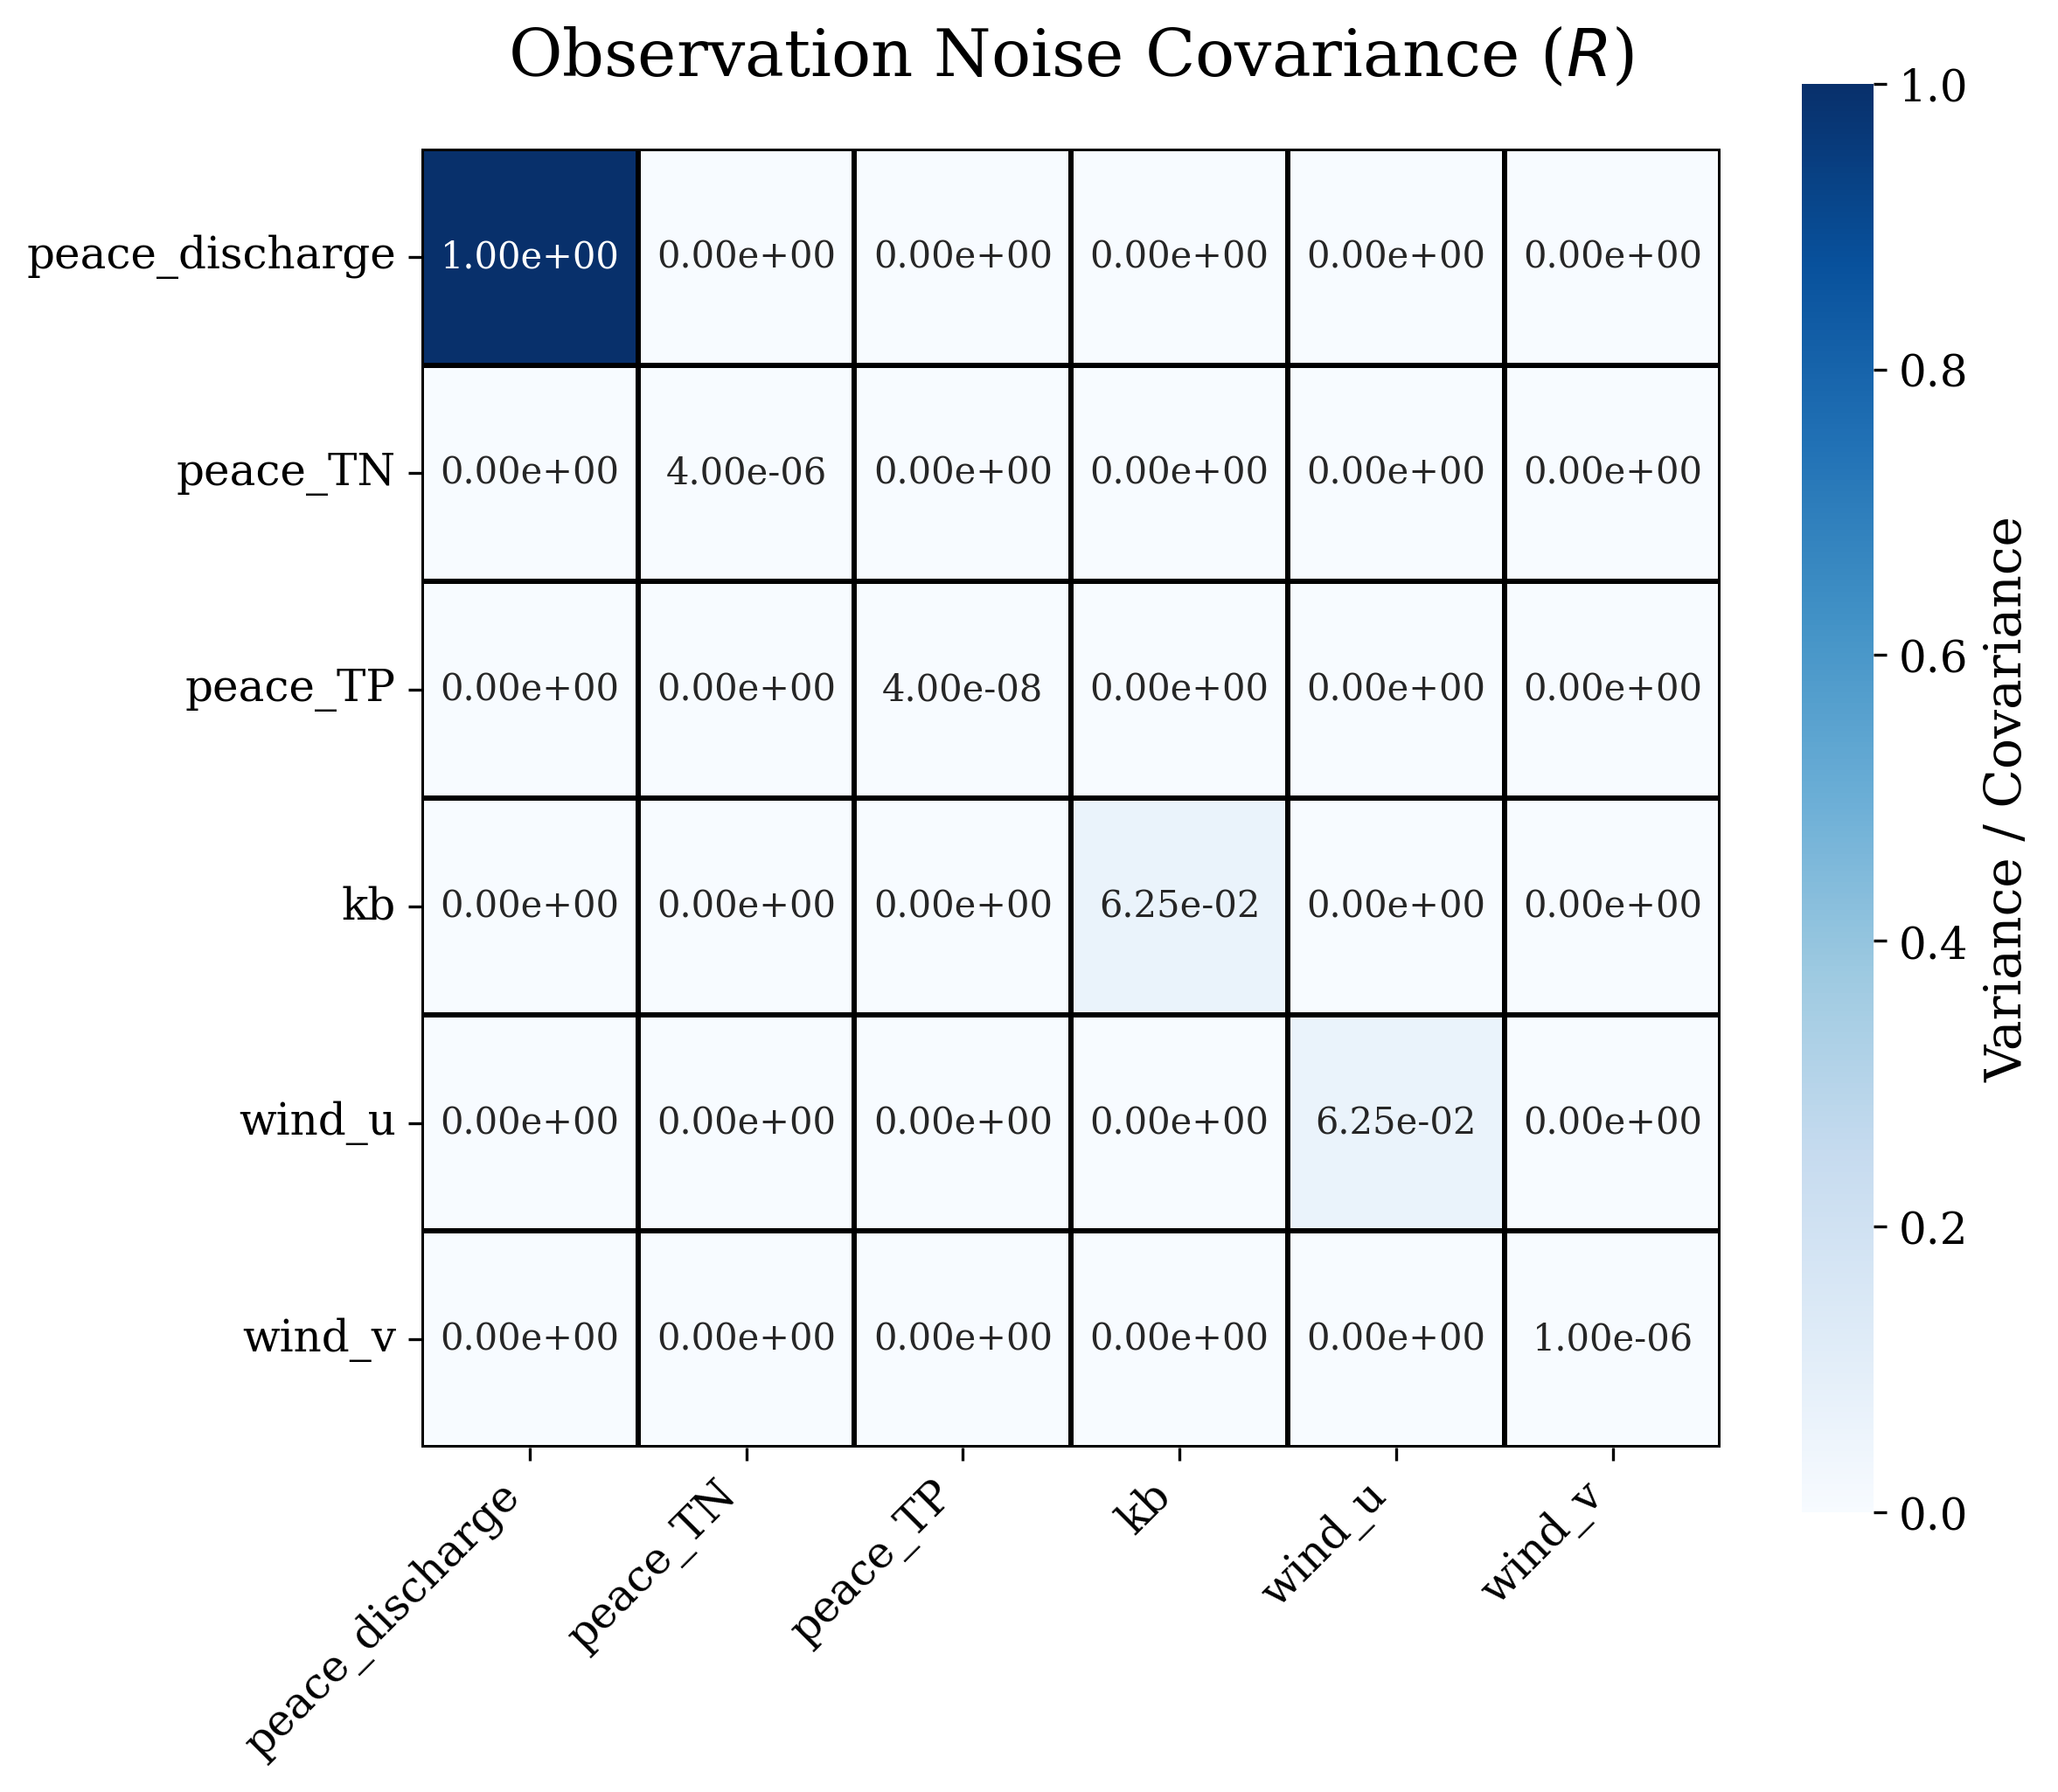

In [ ]:
class EnsembleKalmanFilter:
    """
    Stochastic Ensemble Kalman Filter (Burgers et al., 1998).
    Includes observation perturbation to maintain ensemble variance.
    """
    def __init__(self, x_init, P_init, dim_z, N):
        """
        Args:
            x_init: Initial state mean (dim_x,)
            P_init: Initial state covariance (dim_x, dim_x)
            dim_z:  Dimension of observations
            N:      Number of ensemble members
        """
        self.dim_x = len(x_init)
        self.dim_z = dim_z
        self.N = N
        self.x = None # Current state mean
        self.P = None # Current state covariance

        # Initialize Ensemble
        # We enforce symmetry and positive-definiteness on P_init
        P_init = (P_init + P_init.T) / 2
        self.ensemble = self._multivariate_normal(x_init, P_init, N)

        # Calculate initial stats
        self.x = np.mean(self.ensemble, axis=0)
        self.P = np.cov(self.ensemble.T)

        print(f"EnKF Initialized. Members: {N}, State Dim: {self.dim_x}")

    def predict(self, F_func, Q, dt=1):
        """
        Propagate state forward: x = F(x) + Noise
        """
        # 1. Apply Model Dynamics (The "Physics" or "AI")
        # We apply F_func to every member of the ensemble
        self.ensemble = np.apply_along_axis(F_func, 1, self.ensemble)

        # 2. Add Process Noise (System Error)
        if Q is not None:
            Q = (Q + Q.T) / 2
            noise = self._multivariate_normal(np.zeros(self.dim_x), Q, self.N)
            self.ensemble += noise

        # Update stats
        self.x = np.mean(self.ensemble, axis=0)
        self.P = np.cov(self.ensemble.T)

    def update(self, z, R, H=None):
        """
        Assimilate observation: x = x + K(z - Hx)
        """
        if H is None: H = np.eye(self.dim_z, self.dim_x)

        # 1. Project Ensemble to Observation Space
        # Shape: (N, dim_z)
        Hx = self.ensemble @ H.T

        # 2. Perturb Observations (CRITICAL for Stochastic EnKF)
        # We treat the observation as a random variable, not a single truth
        R = (R + R.T) / 2
        obs_noise = self._multivariate_normal(np.zeros(self.dim_z), R, self.N)
        z_perturbed = z + obs_noise

        # 3. Calculate Innovation (Residual)
        # Difference between "noisy measurement" and "predicted measurement"
        D = z_perturbed - Hx

        # 4. Calculate Kalman Gain (K)
        # P_zz = H P H' + R
        # K = P H' (P_zz)^-1
        P_prior = np.cov(self.ensemble.T)
        P_zz = H @ P_prior @ H.T + R

        # Use Pseudo-Inverse for stability
        K = P_prior @ H.T @ np.linalg.pinv(P_zz)

        # 5. Update Ensemble
        # x_new = x_old + K * Innovation
        self.ensemble = self.ensemble + (D @ K.T)

        # Update stats
        self.x = np.mean(self.ensemble, axis=0)
        self.P = np.cov(self.ensemble.T)

        return self.x, self.P

    def _multivariate_normal(self, mean, cov, size):
        """Helper to sample safely, adding jitter if matrix is singular."""
        try:
            return np.random.multivariate_normal(mean, cov, size)
        except np.linalg.LinAlgError:
            # Add small "jitter" to diagonal to fix numerical instability
            print("Warning: Matrix not positive definite. Adding jitter.")
            epsilon = 1e-6 * np.eye(len(mean))
            return np.random.multivariate_normal(mean, cov + epsilon, size)


# --- 2. Setup Function (Robust with Manual Overrides) ---
def setup_enkf(enkf_state_vars, n_enkf, train_df, test_df_unscaled,
               seq_len, feature_columns, manual_r_diag=None, manual_q_diag=None):
    """
    Configures the EnKF.
    Allows manual override of Q (Process) and R (Observation) noise diagonals.
    """
    print("\n--- Setting up EnKF ---")

    # Validation
    if not all(col in test_df_unscaled.columns for col in enkf_state_vars):
        print(f"Error: Missing state variables in test data.")
        return None, None, None, None

    dim_x = len(enkf_state_vars)

    # A. Initial State (x0)
    start_idx = seq_len - 1
    x_init = test_df_unscaled[enkf_state_vars].iloc[start_idx].values.astype(float)
    print(f"Initial State Vector (t=0): {x_init}")

    # B. Initial Covariance (P0)
    P_init = np.diag((np.abs(x_init) * 0.30) ** 2) + 1e-6 * np.eye(dim_x)

    # C. Noise Matrices (Q and R)

    # --- R MATRIX (Observation Noise) ---
    if manual_r_diag is not None:
        if len(manual_r_diag) != dim_x:
            print(f"Error: Manual R diag length ({len(manual_r_diag)}) does not match state vars ({dim_x})")
            return None, None, None, None
        print("-> Using MANUAL R Matrix values.")
        R_matrix = np.diag(manual_r_diag)
    else:
        print("-> Calculating Automatic R Matrix (1% of mean).")
        r_diags = []
        for col in enkf_state_vars:
            mean_val = train_df[col].mean()
            r_diags.append((abs(mean_val) * 0.01) ** 2)
        R_matrix = np.diag(r_diags)

    # --- Q MATRIX (Process Noise) ---
    if manual_q_diag is not None:
        if len(manual_q_diag) != dim_x:
            print(f"Error: Manual Q diag length ({len(manual_q_diag)}) does not match state vars ({dim_x})")
            return None, None, None, None
        print("-> Using MANUAL Q Matrix values.")
        Q_matrix = np.diag(manual_q_diag)
    else:
        print("-> Calculating Automatic Q Matrix (based on volatility).")
        q_diags = []
        for col in enkf_state_vars:
            volatility = train_df[col].diff().std()
            if pd.isna(volatility) or volatility == 0: volatility = 1e-3
            q_diags.append((volatility * 2.0) ** 2)
        Q_matrix = np.diag(q_diags)

    print("Noise Matrices Finalized:")
    print(f"  R (Obs Noise) diag: {np.diag(R_matrix)}")
    print(f"  Q (Proc Noise) diag: {np.diag(Q_matrix)}")

    # D. Feature Indices
    try:
        enkf_indices = [feature_columns.index(var) for var in enkf_state_vars]
    except ValueError as e:
        print(f"Error mapping variables to features: {e}")
        return None, None, None, None

    # E. Create Instance
    enkf = EnsembleKalmanFilter(x_init, P_init, dim_z=dim_x, N=n_enkf)
    enkf.R = R_matrix
    enkf.Q = Q_matrix

    return enkf, enkf_indices, R_matrix, Q_matrix

# --- 3. Execute ---
if __name__ == "__main__":
    try:
        # Configuration check
        REQUIRED = ['ENKF_STATE_VARS', 'N_ENKF', 'train_df', 'test_df',
                    'SEQUENCE_LENGTH', 'final_feature_columns_used']

        for var in REQUIRED:
            if var not in locals(): raise NameError(f"{var} is missing.")


        if (ENKF_NOISE_ESTIMATION == 'manual'):
          MANUAL_Q = MANUAL_Q_DIAG
          MANUAL_R = MANUAL_R_DIAG
        else:
          MANUAL_Q = None
          MANUAL_R = None

        enkf_instance, enkf_indices, R_matrix_enkf, Q_matrix_enkf = setup_enkf(
            enkf_state_vars=ENKF_STATE_VARS,
            n_enkf=N_ENKF,
            train_df=train_df,
            test_df_unscaled=test_df,
            seq_len=SEQUENCE_LENGTH,
            feature_columns=final_feature_columns_used,
            manual_r_diag=MANUAL_R,
            manual_q_diag=MANUAL_Q
        )

        if enkf_instance:
            print("\nEnKF Setup Complete.")

    except Exception as e:
        print(f"EnKF Setup Failed: {e}")

if 'Q_matrix_enkf' in locals() and 'R_matrix_enkf' in locals() and 'ENKF_STATE_VARS' in locals():

    print("\nGenerating publication-quality heatmaps for Q and R matrices...")

    # --- STYLE SETTINGS (Academic Standard) ---
    plt.rcdefaults()
    params = {
        'font.family': 'serif',
        'font.serif': ['Times New Roman', 'Times', 'DejaVu Serif'],
        'axes.titlesize': 18,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'figure.dpi': 300
    }
    plt.rcParams.update(params)

    # Helper function to plot and save
    def plot_covariance_matrix(matrix, title, filename, labels, cmap='Blues'):
        plt.figure(figsize=(8, 7))

        sns.heatmap(matrix, annot=True, fmt='.2e', cmap=cmap,
                    xticklabels=labels, yticklabels=labels,
                    square=True, cbar_kws={'label': 'Variance / Covariance'},
                    linewidths=1, linecolor='black')

        plt.title(title, pad=20)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()

        save_path = f"output/{filename}"
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved: {save_path}")
        plt.show()

    # --- 1. Plot Q Matrix (Process Noise) ---
    plot_covariance_matrix(
        Q_matrix_enkf,
        title="Process Noise Covariance ($Q$)",
        filename="matrix_Q_heatmap.png",
        labels=ENKF_STATE_VARS,
        cmap="Reds"
    )

    # --- 2. Plot R Matrix (Observation Noise) ---
    plot_covariance_matrix(
        R_matrix_enkf,
        title="Observation Noise Covariance ($R$)",
        filename="matrix_R_heatmap.png",
        labels=ENKF_STATE_VARS,
        cmap="Blues"
    )

else:
    print("Error: Q and R matrices (or state vars) not found. Run Step 11 first.")

## Part 12: EnKF + MC Dropout Forecasting Loop.

This part defines and executes the main forecasting loop. It iterates through the test set, using the initialized EnKF (enkf_instance from Part 11) to update the hydrological state variables based on observations from the unscaled test_df. These updated states are then scaled and inserted into the corresponding input sequence from X_test. Finally, it uses the trained LSTM model (trained_model from Part 9) to make predictions. If PERFORM_MC_DROPOUT is True, it performs multiple predictions with dropout enabled to capture model uncertainty.

This cell defines the run_enkf_mc_forecast function and executes the forecasting simulation over the test period. It integrates the EnKF updates with LSTM predictions and optionally performs Monte Carlo Dropout.


Explanation:

1. Function run_enkf_mc_forecast:
    - Takes all necessary components as arguments: the trained model, the initialized enkf_instance, enkf_indices, noise matrices R and Q, test sequences x_test, y_test, the unscaled test_df, the feature_columns list, the fitted scaler, sequence length, and flags/parameters for EnKF and MC Dropout.
    - Initialization: Creates an empty NumPy array (predictions) sized to store either single predictions or multiple MC samples per time step.
    - Loop: Iterates from i = 0 to num_test_preds - 1.
    - EnKF Step (Conditional): If perform_enkf is True, it gets the observation z_k from test_df_unscaled for the current step, runs enkf.predict() and enkf.update(), and stores the corrected state x_updated_enkf. Includes error handling.
    - Prepare LSTM Input: Copies the relevant scaled sequence X_test[i]. If EnKF was performed successfully, it scales the x_updated_enkf using the provided scaler and replaces the corresponding feature values in the last time step of the copied sequence. Includes error handling for scaling.
    - LSTM Predict Step (Conditional MC):
        - If perform_mc is True, it runs the model n_mc_samples times on the (potentially EnKF-updated) input sequence with training=True to enable dropout. Stores all probability outputs for this step.
        - If perform_mc is False, it runs model.predict() once (standard inference, dropout off) and stores the single probability output.
    - Error Handling: Includes try-except blocks for robustness during EnKF steps and LSTM prediction. The loop breaks if critical errors occur.
    - Trimming: After the loop, it trims the predictions and y_test arrays to match the number of successfully completed steps.
    - Returns: The array of predictions (shape (n_preds, n_mc_samples) if MC, (n_preds, 1) otherwise) and the potentially trimmed y_test_trimmed.
2. Main Execution:
Checks for all prerequisite variables defined in previous steps.
Calls run_enkf_mc_forecast, passing the necessary arguments and configuration flags.
Stores the results in mc_predictions_results and y_test_results.
Prints confirmation messages.

After running this cell, mc_predictions_results will contain the raw output from the forecasting loop (either single predictions or MC ensembles), ready for analysis and evaluation in Part 13: EnKF + MC Dropout Evaluation.

In [ ]:
def run_enkf_mc_forecast(model, enkf_instance, enkf_indices, R_matrix, Q_matrix,
                         x_test, y_test, test_df_unscaled, scaler,
                         seq_len, perform_enkf=True, perform_mc=True, n_mc_samples=50):
    """
    Optimized Forecasting Loop with Vectorized MC Dropout.
    """
    # 1. Validation & Setup
    if model is None or x_test is None: return None, None
    print(f"\n--- Starting Forecast (EnKF={perform_enkf}, MC={perform_mc}) ---")

    num_steps = len(y_test)
    n_features = x_test.shape[2]

    # Pre-allocate output array
    # If MC is off, we still use shape (N, 1) for consistency
    samples_col = n_mc_samples if perform_mc else 1
    predictions = np.zeros((num_steps, samples_col))

    # 2. Pre-fetch Scaler Parameters (Speed Optimization)
    # Accessing scaler attributes inside the loop is slow. Do it once here.
    if perform_enkf:
        try:
            # Handle StandardScaler vs RobustScaler
            if hasattr(scaler, 'mean_'):
                mu, sigma = scaler.mean_, scaler.scale_
            elif hasattr(scaler, 'center_'):
                mu, sigma = scaler.center_, scaler.scale_
            else:
                print("Error: Scaler not fitted."); return None, None

            # Keep only the stats for the EnKF variables to avoid indexing in loop
            enkf_mu = mu[enkf_indices]
            enkf_sigma = sigma[enkf_indices]
        except Exception as e:
            print(f"Scaler Error: {e}"); return None, None

    # 3. Main Loop
    # EnKF must be sequential (step t depends on step t-1)
    for i in tqdm(range(num_steps), desc="Forecasting"):

        # A. Current Timestamp Index
        # The test_df index corresponding to the *end* of the current sequence
        df_idx = i + seq_len - 1
        if df_idx >= len(test_df_unscaled): break

        # B. EnKF Update Step
        updated_state = None
        if perform_enkf:
            # Get Observation (z)
            z = test_df_unscaled[ENKF_STATE_VARS].iloc[df_idx].values

            # 1. Predict (Move Ensemble Forward)
            # Note: In a full Hybrid EnKF, the 'F' function would run the LSTM here.
            # Here we use the persistence assumption for the state transition.
            enkf_instance.predict(lambda x: x, Q=Q_matrix)

            # 2. Update (Correct with Observation)
            updated_state, _ = enkf_instance.update(z, R_matrix)

        # C. Update LSTM Input
        # We copy the sequence so we don't overwrite the original data
        current_seq = x_test[i].copy() # Shape: (Seq_Len, Features)

        if perform_enkf and updated_state is not None:
            # Scale the updated state (Vectorized Math)
            # (Raw - Mean) / Scale
            scaled_state = (updated_state - enkf_mu) / enkf_sigma

            # Inject into the LAST time step of the sequence
            # We replace only the columns corresponding to EnKF variables
            current_seq[-1, enkf_indices] = scaled_state

        # D. LSTM Prediction (Vectorized MC Dropout)
        # Prepare Tensor
        # Shape: (1, Seq_Len, Features)
        input_tensor = tf.convert_to_tensor([current_seq], dtype=tf.float32)

        if perform_mc:
            # OPTIMIZATION: Tile the input N times to create a batch
            # New Shape: (n_mc_samples, Seq_Len, Features)
            batch = tf.tile(input_tensor, [n_mc_samples, 1, 1])

            # ONE single call to the model for all samples
            # training=True enables Dropout
            preds = model(batch, training=True)

            # Store results (flatten to 1D array of probabilities)
            predictions[i, :] = preds[:, 0].numpy()
        else:
            # Standard Inference (No Dropout)
            pred = model(input_tensor, training=False)
            predictions[i, 0] = pred[0, 0].numpy()

    return predictions, y_test[:len(predictions)]

# --- Execute ---
if __name__ == "__main__":
    if 'trained_model' in locals() and 'enkf_instance' in locals():
        if PERFORM_ENKF and enkf_instance is None:
            print("Warning: PERFORM_ENKF is True, but 'enkf_instance' not found.")
            print("Running in pure LSTM mode (EnKF disabled for this run).")
            # Temporarily disable for this function call to prevent crash
            current_perform_enkf = False
        else:
            current_perform_enkf = PERFORM_ENKF

        mc_preds, y_test_trimmed = run_enkf_mc_forecast(
            model=trained_model,
            enkf_instance=enkf_instance,
            enkf_indices=enkf_indices,
            R_matrix=R_matrix_enkf,
            Q_matrix=Q_matrix_enkf,
            x_test=X_test,
            y_test=y_test,
            test_df_unscaled=test_df,
            scaler=scaler, # Ensure this matches your scaler variable name
            seq_len=SEQUENCE_LENGTH,
            perform_enkf=True,         # Set to False to test Baseline again
            perform_mc=True,           # Set to True for Uncertainty
            n_mc_samples=50            # 50 is a good balance for speed/accuracy
        )

        if mc_preds is not None:
            print(f"✅ Forecast Complete. Prediction Shape: {mc_preds.shape}")
    else:
        print("Error: Prerequisites (Part 9 Model or Part 11 EnKF) missing.")


--- Starting Forecast (EnKF=True, MC=True) ---


Forecasting: 100%|██████████| 230/230 [00:05<00:00, 42.55it/s]

✅ Forecast Complete. Prediction Shape: (230, 50)


## Part 13: EnKF + MC Dropout Evaluation


=== Evaluating Uncertainty: EnKF_LSTM_MC ===
Optimal Threshold (Auto-F1): 0.8037 (Max F1: 0.8649)

Performance Metrics:
  Accuracy:    0.9130
  AUC-ROC:     0.9529
  Recall:      0.8421 (Caught 84.2% of blooms)
  Precision:   0.8889
  Brier Score: 0.1236
Saved Plot: output/forecast_EnKF_LSTM_MC.png


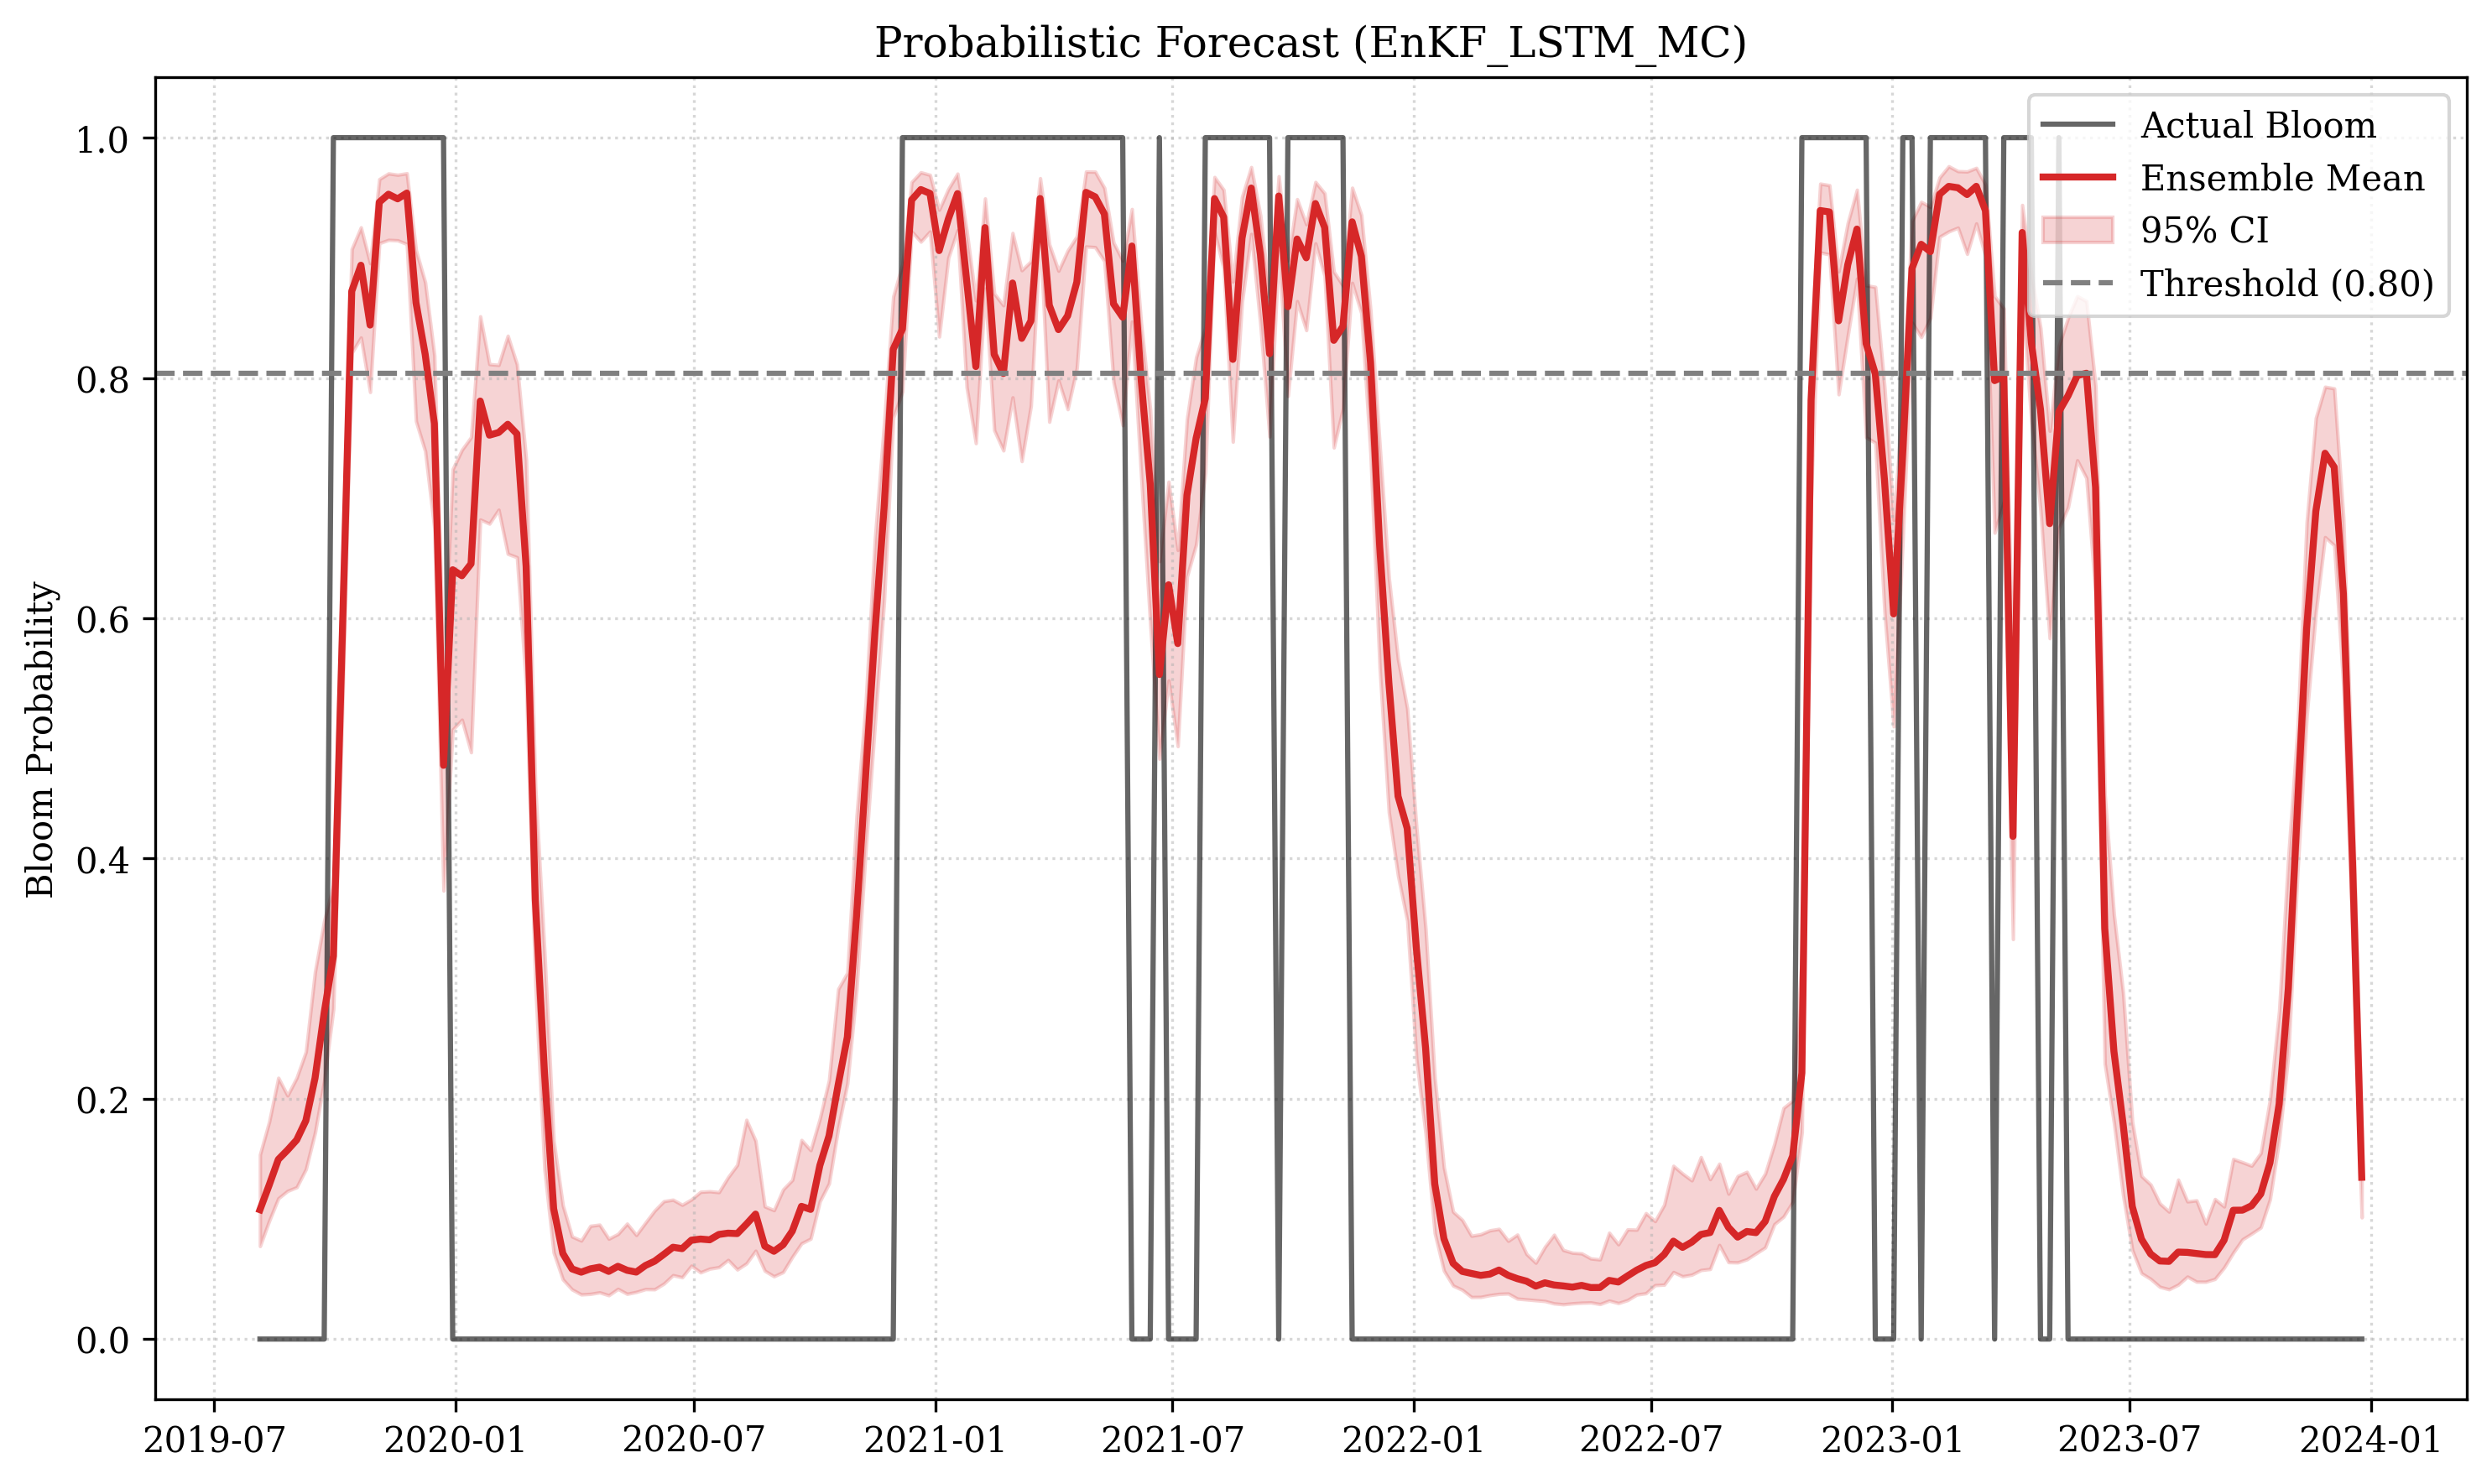

Saved Plot: output/calibration_EnKF_LSTM_MC.png


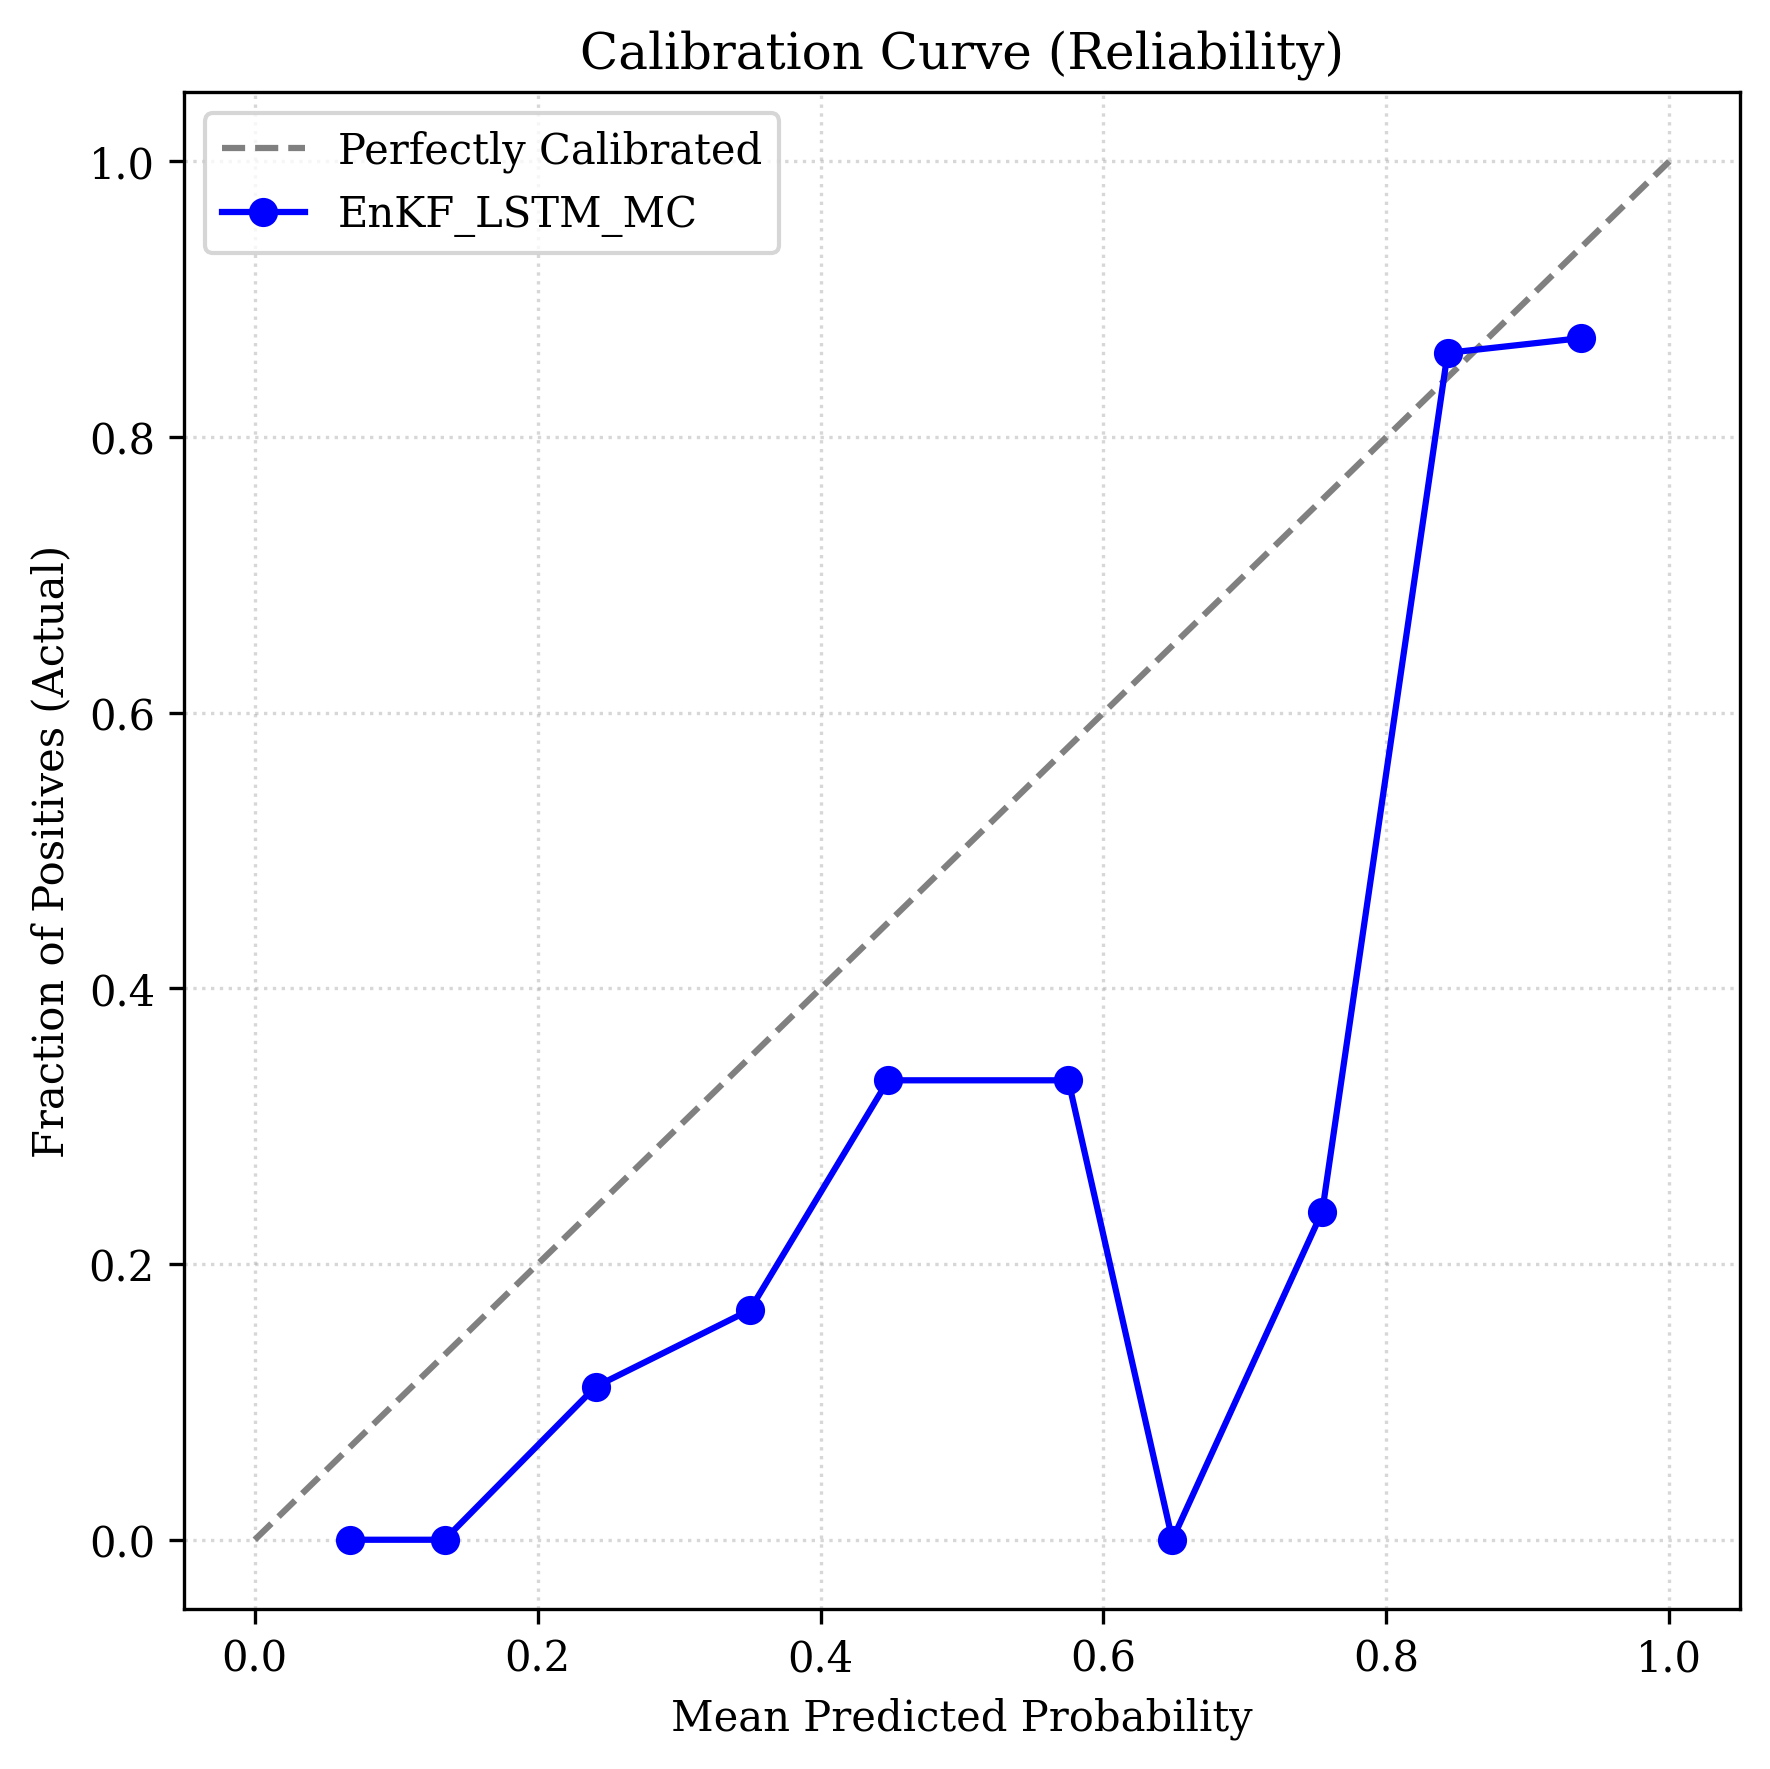

Saved Plot: output/entropy_EnKF_LSTM_MC.png


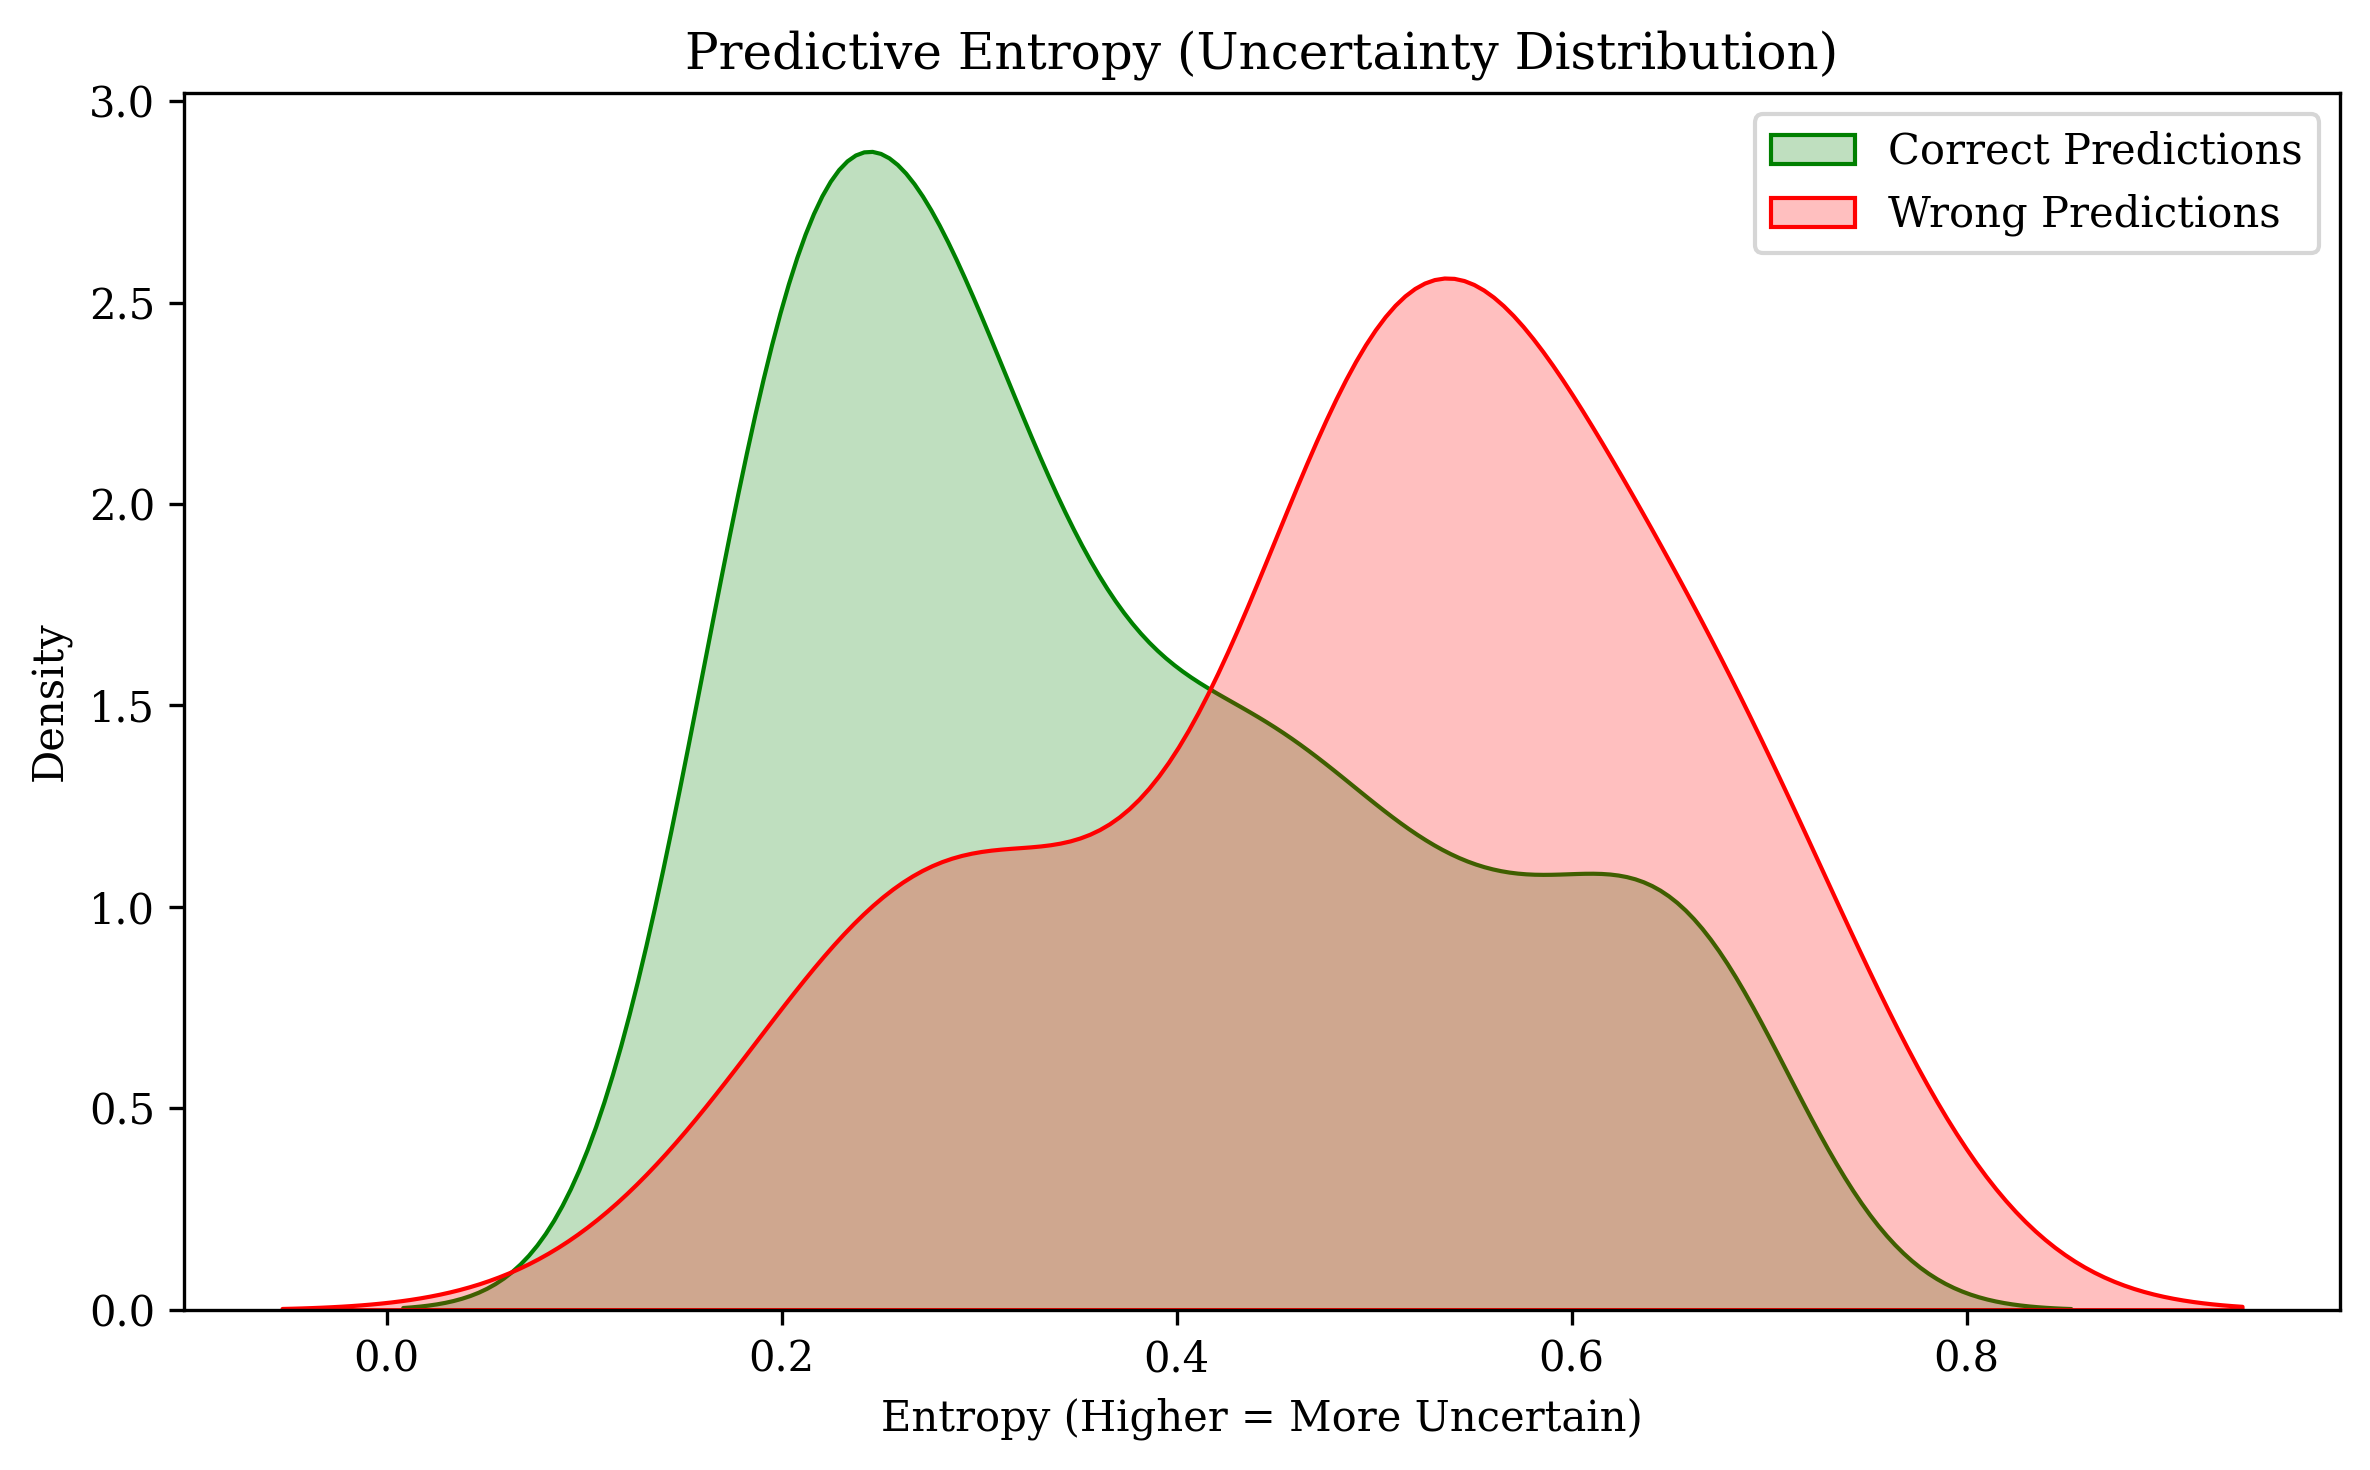

✅ Saved Metrics to: output/metrics_enkf_mc.json
✅ Saved Raw Data to: output/predictions_enkf_mc.csv


In [ ]:
from sklearn.calibration import calibration_curve
def evaluate_mc_predictions(mc_preds, y_test, test_df_unscaled, seq_len,
                            forecast_horizon, model_name="EnKF_MC",
                            output_dir="output", manual_threshold=None):
    """
    Evaluates probabilistic predictions (Mean, Uncertainty, Calibration).

    Args:
        mc_preds: Array of shape (n_samples, n_mc_iterations) or (n_samples, 1)
        y_test: True labels (n_samples,)
        test_df_unscaled: DataFrame with timestamps
        seq_len: Input sequence length (for aligning dates)
        forecast_horizon: Forecast horizon (for aligning dates)
        model_name: String for labeling files/plots
        output_dir: Folder to save results
        manual_threshold: Float (0.0-1.0) to force a specific decision boundary.
                          If None, calculates optimal F1 threshold.
    """
    print(f"\n=== Evaluating Uncertainty: {model_name} ===")

    # 1. Setup Output Directory
    os.makedirs(output_dir, exist_ok=True)

    # Validation
    if mc_preds is None or y_test is None: return None

    # 2. Statistics Calculation
    # -------------------------------------------------------
    # Mean: The "Best Guess"
    y_mean = np.mean(mc_preds, axis=1)

    # Std Dev: The "Disagreement" (Model Uncertainty)
    y_std = np.std(mc_preds, axis=1)

    # 95% Confidence Interval
    ci_lower = np.percentile(mc_preds, 2.5, axis=1)
    ci_upper = np.percentile(mc_preds, 97.5, axis=1)

    # Entropy (Uncertainty)
    epsilon = 1e-10
    y_mean_clipped = np.clip(y_mean, epsilon, 1-epsilon)
    entropy = -(y_mean_clipped * np.log(y_mean_clipped) + (1-y_mean_clipped) * np.log(1-y_mean_clipped))

    # 3. Threshold Logic
    # -------------------------------------------------------
    if manual_threshold is not None:
        best_thresh = manual_threshold
        print(f"Using Manual Decision Threshold: {best_thresh:.4f}")
    else:
        # Calculate Optimal F1 Threshold
        precision, recall, thresholds = precision_recall_curve(y_test, y_mean)
        numerator = 2 * precision * recall
        denominator = precision + recall
        with np.errstate(divide='ignore', invalid='ignore'):
            fscore = np.nan_to_num(np.divide(numerator, denominator))

        ix = np.argmax(fscore)
        # Safety check if index is out of bounds
        best_thresh = thresholds[ix] if ix < len(thresholds) else 0.5
        print(f"Optimal Threshold (Auto-F1): {best_thresh:.4f} (Max F1: {fscore[ix]:.4f})")

    # Apply threshold
    y_pred_class = (y_mean >= best_thresh).astype(int)

    # 4. Calculate Metrics
    # -------------------------------------------------------
    try:
        metrics = {
            'accuracy': float(accuracy_score(y_test, y_pred_class)),
            'auc': float(roc_auc_score(y_test, y_mean)),
            'brier': float(brier_score_loss(y_test, y_mean)),
            'precision': float(precision_score(y_test, y_pred_class, zero_division=0)),
            'recall': float(recall_score(y_test, y_pred_class, zero_division=0)),
            'f1_score': float(f1_score(y_test, y_pred_class, zero_division=0)),
            'avg_entropy': float(np.mean(entropy)),
            'threshold_used': float(best_thresh)
        }

        print(f"\nPerformance Metrics:")
        print(f"  Accuracy:    {metrics['accuracy']:.4f}")
        print(f"  AUC-ROC:     {metrics['auc']:.4f}")
        print(f"  Recall:      {metrics['recall']:.4f} (Caught {metrics['recall']*100:.1f}% of blooms)")
        print(f"  Precision:   {metrics['precision']:.4f}")
        print(f"  Brier Score: {metrics['brier']:.4f}")
    except Exception as e:
        print(f"Error calculating metrics: {e}")
        metrics = {}

    # 5. PLOTTING (Publication Quality)
    # -------------------------------------------------------
    # Apply Style
    plt.rcdefaults()
    params = {'font.family': 'serif', 'figure.figsize': (10, 6), 'figure.dpi': 300}
    plt.rcParams.update(params)

    # Plot A: Forecast Time Series
    start_idx = seq_len + forecast_horizon - 1
    num_preds = len(y_mean)

    if start_idx + num_preds <= len(test_df_unscaled):
        dates = test_df_unscaled.index[start_idx : start_idx + num_preds]

        plt.figure()
        # Plot Actuals
        plt.plot(dates, y_test[:num_preds], color='black', alpha=0.6, label='Actual Bloom', linewidth=1.5)
        # Plot Mean Prediction
        plt.plot(dates, y_mean[:num_preds], color='#d62728', label='Ensemble Mean', linewidth=2)
        # Plot Confidence Interval
        plt.fill_between(dates, ci_lower[:num_preds], ci_upper[:num_preds], color='#d62728', alpha=0.2, label='95% CI')
        # Plot Threshold
        plt.axhline(best_thresh, color='gray', linestyle='--', label=f'Threshold ({best_thresh:.2f})')

        plt.title(f'Probabilistic Forecast ({model_name})')
        plt.ylabel('Bloom Probability')
        plt.legend(loc='upper right', frameon=True)
        plt.grid(True, linestyle=':', alpha=0.5)
        plt.tight_layout()

        save_path = os.path.join(output_dir, f"forecast_{model_name}.png")
        plt.savefig(save_path)
        print(f"Saved Plot: {save_path}")
        plt.show()

    # Plot B: Calibration Curve
    try:
        prob_true, prob_pred = calibration_curve(y_test, y_mean, n_bins=10)
        plt.figure(figsize=(6, 6))
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
        plt.plot(prob_pred, prob_true, marker='o', color='blue', label=model_name)
        plt.title('Calibration Curve (Reliability)')
        plt.xlabel('Mean Predicted Probability')
        plt.ylabel('Fraction of Positives (Actual)')
        plt.legend()
        plt.grid(True, linestyle=':', alpha=0.5)
        plt.tight_layout()

        save_path = os.path.join(output_dir, f"calibration_{model_name}.png")
        plt.savefig(save_path)
        print(f"Saved Plot: {save_path}")
        plt.show()
    except Exception as e:
        print(f"Skipping Calibration Plot: {e}")

    # Plot C: Entropy Distribution
    try:
        correct = (y_pred_class == y_test)
        plt.figure(figsize=(8, 5))
        sns.kdeplot(entropy[correct], fill=True, color='green', label='Correct Predictions')
        sns.kdeplot(entropy[~correct], fill=True, color='red', label='Wrong Predictions')
        plt.title('Predictive Entropy (Uncertainty Distribution)')
        plt.xlabel('Entropy (Higher = More Uncertain)')
        plt.legend()
        plt.tight_layout()

        save_path = os.path.join(output_dir, f"entropy_{model_name}.png")
        plt.savefig(save_path)
        print(f"Saved Plot: {save_path}")
        plt.show()
    except Exception as e:
        print(f"Skipping Entropy Plot: {e}")

    # 6. Return structured data
    return {
        'metrics': metrics,  # Clean dictionary for JSON
        'arrays': {          # Arrays for CSV/Debug
            'y_mean': y_mean,
            'y_std': y_std,
            'entropy': entropy,
            'y_actual': y_test,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper
        }
    }

# --- Execute ---
if __name__ == "__main__":
    if 'mc_preds' in locals() and mc_preds is not None:

        # 1. Run Evaluation (Try manual_threshold=0.3 if you want to fix lag)
        results = evaluate_mc_predictions(
            mc_preds=mc_preds,
            y_test=y_test_trimmed,
            test_df_unscaled=test_df,
            seq_len=SEQUENCE_LENGTH,
            forecast_horizon=FORECAST_HORIZON,
            model_name="EnKF_LSTM_MC",
            output_dir="output",
            manual_threshold=None  # <--- Change to 0.3 to reduce lag!
        )

        # 2. Save Metrics to JSON
        if results:
            json_path = os.path.join("output", "metrics_enkf_mc.json")
            try:
                with open(json_path, 'w') as f:
                    json.dump(results['metrics'], f, indent=4)
                print(f"✅ Saved Metrics to: {json_path}")
            except Exception as e:
                print(f"Error saving JSON: {e}")

            # 3. Save Raw Data to CSV
            csv_path = os.path.join("output", "predictions_enkf_mc.csv")
            try:
                df_results = pd.DataFrame(results['arrays'])
                # Add timestamp index if possible
                start_idx = SEQUENCE_LENGTH + FORECAST_HORIZON - 1
                if start_idx + len(df_results) <= len(test_df):
                    df_results.index = test_df.index[start_idx : start_idx + len(df_results)]

                df_results.to_csv(csv_path)
                print(f"✅ Saved Raw Data to: {csv_path}")
            except Exception as e:
                print(f"Error saving CSV: {e}")

    else:
        print("Error: 'mc_preds' not found. Run Step 12 first.")

# SHAP Analysis

Data Shape: 12 steps, 26 features
Mismatch: 25 names vs 26 data features.
Summarizing background data...
Initializing KernelExplainer...
Calculating SHAP values for 20 instances...


  0%|          | 0/20 [00:00<?, ?it/s]

SHAP calculation complete.


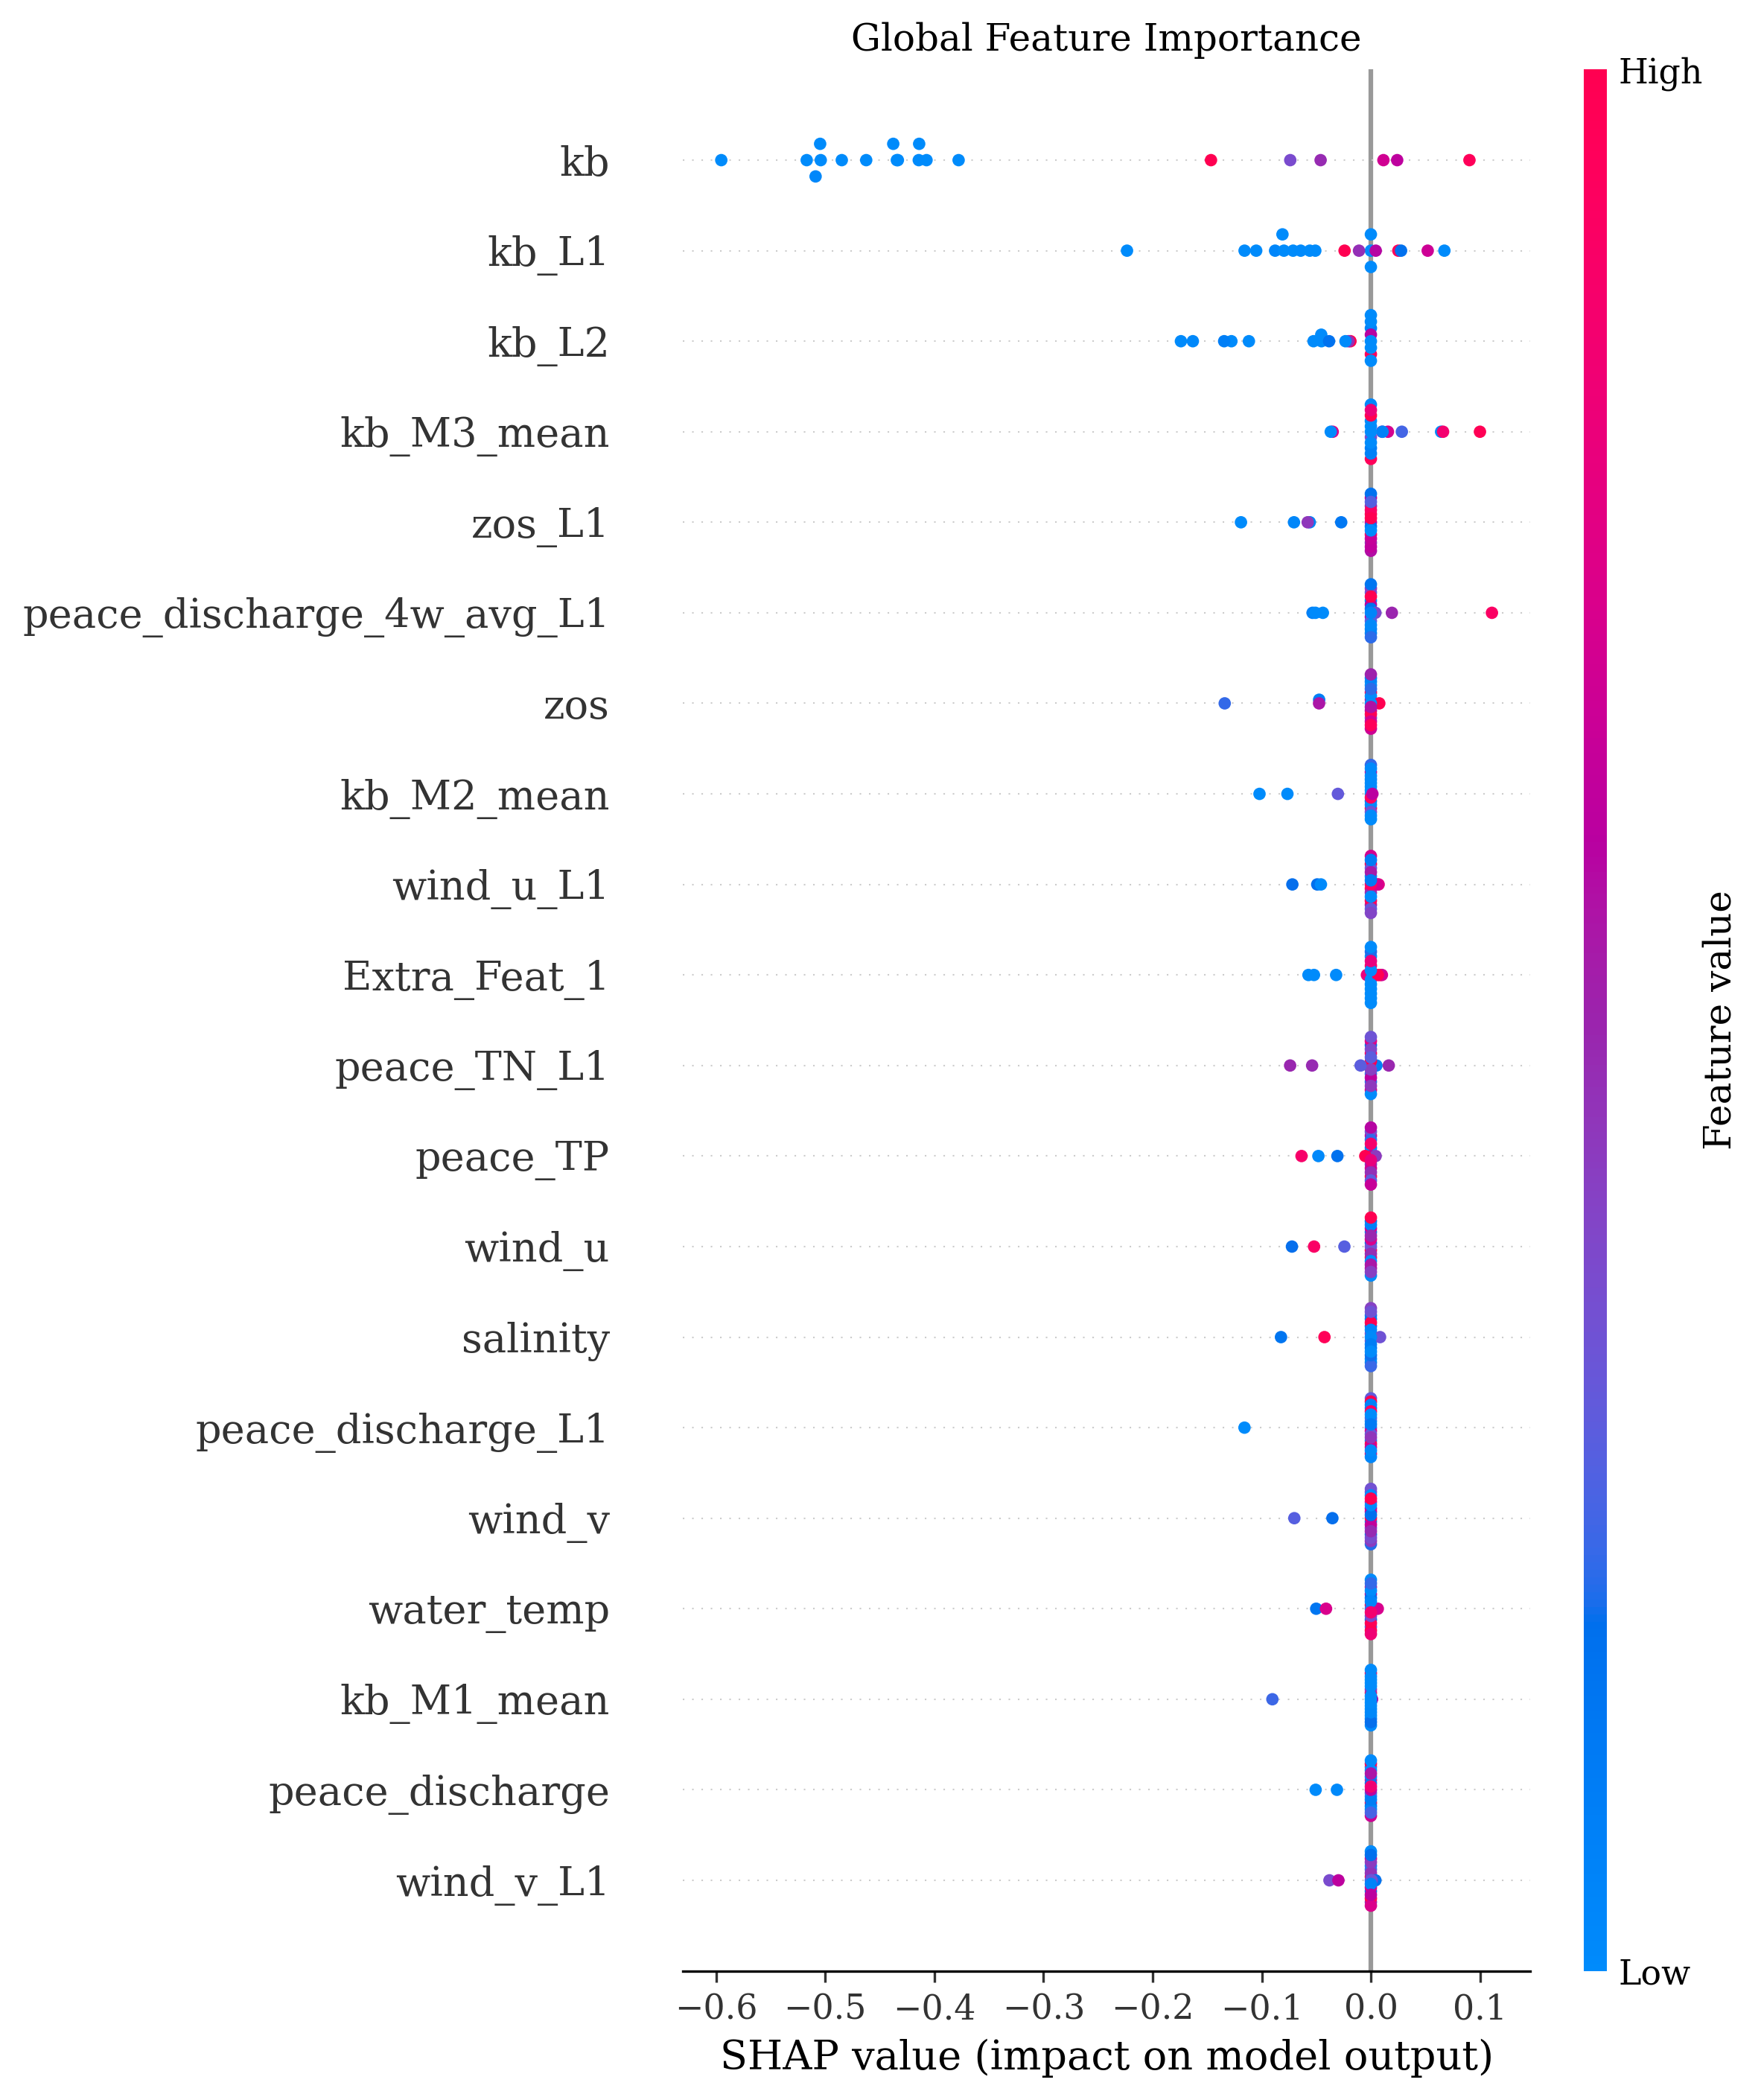

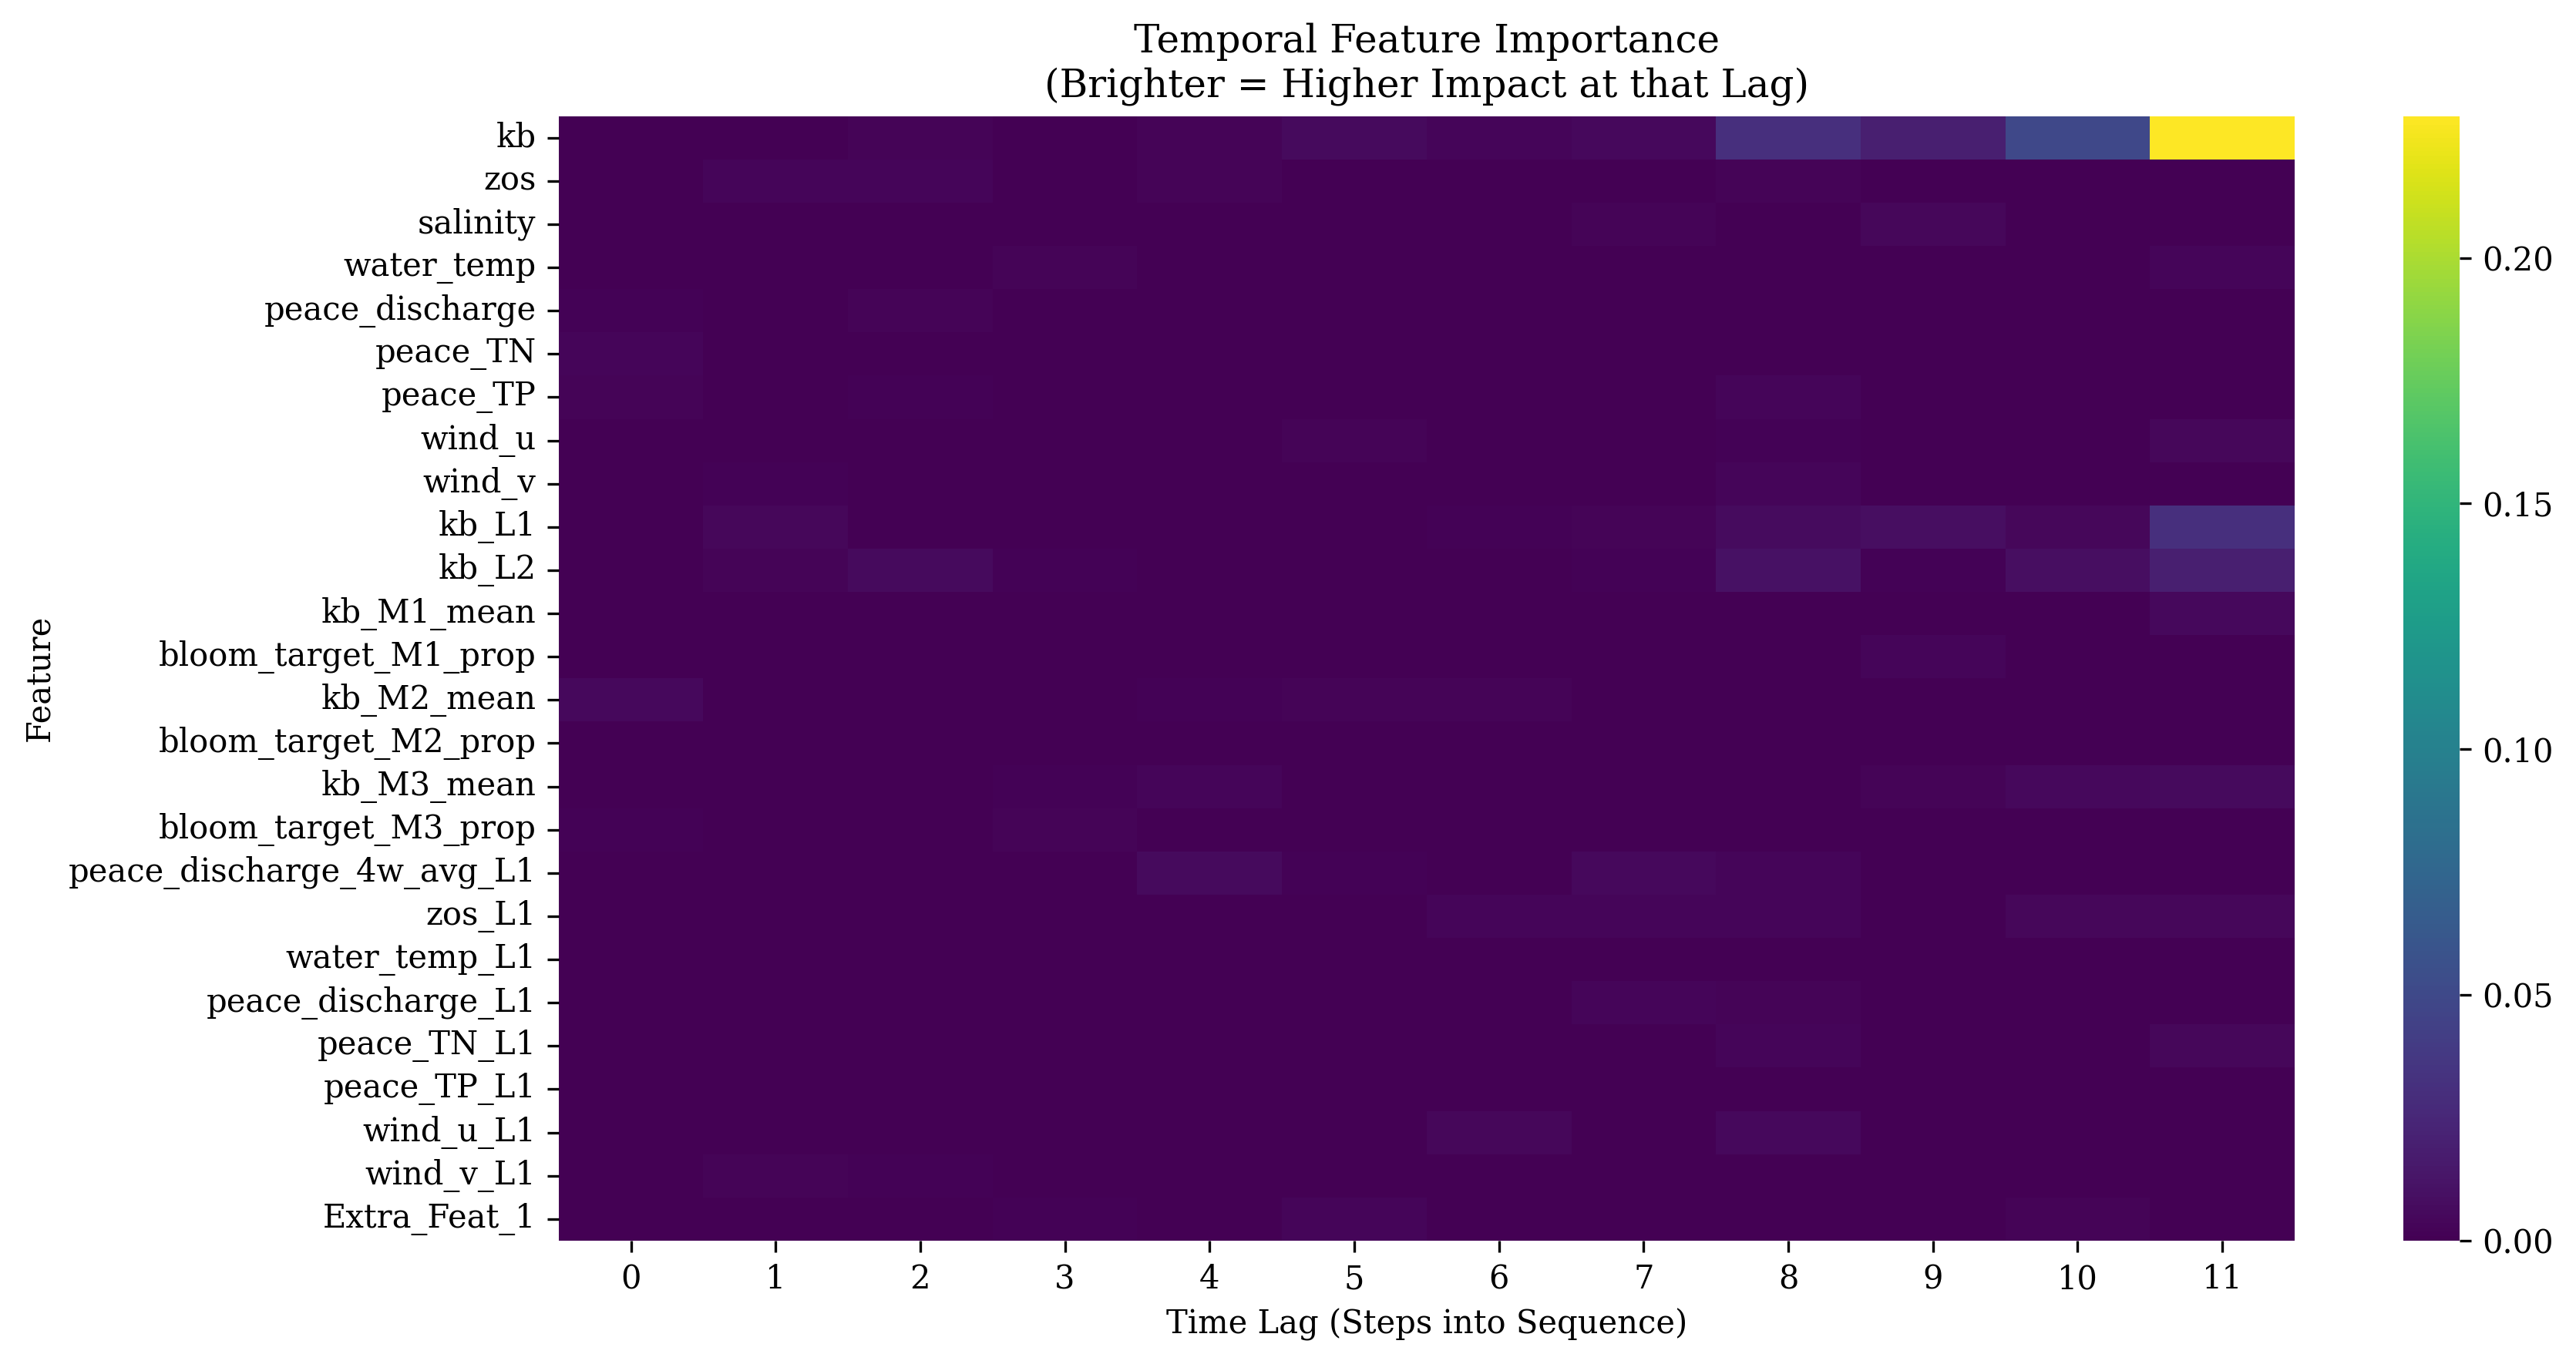

✅ SHAP Analysis Completed Successfully.


In [ ]:
try:
    # 1. Check & Fix Data Dimensions
    # ---------------------------------------------------------
    if 'X_test' not in locals() or 'trained_model' not in locals():
        raise NameError("Data or Model missing. Please restart kernel and run Steps 1-9.")

    true_n_steps = X_test.shape[1]    # e.g., 12
    true_n_features = X_test.shape[2] # e.g., 26

    print(f"Data Shape: {true_n_steps} steps, {true_n_features} features")

    # Fix the feature name list if it doesn't match the data
    current_names = final_feature_columns_used if 'final_feature_columns_used' in locals() else []

    if len(current_names) != true_n_features:
        print(f"Mismatch: {len(current_names)} names vs {true_n_features} data features.")
        diff = true_n_features - len(current_names)
        # We assume the extra columns are usually appended at the end
        plotting_feature_names = current_names + [f"Extra_Feat_{i+1}" for i in range(diff)]
    else:
        plotting_feature_names = current_names

    # 2. Define Wrapper (The Fix)
    # ---------------------------------------------------------
    def model_wrapper(flat_data):
        """
        Converts flat SHAP input back to 3D and queries the model
        using Direct Call (not .predict) to avoid TF Graph errors.
        """
        # Convert Numpy -> Tensor
        # Reshape to (Samples, Time, Features)
        reshaped = flat_data.reshape(-1, true_n_steps, true_n_features)
        tensor_input = tf.convert_to_tensor(reshaped, dtype=tf.float32)

        # Direct call (Eager Mode) - Faster and safer for SHAP
        probs = trained_model(tensor_input, training=False)

        # Return as Numpy flattened array
        return probs.numpy().flatten()

    # 3. Optimize Background (K-Means)
    # ---------------------------------------------------------
    print("Summarizing background data...")
    # Flatten train data: (Samples, Time*Feats)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)

    # Summarize training data into 10 weighted points (Centroids)
    background_summary = shap.kmeans(X_train_flat, 10)

    # 4. Initialize KernelExplainer
    # ---------------------------------------------------------
    print("Initializing KernelExplainer...")
    explainer = shap.KernelExplainer(model_wrapper, background_summary)

    # 5. Calculate SHAP Values
    # ---------------------------------------------------------
    explain_size = 20  # Keep small for speed
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Pick random samples to explain
    idxs = np.random.choice(X_test_flat.shape[0], explain_size, replace=False)
    X_test_sample = X_test_flat[idxs]

    print(f"Calculating SHAP values for {explain_size} instances...")
    # nsamples=auto usually works best, or try 500 if slow
    shap_values = explainer.shap_values(X_test_sample, nsamples=500)

    print(f"SHAP calculation complete.")

    # 6. Reshape for Visualization
    # ---------------------------------------------------------
    # (Samples, Flat_Features) -> (Samples, Time, Features)
    shap_values_3d = np.array(shap_values).reshape(-1, true_n_steps, true_n_features)
    X_test_sample_3d = X_test_sample.reshape(-1, true_n_steps, true_n_features)

    # 7. PLOT A: Global Feature Importance
    # ---------------------------------------------------------
    # Sum SHAP impact across all time steps
    shap_sum_over_time = np.sum(shap_values_3d, axis=1) # (Samples, Features)
    features_mean = np.mean(X_test_sample_3d, axis=1)   # (Samples, Features)

    plt.figure(figsize=(10, 8), dpi=300)
    shap.summary_plot(shap_sum_over_time, features_mean,
                      feature_names=plotting_feature_names, show=False)
    plt.title("Global Feature Importance")
    plt.tight_layout()
    plt.savefig("output/shap_summary_global.png")
    plt.show()

    # 8. PLOT B: Temporal Heatmap
    # ---------------------------------------------------------
    # Average absolute impact per time step
    temporal_importance = np.mean(np.abs(shap_values_3d), axis=0) # (Time, Feats)

    plt.figure(figsize=(12, 6), dpi=300)
    sns.heatmap(temporal_importance.T, cmap='viridis',
                yticklabels=plotting_feature_names,
                xticklabels=range(true_n_steps))

    plt.title("Temporal Feature Importance\n(Brighter = Higher Impact at that Lag)")
    plt.xlabel("Time Lag (Steps into Sequence)")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.savefig("output/shap_temporal_heatmap.png")
    plt.show()

    print("✅ SHAP Analysis Completed Successfully.")

except Exception as e:
    print(f"❌ SHAP Failed: {e}")
    import traceback
    traceback.print_exc()

# TLCC Analysis


--- Onset Latency Analysis (Threshold: 0.3) ---
Actual Bloom Starts found: 10
Predicted Bloom Starts found: 4
  Event at Week 8: Model is PERFECT by 0 weeks.
  Event at Week 70: MISSED COMPLETELY (No prediction within 4 weeks)
  Event at Week 98: MISSED COMPLETELY (No prediction within 4 weeks)
  Event at Week 103: MISSED COMPLETELY (No prediction within 4 weeks)
  Event at Week 112: MISSED COMPLETELY (No prediction within 4 weeks)
  Event at Week 168: Model is LATE by 1 weeks.
  Event at Week 179: MISSED COMPLETELY (No prediction within 4 weeks)
  Event at Week 182: MISSED COMPLETELY (No prediction within 4 weeks)
  Event at Week 190: MISSED COMPLETELY (No prediction within 4 weeks)
  Event at Week 196: MISSED COMPLETELY (No prediction within 4 weeks)

>>> AVERAGE LATENCY: 0.50 Weeks
    (Positive = The model is LAGGING)


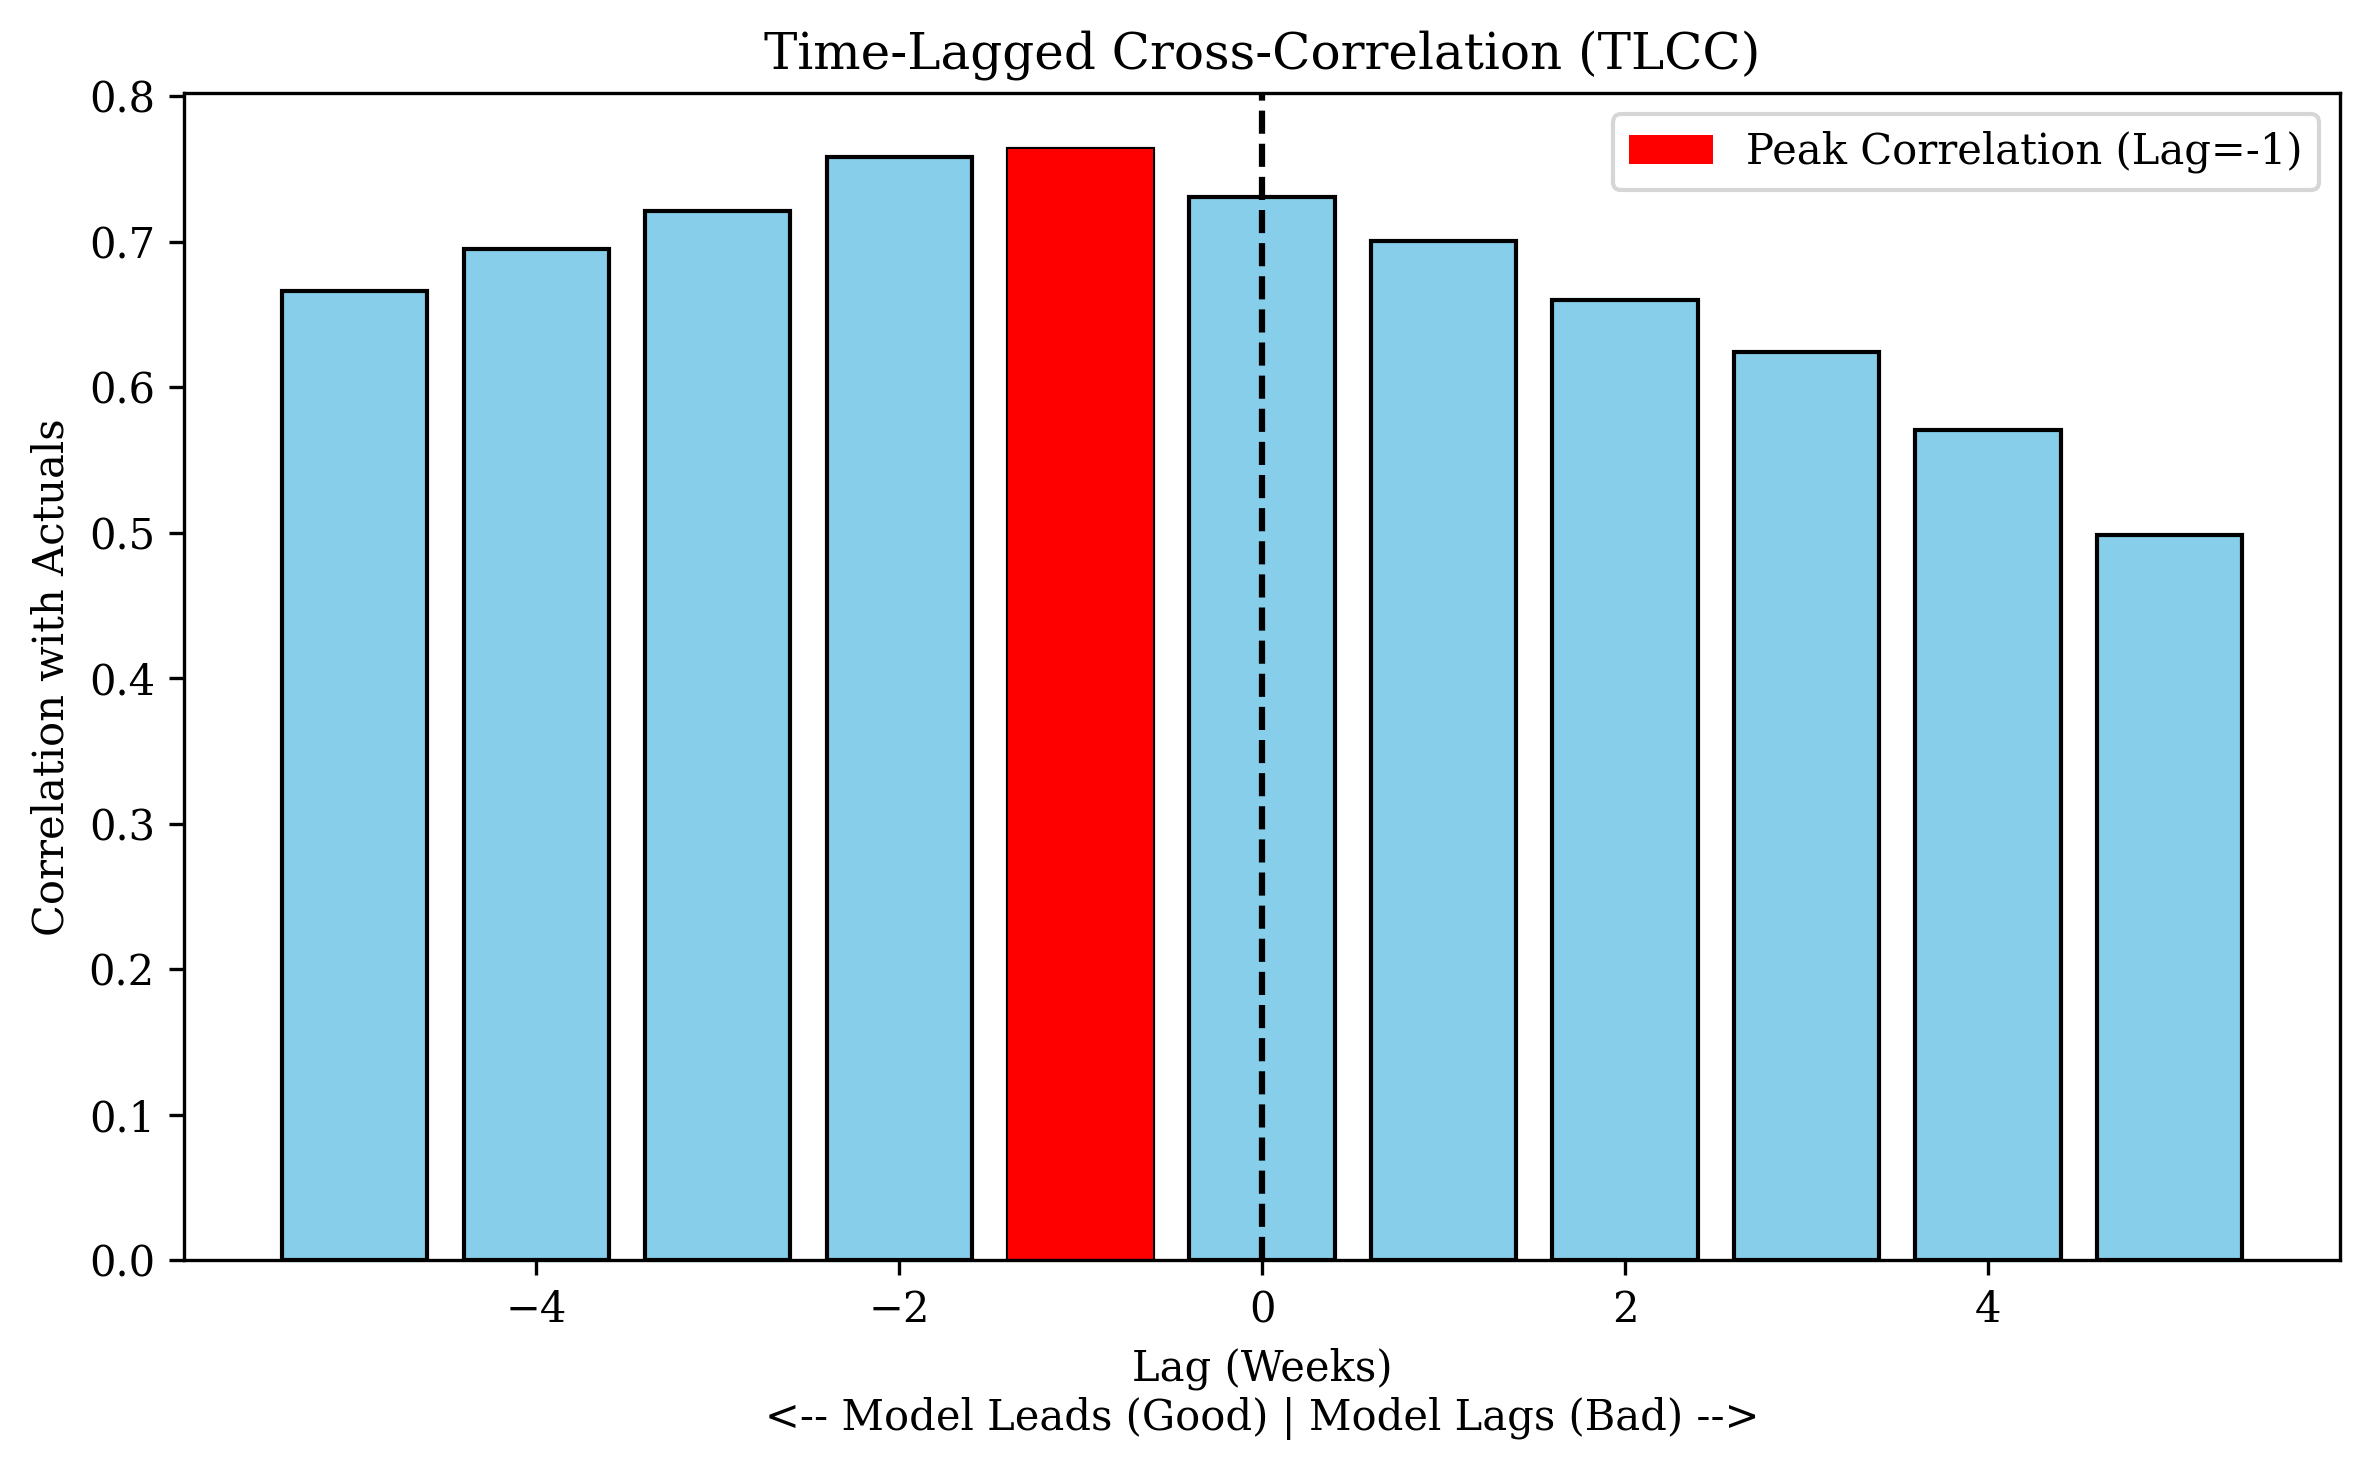

In [ ]:
def analyze_onset_lag(y_true, y_pred_prob, threshold=0.3, tolerance=4):
    """
    Calculates exactly how many weeks late (or early) the model predicts blooms.

    Args:
        y_true: Binary actuals (0/1)
        y_pred_prob: Continuous probabilities (0.0-1.0)
        threshold: Decision threshold
        tolerance: Max weeks to look for a matching predicted onset
    """
    print(f"\n--- Onset Latency Analysis (Threshold: {threshold}) ---")

    y_pred_class = (y_pred_prob >= threshold).astype(int)

    # 1. Identify "Start" events (0 -> 1 transitions)
    # We use diff() to find where value changes from 0 to 1
    actual_onsets = np.where(np.diff(y_true, prepend=0) == 1)[0]
    pred_onsets = np.where(np.diff(y_pred_class, prepend=0) == 1)[0]

    print(f"Actual Bloom Starts found: {len(actual_onsets)}")
    print(f"Predicted Bloom Starts found: {len(pred_onsets)}")

    if len(actual_onsets) == 0:
        print("No blooms in test set to analyze.")
        return

    # 2. Match Actual Starts to Nearest Predicted Start
    lags = []

    for t_actual in actual_onsets:
        # Find predicted onsets within 'tolerance' weeks window
        # We look for the closest prediction around the actual event
        nearby_preds = pred_onsets[np.abs(pred_onsets - t_actual) <= tolerance]

        if len(nearby_preds) > 0:
            # Find the closest one
            closest_pred = nearby_preds[np.argmin(np.abs(nearby_preds - t_actual))]

            # Lag = Predicted Time - Actual Time
            # Positive = Late (Lag)
            # Negative = Early Warning (Lead)
            lag = closest_pred - t_actual
            lags.append(lag)

            status = "LATE" if lag > 0 else "EARLY" if lag < 0 else "PERFECT"
            print(f"  Event at Week {t_actual}: Model is {status} by {abs(lag)} weeks.")
        else:
            print(f"  Event at Week {t_actual}: MISSED COMPLETELY (No prediction within {tolerance} weeks)")
            lags.append(np.nan) # Missed event

    # 3. Summary Stats
    lags_clean = [l for l in lags if not np.isnan(l)]
    if lags_clean:
        avg_lag = np.mean(lags_clean)
        print(f"\n>>> AVERAGE LATENCY: {avg_lag:.2f} Weeks")
        if avg_lag > 0:
            print("    (Positive = The model is LAGGING)")
        else:
            print("    (Negative = The model gives EARLY WARNING)")
    else:
        print("\n>>> No matched events found.")

    # 4. Visualizing the Lag
    # Cross-Correlation Plot (Statistical Proof)
    # Shift predictions back/forward and see where correlation is highest
    shifts = range(-5, 6) # Shift -5 to +5 weeks
    correlations = []
    for s in shifts:
        # Shift predicted probabilities
        if s < 0:
            p_shifted = y_pred_prob[-s:]
            y_shifted = y_true[:s]
        elif s > 0:
            p_shifted = y_pred_prob[:-s]
            y_shifted = y_true[s:]
        else:
            p_shifted = y_pred_prob
            y_shifted = y_true

        # Calculate correlation
        if len(y_shifted) > 0:
            corr = np.corrcoef(y_shifted, p_shifted)[0, 1]
            correlations.append(corr)
        else:
            correlations.append(0)

    plt.figure(figsize=(8, 5), dpi=300)
    plt.bar(shifts, correlations, color='skyblue', edgecolor='black')

    # Highlight the max
    max_idx = np.argmax(correlations)
    best_lag = shifts[max_idx]
    plt.bar(best_lag, correlations[max_idx], color='red', label=f'Peak Correlation (Lag={best_lag})')

    plt.title("Time-Lagged Cross-Correlation (TLCC)")
    plt.xlabel("Lag (Weeks)\n<-- Model Leads (Good) | Model Lags (Bad) -->")
    plt.ylabel("Correlation with Actuals")
    plt.axvline(0, color='black', linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.savefig("output/lag_analysis.png")
    plt.show()

# --- Execute ---
if __name__ == "__main__":
    if 'mc_preds' in locals() and 'y_test_trimmed' in locals():
        # Get mean probs
        probs = np.mean(mc_preds, axis=1)

        # Run with your chosen threshold (e.g., 0.3)
        analyze_onset_lag(y_test_trimmed.flatten(), probs.flatten(), threshold=0.3)